# q3dfit notebook: JWST/MIRI data of XID2028

<h3><font color='teal'>Installation of the environment and the package are described <a href="https://q3dfit.readthedocs.io/">here</a>. </font></h3>

This Jupyter notebook allows you to run Q3Dfit, a PSF decomposition and spectral analysis package tailored for JWST NIRSpec and MIRI IFU observations. 

Q3Dfit is developed as a science-enabling data product by the Early Release Science Team #1335 Q3D. You can find more information about this ERS program **Q3D** [here](https://q3d.github.io/) and [here](https://www.stsci.edu/jwst/science-execution/approved-programs/dd-ers/program-1335).

The software is based on the existing package IFSFIT developed by Dave Rupke (see [ADS link](https://ui.adsabs.harvard.edu/abs/2017ApJ...850...40R/abstract)).

The following notebook will guide you through the initialization procedure and will then perform the analysis. 

## Table of Contents

* [1. Initialization](#chapter1)
    * [1.0. Setting up the directory tree](#chapter1_0)
    * [1.1. Initializing the fit](#chapter1_1)
    * [1.2. Setting up the data and models](#chapter1_2)
    * [1.3. Setting up the fitting parameters](#chapter1_3)
        * [1.3.1. Emission line parameters](#chapter1_3_1)
        * [1.3.2. Continuum parameters](#chapter1_3_2)
* [2. Run fitting](#chapter2)
* [3. Plot fit](#chapter3)
* [4. Combine fit results for entire cube](#chapter4)
* [5. Map fit results](#chapter5)

## 1. Initialization <a class="anchor" id="chapter1"></a>

In [1]:
import os.path
import numpy as np
from astropy.io import fits
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Be sure to set the path to q3dfit correctly.
# For instance:
#import sys
#sys.path.append('/Users/jwstuser/q3dfit/')
import sys
sys.path.append("../")

### 1.0. Setting up the directory tree <a class="anchor" id="chapter1_0"></a>

Define the directories in which the data cube(s) that you want to analyse are stored and the output directories. We recommend creating a working directory that you name after your target, in which all outputs from q3dfit will be saved. Then download test data.

In [3]:
# Base directory (book-keeping)
volume = 'XID2028/'
# prefix label for output files
gal = 'XID2028'
# Input directory
indir = volume
if not os.path.exists(indir):
    os.makedirs(indir)
# Output directory
outdir = volume
if not os.path.exists(outdir):
    os.makedirs(outdir)
# Initialization file (q3di.npy) directory
initdir = volume
# Output logfile
label='XID2028'
logfile = outdir+label+'-fitlog.txt'

Download data from public Box folder:

In [4]:
# make tuples of urls and download filenames
# infile = data cube
#infile_tup=('https://rhodes.box.com/shared/static/scu2ydokah2wcqtfsh1tg2y76m75b91q.fits','nirspec-j1652.fits')
# download files; by default don't force overwrite and take first element of output
#from q3dfit.jnb import download_files
#infile = download_files(infile_tup, outdir, force=False)[0]
# add subdirectory to filenames
#infile = initdir+infile

In [5]:
infile = '../../../DATA_Reduction/MIRI_MRS_reduction/my_jwebbinar_prep/ifu_session/sci/stage3_SkipOutlier/SkipOutlier_chancube_ch4-short_s3d.fits'
cfinfile = '/Users/caroline/Documents/ARI-Heidelberg/Q3D/input/Config_files/MIRI_XID2028.cf'

### 1.1. Initializing the fit <a class="anchor" id="chapter1_1"></a>

The initial parameters of the fit are stored in an object of class `q3din`. Each parameter or attribute of this class controls some aspect of the fit process. We start by instantiating the class. The only required parameters at the outset are the input data cube and label; the label is used for output file naming. 

The default JWST pipeline output has data, variance, and data quality in extensions 1, 2, and 3, respectively. Our processed cube has a different set of extensions, so we specify them here.

In [6]:
from q3dfit.q3din import q3din
#q3di = q3din(infile, label, datext=0, varext=1, dqext=2, outdir=outdir, logfile=logfile)
q3di = q3din(infile, label, datext=1, varext=2, dqext=3, outdir=outdir, logfile=logfile)

Here's a list of the fit parameters that are automatically set:

In [7]:
q3di.__dict__

{'argsreadcube': {},
 'cutrange': None,
 'infile': '../../../DATA_Reduction/MIRI_MRS_reduction/my_jwebbinar_prep/ifu_session/sci/stage3_SkipOutlier/SkipOutlier_chancube_ch4-short_s3d.fits',
 'fitrange': None,
 'label': 'XID2028',
 'logfile': 'XID2028/XID2028-fitlog.txt',
 'name': None,
 'outdir': 'XID2028/',
 'spect_convol': {},
 'vacuum': True,
 'zsys_gas': None,
 'datext': 1,
 'varext': 2,
 'dqext': 3,
 'vormap': None,
 'docontfit': False,
 'dolinefit': False}

### 1.2. Setting up the data and models <a class="anchor" id="chapter1_2"></a>

Some general information about your cube. `argsreadcube` is a dictionary of attributes sent to the `Cube` class.
- For non-JWST data, set `wmapext` to `None`. The WMAP extension is a [3-D weight image](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html) giving the relative weights of the output spaxels. While our data is from JWST, the wmap extension has been cut out during processing.
- Microns are the wavelength unit used internally, but `q3dfit` can accept input/output in Å.
- `q3dit` does calculations in f$_\lambda$ space, but assumes input units of MJy/sr, the JWST default. Other input wavelength units can be specified. In this case, the reduced data has been converted to erg/s/cm$^2$/Å. The output flux units will be in erg/s/cm$^2$/$\mu$m.

In [8]:
hdul = fits.open(infile)
argsreadcube = {'wmapext':4, #'datext': 1, 'varext': 2, 'dqext': 3, 
                'fluxnorm': 1e-18,  #'fluxnorm': 1e-14, #1e-8, 
                'pixarea_sqas': hdul[1].header['PIXAR_A2'], #0.0025,
                #'fluxunit_in': 'Jy', 
                #'fluxunit_in':'MJy/sr', 'waveunit_in': 'micron'
               }

#q3di.argsreadcube = {'wmapext': None,
#                     'fluxunit_in': 'erg/s/cm2/Angstrom'}
q3di.argsreadcube = argsreadcube
cube = q3di.load_cube()

Size of data cube: [ 35 , 35 , 542 ]
Wavelength range: [ 17.703001 , 20.949001 ]  micron


Let's plot a spaxel near the quasar to see how it looks. The arguments are column and row in unity-offset units. This is the region of the galaxy's spectrum containing H$\beta$ and [OIII] 4959, 5007 Å. The flux units are erg/s/cm$^2$/$\mu$m.

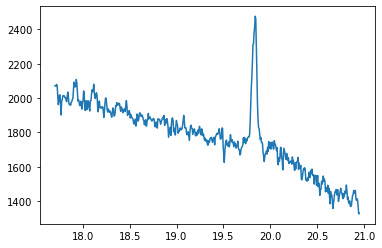

In [9]:
spec_test = cube.specextract(19,18, radius=0)

Due to the fact that JWST/NIRSpec undersamples the PSF, bright point sources create undulations in the spectrum. We apply light smoothing with a circular aperture of radius 2.5 spaxels to account for this, and then plot the result.

In [10]:
#cube.convolve(2.5)

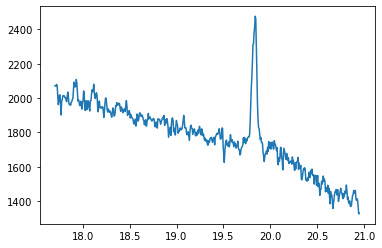

In [11]:
spec_conv = cube.specextract(19,18, radius=0)

Now we'll write this convolved cube to disk, and redefine it as our input file for the fit.

In [12]:
#cube.writefits(initdir+'MIRI-XID2028-conv.fits')
#q3di.infile = initdir+'MIRI-XID2028-conv.fits'

This time, we are going to normalize to minimize numerical issues in the fitting.

In [13]:
q3di.argsreadcube = {#'wmapext': None, 
                     #'fluxunit_in': 'erg/s/cm2/micron',
                     'fluxnorm': 1e-18}
cube = q3di.load_cube()

Size of data cube: [ 35 , 35 , 542 ]
Wavelength range: [ 17.703001 , 20.949001 ]  micron


Let's double-check what we have:

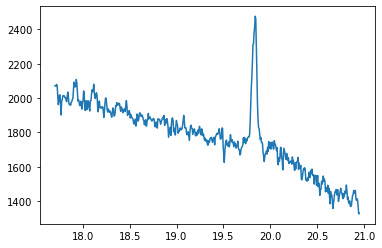

In [14]:
spec_test = cube.specextract(19.,18., radius=0)

Name and systemic redshift of the galaxy. `zsys_gas` is an input for calculating velocity maps in `q3dpro` and for initializing the arrays of initial guesses below.

In [15]:
q3di.name = 'XID2028'
q3di.zsys_gas = 1.59

Wavelength range over which to fit data. The user can also specify sets of regions to ignore in the fit.

In [16]:
q3di.fitrange = [17.8, 20.8]
q3di.fitrange = [19.2, 20.5]
#q3di.cutrange = np.array([,])

Create quasar template from the peak spaxel. We normalize so the template flux is around unity.

makeqsotempate: using peak spaxel in white light as center


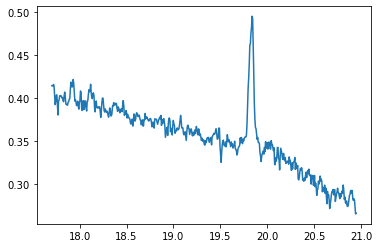

In [17]:
qsotemplate = '../q3dfit/data/questfit_templates/'+'XID2028_qso.npy'
cube.makeqsotemplate(qsotemplate, radius=0., norm=5e3)

### 1.3. Setting up the fitting parameters <a class="anchor" id="chapter1_3"></a>

#### 1.3.1. Emission-line parameters <a class="anchor" id="chapter1_3_1"></a>

What lines do you want to fit? You can choose from the linelists available [here](https://github.com/Q3D/q3dfit/tree/main/q3dfit/data/linelists), or in `q3dfit/data/linelists/`.

In [18]:
lines = ['[NeVI]7.65'] #'H2_00_S5', '[ArII]6.99', '[NeVI]7.65']

This block sets up initial conditions for the emission-line fit to each spaxel. This initialization method adds a number of new attributes to the object. Emission lines are set to a common redshift and velocity dispersion, set to `q3di.zsys_gas` and 50 km/s by default. However, different sets of emission lines can have different velocities and linewidths by specifying different lines to which to tie particular emission lines. Different initial conditions can also be set on a spaxel-by-spaxel and/or line-by-line basis. The default number of velocity components is 1. Here, we change this to 3.

In [19]:
q3di.init_linefit(lines, linetie='[NeVI]7.65', maxncomp=3)
q3di.__dict__.keys()

dict_keys(['argsreadcube', 'cutrange', 'infile', 'fitrange', 'label', 'logfile', 'name', 'outdir', 'spect_convol', 'vacuum', 'zsys_gas', 'datext', 'varext', 'dqext', 'vormap', 'docontfit', 'dolinefit', 'ncols', 'nrows', 'cubedim', 'lines', 'argscheckcomp', 'argslineinit', 'argslinefit', 'argslinelist', 'checkcomp', 'fcncheckcomp', 'fcnlineinit', 'maxncomp', 'peakinit', 'siglim_gas', 'linetie', 'ncomp', 'siginit_gas', 'zinit_gas'])

Because of the complexity of these line profiles, we change the default initial conditions. `zinit_gas` and `siginit_gas` are dictionaries of arrays that hold the initial conditions for each line, spaxel, and velocity component.

In [20]:
#for i in lines:
#    # narrow, redshifted component
#    q3di.zinit_gas[i][:,:,2] = 1.59
#    # broad, blueshifted component
#    q3di.zinit_gas[i][:,:,1] = 1.59
#    q3di.siginit_gas[i][:,:,1] = 500.

`siglim_gas` sets lower and upper bounds for the Gaussian width (sigma) of the emission line. These limits can be set globablly, for all spaxels and components, by defining a 2-element array. The limits can also be set for individual spaxels (but all components) by defining an (Ncol x Nrow x 2) array.

In [21]:
# Global limit
q3di.siglim_gas = np.array([5., 2000.])

# Spaxel-by-spaxel limit
# siglim_gas = np.ndarray((dx, dy, 2))
# siglim_gas[:,:,] = array([5.,1000.])
# siglim_gas[13, 10, :] = array([5.,500.])

The routine `checkcomp` automatically discards components that it deems insignificant after each fit. It does so with both a significance cut on flux, and if the linewidth is too large. If components are removed, the fit is re-run. The `sigcut` parameter determines the level of the significance cut. `ignore` is a list of lines to ignore when performing the significance cut. Component checking can be disabled by setting `checkcomp = False`.

In [22]:
q3di.checkcomp = False
q3di.argscheckcomp['sigcut'] = 3.
#q3di.argscheckcomp['ignore']= ['Hbeta']

#### Line ratio constraints
Lines with ratios fixed by atomic physics have their ratios fixed automatically. Other line ratios can have bound constraints applied, or they can be fixed to a particular value.

`line1`, `line2`, and `comp` are required. `comp` is an array of velocity components (zero-indexed) on which to apply the constraints, one array for each pair of lines.

`value` is the initial value of `line1`/`line2`. Presently, if `value` is specified for one pair of lines, it must be specified for all. Otherwise, the initial value is determined from the data.

The ratio can be `fixed` to the initial value. Presently, if `fixed` is defined, it must be set to `True` or `False` for all pairs of line.

If the ratio is not `fixed`, `lower` and `upper` limits can also be specified. (If they are not, and the line pair is a doublet in the doublets.tbl file, then the lower and upper limits are set using the data in that file.) Presently, if `lower` or `upper` is defined here for one set of lines, it must be defined here for every pair of lines.

In [23]:
# Required columns:
# line1 = ['[NI]5198', '[SII]6716']
# line2 = ['[NI]5200', '[SII]6731']
# comp = np.array([[0], [0]], dtype=np.int32)

# Optional columns:
# value = [1.5, 1.]
# fixed = [True, False]
# lower = []
# upper = []

# Write table
# from astropy.table import QTable
# lineratio = QTable([line1, line2, comp, value, fixed], names=['line1', 'line2', 'comp', 'value', 'fixed'])

# q3di.argslineinit['lineratio']=lineratio

#### Spectral resolution convolution
##### Just running convolution ---

If no convolution is desired, then set `spectres_convolve` to None. 
If convolution is desired, then `spectres_convolve` and `spect_instrum` are required variables.

Specify the desired convolution method using `spect_instrum`. The syntax is: 
`spect_instrum = {INSTRUMENT:[METHOD]}`, which should mirror the filename in `q3dfit/data/dispersion_files/`. METHOD specifies the grating, spectral resolution [R], Δλ FWHM in [Å], velocity in [km/s].

Examples convolving with: 
1. flat R=500: `spect_instrum = {'flat':['R500']}`
2. flat velocity FWHM = 30km/s: `spect_instrum = {'flat':['kms30']}`
3. flat Δλ FWHM = 4 Å: `spect_instrum = {'flat':['dlambda4']}`
4. JWST NIRSPEC / G140M: `spect_instrum = {'JWST_NIRSPEC':['G140M']}`

If desired flat convolution file does not exist, then a new file will be created automatically. 

This case applies to the GMOS B600 grating. Gemini website says R = 1688 at 4610 A for 0.5" slit, with IFU 0.31" eff. slit. This gives 1.69 A FWHM. I measure sometimes closer to 1.5-1.6 A.

In [24]:
#spect_instrum = {'JWST_NIRSPEC':['G235H']}
spect_instrum = {'JWST_MIRI':['CH4A']}
q3di.spect_convol['ws_instrum'] = spect_instrum

##### Creating convolution files (optional) ---

If the user wants to create a dispersion file, there are 2 methods:

1. First, run `from q3dfit.common.spectConvol import dispFile` and initialize: `dispObj = dispFile()`
2. Create the files with either method A or B

2.(A) Create a flat R=120 dispersion file from 10 μm to 30 μm: 

`dispObj.make_dispersion(120,WAVELEN=[10,30],TYPE='R')`

2.(B) Create a custom dispersion file with user supplied wavelength and Resolving power lists:

`dispObj.make_custom_dispersion([wavelen list],R=[some R list],FILENAME='custom_RlistA_disp')`

3. Specify desired dispersion file in convolution: running custom example 2B

`spect_instrum = {'custom':['RlistA']}`


In [25]:
#from q3dfit.common.spectConvol import dispFile
#dobj = dispFile()
#dispObj.make_custom_dispersion([wavelen list],R=[some R list],FILENAME='custom_RlistA_disp')
#spect_instrum = {'custom':['RlistA']}

#### Options to `lmfit` and `scipy.optimize.least_squares`
`q3dfit` uses the `fit` method of the [`Model` class](https://lmfit.github.io/lmfit-py/model.html#lmfit.model.Model) of `lmfit` to call [`scipy.optimize.least_squares`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html). Both the method and function have options which can be changed in the `q3dfit` call. To do so, add key/value pairs to the `argslinefit` dictionary, which in turn is a keyword of the `q3di` dictionary.

The options to the `fit` method in `lmfit` that can currently be changed are the following:
- `max_nfev`: maximum number of function evaluations before the fit aborts
- `iter_cb`: if this is set to "per_iteration", the value of every model parameter at each function evaluation is printed to `stdout`

Most parameters of `least_squares` can be changed in this way, unless they are specifically set by `lmfit`. Examples which have been tested include:
- `x_scale`: jac
- `tr_solver`: lsmr
- `loss`: soft_l1
- `ftol`, `gtol`, `xtol`

In [26]:
#q3di.argslinefit['iter_cb'] = 'per_iteration'
# As an example, to change the criteria for fit convergence from the defaults of 1.e-8 to 1.e-10:
# q3di.argslinefit['ftol'] = 1.e-10
# q3di.argslinefit['gtol'] = 1.e-10
# q3di.argslinefit['xtol'] = 1.e-10

#### 1.3.2 Continuum parameters <a class="anchor" id="chapter1_3_2"></a>

We next initialize the continuum. As part of this, we give it the name of our continuum fitting function. (See Rupke et al. 2017 for more details on the methodology of `q3dfit` when separating a quasar from its host galaxy.)

In [27]:
do_questfit = True
if do_questfit:
    fcncontfit = 'questfit'
    argscontfit = dict()
    argscontfit['config_file'] = cfinfile
    argscontfit['outdir'] = outdir
    argscontfit['plot_decomp'] = True

In [28]:
if not do_questfit:
    #fcncontfit = 'fitqsohost'
    fcncontfit = 'fitpoly'
    q3di.init_contfit(fcncontfit)
else:
    q3di.init_contfit(fcncontfit, argscontfit=argscontfit, argscontplot={}, argsconvtemp={})
    q3di.dolinefit = True
q3di.__dict__.keys()

dict_keys(['argsreadcube', 'cutrange', 'infile', 'fitrange', 'label', 'logfile', 'name', 'outdir', 'spect_convol', 'vacuum', 'zsys_gas', 'datext', 'varext', 'dqext', 'vormap', 'docontfit', 'dolinefit', 'ncols', 'nrows', 'cubedim', 'lines', 'argscheckcomp', 'argslineinit', 'argslinefit', 'argslinelist', 'checkcomp', 'fcncheckcomp', 'fcnlineinit', 'maxncomp', 'peakinit', 'siglim_gas', 'linetie', 'ncomp', 'siginit_gas', 'zinit_gas', 'fcncontfit', 'argscontfit', 'argsconvtemp', 'decompose_qso_fit', 'decompose_ppxf_fit', 'dividecont', 'ebv_star', 'fcnconvtemp', 'forcefloat64', 'keepstarz', 'maskwidths', 'maskwidths_def', 'masksig_secondfit', 'nolinemask', 'nomaskran', 'startempfile', 'startempvac', 'tweakcntfit', 'siginit_stars', 'zinit_stars'])

`q3dfit` first masks emission lines before fitting. The default mask value is 500 km/s for each velocity component for the first fit. During the second fit, the mask value is set automatically using the best-fit linewidths determined from the first fit.

For this case, the lines are quite broad and we change the default.

In [29]:
q3di.maskwidths_def = 1000.

The continuum fitting parameters specified here are for the case of simultaneous fitting of a stellar and quasar template.
- `hostord` = [Optional] additive Legendre polynomial for host [starlight] component. Adds components up to order `hostord`.
- `qsoord` = [Optional] additive Legendre polynomial for host [starlight] component. Adds components up to order `qsoord`.
- `qsoxdr` = Filename and path of quasar template created earlier with `makeqsotemplate.py`.
- `refit` = Set to `ppxf` to fit (data - quasar) residual with stellar model.
- `blrpar` = Set of initial Gaussian parameters (flux, observed wavelength, sigma in km/s) for fitting empirical scattered-light model (relevant only for narrow set of cases).

In [30]:
if do_questfit:
    q3di.decompose_qso_fit = True
else:
    q3di.argscontfit['qsoxdr'] = qsotemplate
    q3di.argscontfit['qsoord'] = 2
    q3di.argscontfit['hostord'] = 2
    q3di.argscontfit['fitord'] = 3

In [31]:
if do_questfit:
    q3di.plotMIR = True

Optional arguments to `lmfit`. These are the tolerances for determining fit convergence, described in further detail [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html).

In [32]:
#argslmfit = dict()
#argslmfit['ftol'] = 1.e-10
#argslmfit['gtol'] = 1.e-10
#argslmfit['xtol'] = 1.e-10

#q3di.argscontfit['argslmfit'] = argslmfit

If you want to run `q3dfit` in batch mode, run this cell, which saves q3di to an `npy` file. In your python command line, read in file and run `q3dfit` with
<pre><code>q3di = '/path/to/the/npy/file/q3di.npy'
from q3dfit.q3dfit import q3dfit
q3dfot(q3di,cols=cols,rows=rows)</code></pre>
N.B.: When running `q3dfit` using multiple cores (`ncores=N` in the call to `q3df`), the input dictionary has to be specified in this way; i.e., as a string describing the location of this .npy file.

In [33]:
q3di_npy = 'q3di.npy'
np.save(initdir+q3di_npy, q3di)

## 2. Run fit <a class="anchor" id="chapter2"></a>

Choose columns and rows to fit. Ranges are specified as two-element lists specifying the first and last spaxel.

In [36]:
cols = [21]
rows = [18]

cols = [0,35]
rows = [0,35]

Run the fit. Choose `quiet=False` for verbose output. An output object for each spaxel, of class `q3dout`, is saved to a numpy binary file labeled with prefix `q3di['label']` and suffix `_col_row.npy`. See note above on multicore processing.

In [ ]:
from q3dfit.q3df import q3dfit
q3dfit(q3di,cols=cols,rows=rows, quiet=False)

Core 1: # spaxels fit=1296
[col,row]=[0,0] out of [35,35]
[col,row]=[0,1] out of [35,35]
[col,row]=[0,2] out of [35,35]
[col,row]=[0,3] out of [35,35]
[col,row]=[0,4] out of [35,35]
[col,row]=[0,5] out of [35,35]
[col,row]=[0,6] out of [35,35]
[col,row]=[0,7] out of [35,35]
[col,row]=[0,8] out of [35,35]
[col,row]=[0,9] out of [35,35]
[col,row]=[0,10] out of [35,35]
[col,row]=[0,11] out of [35,35]
[col,row]=[0,12] out of [35,35]
[col,row]=[0,13] out of [35,35]
[col,row]=[0,14] out of [35,35]
[col,row]=[0,15] out of [35,35]
[col,row]=[0,16] out of [35,35]
[col,row]=[0,17] out of [35,35]
[col,row]=[0,18] out of [35,35]
[col,row]=[0,19] out of [35,35]
[col,row]=[0,20] out of [35,35]
[col,row]=[0,21] out of [35,35]
[col,row]=[0,22] out of [35,35]
[col,row]=[0,23] out of [35,35]
[col,row]=[0,24] out of [35,35]
[col,row]=[0,25] out of [35,35]
[col,row]=[0,26] out of [35,35]
[col,row]=[0,27] out of [35,35]
[col,row]=[0,28] out of [35,35]
[col,row]=[0,29] out of [35,35]
[col,row]=[0,30] out of

1.0
1.0
1.0
1.0
1.0
[[Variables]]
    template_0_amp:        6.8181e-05 (init = 0.059)
    template_1_amp:        2.6041e-06 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         4.4087e-08 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          6.6550e-07 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='

[[Variables]]
    template_0_amp:        1.2413e-06 (init = 0.059)
    template_1_amp:        1.0450e-07 (init = 0.175)
    template_1_ext_Av:     0.50000000 (init = 1.5)
    blackbody250a:         1.3477e-09 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          3.4311e-07 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.2464e+03                                    3.00e+01    
       1              2         1.2212e+03      2.52e+01       5.62e+01       2.14e+01    
       2              3         1.2207e+03      4.84e-01       6.11e+00       1.33e+01    
       3              4    

[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be estimated:
    lbNeVIrb7pt65_0_flx:  at initial value
    lbNeVIrb7pt65_0_flx:  at boundary
    lbNeVIrb7pt65_0_cwv:  at initial value
    lbNeVIrb7pt65_0_sig:  at initial value
    lbNeVIrb7pt65_1_flx:  at initial value
    lbNeVIrb7pt65_1_flx:  at boundary
    lbNeVIrb7pt65_1_cwv:  at initial value
    lbNeVIrb7pt65_1_sig:  at

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

[[Variables]]
    template_0_amp:        0.00143873 (init = 0.059)
    template_1_amp:        1.1831e-04 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         1.0909e-06 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          1.8756e-04 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be estimated:
    lbNeVIrb7pt65_0_flx:  at boundary
    lbNeVIrb7pt65_0_cwv:  at initial value
    lbNeVIrb7pt65_0_sig:  at initial value
    lbNeVIrb7pt65_1_flx:  at boundary
    lbNeVIrb7pt65_1_cwv:  at initial value
    lbNeVIrb7pt65_1_sig:  at initial value
    lbNeVIrb7pt65_2_flx:  at boundary
    lbNeVIrb7pt65_2_cwv:  at init

[[Variables]]
    template_0_amp:        0.00701065 (init = 0.059)
    template_1_amp:        0.00205284 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         4.4251e-06 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          0.00235840 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

1.0
1.0
1.0
[[Variables]]
    template_0_amp:        1.5332e-05 (init = 0.059)
    template_1_amp:        2.0812e-06 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         1.0567e-08 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          1.6323e-06 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb

[[Variables]]
    template_0_amp:        0.00639111 (init = 0.059)
    template_1_amp:        1.0663e-04 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         5.5588e-06 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          6.3837e-04 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be estimated:
    lbNeVIrb7pt65_0_flx:  at boundary
    lbNeVIrb7pt65_0_cwv:  at initial value
    lbNeVIrb7pt65_0_sig:  at initial value
    lbNeVIrb7pt65_1_flx:  at boundary
    lbNeVIrb7pt65_1_cwv:  at initial value
    lbNeVIrb7pt65_1_sig:  at initial value
    lbNeVIrb7pt65_2_flx:  at boundary
    lbNeVIrb7pt65_2_cwv:  at init

[[Variables]]
    template_0_amp:        0.00156238 (init = 0.059)
    template_1_amp:        4.5276e-04 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         1.4654e-06 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          4.7195e-04 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.2508e+03                                    1.89e-10    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 1.2508e+03, final cost 1.2508e+03, first-order optimality 1.89e-10.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 217
    # variables        = 9
    chi-square         = 2501.53007
    reduced chi-square = 12.0265869
    Akaike info crit   = 548.513028
    Bayesian info crit = 578.932104
##  Warning: uncertainti

[[Variables]]
    template_0_amp:        0.02806314 (init = 0.059)
    template_1_amp:        0.00108918 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         2.6298e-05 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          0.00257406 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be estimated:
    lbNeVIrb7pt65_0_flx:  at boundary
    lbNeVIrb7pt65_0_cwv:  at initial value
    lbNeVIrb7pt65_0_sig:  at initial value
    lbNeVIrb7pt65_1_flx:  at boundary
    lbNeVIrb7pt65_1_cwv:  at initial value
    lbNeVIrb7pt65_1_sig:  at initial value
    lbNeVIrb7pt65_2_flx:  at boundary
    lbNeVIrb7pt65_2_cwv:  at init

1.0
1.0
[[Variables]]
    template_0_amp:        1.5546e-05 (init = 0.059)
    template_1_amp:        1.9599e-06 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         1.7781e-08 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          1.8336e-06 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt6

[[Variables]]
    template_0_amp:        1.0230e-04 (init = 0.059)
    template_1_amp:        6.8361e-05 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         2.2933e-07 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          2.0936e-05 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  W

[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be estimated:
    lbNeVIrb7pt65_0_flx:  at initial value
    lbNeVIrb7pt65_0_flx:  at boundary
    lbNeVIrb7pt65_0_cwv:  at initial value
    lbNeVIrb7pt65_0_sig:  at initial value
    lbNeVIrb7pt65_1_flx:  at initial value
    lbNeVIrb7pt65_1_flx:  at boundary
    lbNeVIrb7pt65_1_cwv:  at initial value
    lbNeVIrb7pt65_1_sig:  at

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

1.0
1.0
1.0
1.0
1.0
[[Variables]]
    template_0_amp:        0.00637875 (init = 0.059)
    template_1_amp:        2.1227e-04 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         5.3491e-06 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          6.9621e-04 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='

[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be estimated:
    lbNeVIrb7pt65_0_flx:  at initial value
    lbNeVIrb7pt65_0_flx:  at boundary
    lbNeVIrb7pt65_0_cwv:  at initial value
    lbNeVIrb7pt65_0_sig:  at initial value
    lbNeVIrb7pt65_1_flx:  at initial value
    lbNeVIrb7pt65_1_flx:  at boundary
    lbNeVIrb7pt65_1_cwv:  at initial value
    lbNeVIrb7pt65_1_sig:  at

[[Variables]]
    template_0_amp:        1.6047e-05 (init = 0.059)
    template_1_amp:        4.2280e-06 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         9.9273e-09 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          2.2303e-06 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

FITLOOP: Second call to FITSPEC
1.0
1.0
1.0
1.0
1.0
[[Variables]]
    template_0_amp:        0.02803395 (init = 0.059)
    template_1_amp:        0.00116506 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         1.1690e-05 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          0.00114271 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]

1.0
1.0
1.0
1.0
[[Variables]]
    template_0_amp:        0.00135214 (init = 0.059)
    template_1_amp:        1.7235e-04 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         3.5543e-09 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          1.6662e-05 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNe

FITLOOP: Second call to FITSPEC
1.0
1.0
1.0
1.0
1.0
[[Variables]]
    template_0_amp:        0.02517165 (init = 0.059)
    template_1_amp:        3.4533e-04 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         7.5578e-09 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          8.5806e-04 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]

[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be estimated:
    lbNeVIrb7pt65_0_flx:  at boundary
    lbNeVIrb7pt65_0_cwv:  at initial value
    lbNeVIrb7pt65_0_sig:  at initial value
    lbNeVIrb7pt65_1_flx:  at boundary
    lbNeVIrb7pt65_1_cwv:  at initial value
    lbNeVIrb7pt65_1_sig:  at initial value
    lbNeVIrb7pt65_2_flx:  at boundary
    lbNeVIrb7pt65_2_cwv:  at init

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  W

[[Variables]]
    template_0_amp:        0.02867153 (init = 0.059)
    template_1_amp:        0.00103740 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         2.0668e-05 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          6.7317e-04 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

[[Variables]]
    template_0_amp:        3.1120e-04 (init = 0.059)
    template_1_amp:        1.6959e-05 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         3.3993e-08 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          1.4520e-05 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be estimated:
    lbNeVIrb7pt65_0_flx:  at initial value
    lbNeVIrb7pt65_0_flx:  at boundary
    lbNeVIrb7pt65_0_cwv:  at initial value
    lbNeVIrb7pt65_0_sig:  at initial value
    lbNeVIrb7pt65_1_flx:  at initial value
    lbNeVIrb7pt65_1_flx:  at boundary
    lbNeVIrb7pt65_1_cwv:  at initial value
    lbNeVIrb7pt65_1_sig:  at

[[Variables]]
    template_0_amp:        3.5260e-04 (init = 0.059)
    template_1_amp:        1.1508e-04 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         6.4151e-06 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          3.0463e-07 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

FITLOOP: Second call to FITSPEC
1.0
1.0
1.0
1.0
1.0
[[Variables]]
    template_0_amp:        0.00165949 (init = 0.059)
    template_1_amp:        0.00235895 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         7.4491e-04 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          1.9895e-04 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]

[[Variables]]
    template_0_amp:        0.02834281 (init = 0.059)
    template_1_amp:        0.00193488 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         2.5804e-05 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          1.8514e-04 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

[[Variables]]
    template_0_amp:        0.00658291 (init = 0.059)
    template_1_amp:        3.4589e-04 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         5.1722e-06 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          3.7802e-04 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

FITLOOP: Second call to FITSPEC
1.0
1.0
1.0
1.0
1.0
[[Variables]]
    template_0_amp:        0.00766881 (init = 0.059)
    template_1_amp:        0.00815921 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         1.0857e-05 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          1.0814e-04 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]

[[Variables]]
    template_0_amp:        3.4166e-04 (init = 0.059)
    template_1_amp:        2.1483e-04 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         1.7890e-08 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          2.1450e-05 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

[[Variables]]
    template_0_amp:        0.00638021 (init = 0.059)
    template_1_amp:        1.9593e-04 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         1.8448e-06 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          1.2081e-04 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be estimated:
    lbNeVIrb7pt65_0_flx:  at initial value
    lbNeVIrb7pt65_0_cwv:  at initial value
    lbNeVIrb7pt65_0_sig:  at initial value
    lbNeVIrb7pt65_1_flx:  at initial value
    lbNeVIrb7pt65_1_cwv:  at initial value
    lbNeVIrb7pt65_1_sig:  at initial value
    lbNeVIrb7pt65_2_flx:  at initial value
    lbNeVIrb7pt65_

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

[[Variables]]
    template_0_amp:        7.1861e-05 (init = 0.059)
    template_1_amp:        3.3142e-05 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         2.7238e-08 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          1.8621e-06 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

       6              7         7.5192e+02      1.78e+01       2.88e+02       1.70e+02    
       7              8         7.1697e+02      3.49e+01       5.54e+01       3.67e+01    
       8              9         7.1537e+02      1.60e+00       6.13e+01       2.29e+01    
       9             10         7.1134e+02      4.04e+00       5.72e+01       2.50e+01    
      10             11         7.0456e+02      6.78e+00       1.74e+02       1.69e+02    
      11             12         6.9190e+02      1.27e+01       9.21e+01       3.94e+02    
      12             14         6.8827e+02      3.63e+00       5.51e+01       5.29e+01    
      13             19         6.8817e+02      9.70e-02       4.62e+00       5.86e+01    
      14             20         6.8811e+02      5.96e-02       9.21e+00       3.01e+01    
      15             22         6.8810e+02      1.73e-02       6.63e-01       5.93e+00    
      16             23         6.8808e+02      1.15e-02       7.58e-01       1.53e+01    

      99             119        6.8669e+02      6.78e-04       1.48e+00       6.63e-01    
      100            120        6.8669e+02      9.70e-04       3.09e+00       3.50e-01    
      101            122        6.8669e+02      6.95e-04       2.08e+00       3.65e-01    
      102            123        6.8669e+02      3.71e-04       2.74e-01       2.23e-01    
      103            124        6.8669e+02      7.37e-04       3.71e-01       4.34e-01    
      104            125        6.8669e+02      1.43e-03       8.63e-01       1.10e+00    
      105            126        6.8669e+02      2.52e-03       2.62e+00       1.08e+00    
      106            127        6.8669e+02      1.57e-04       9.14e+00       6.44e+00    
      107            129        6.8668e+02      4.12e-03       3.85e+00       8.34e-01    
      108            130        6.8668e+02      2.22e-04       6.94e+00       7.60e-01    
      109            131        6.8668e+02      7.97e-04       1.11e+00       2.79e-01    

      190            214        6.8665e+02      2.56e-04       1.78e+00       2.42e-01    
      191            215        6.8665e+02      1.32e-04       1.79e+00       1.38e-01    
      192            216        6.8665e+02      2.55e-04       1.79e+00       2.42e-01    
      193            217        6.8665e+02      1.30e-04       1.80e+00       1.39e-01    
      194            218        6.8665e+02      2.55e-04       1.79e+00       2.41e-01    
      195            219        6.8665e+02      1.29e-04       1.80e+00       1.39e-01    
      196            220        6.8665e+02      2.54e-04       1.80e+00       2.41e-01    
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[

      61             80         6.6658e+02      2.13e-04       2.69e-03       3.97e+00    
      62             81         6.6658e+02      1.25e-04       7.63e-03       2.18e+00    
      63             82         6.6658e+02      2.45e-04       1.34e-02       2.18e+00    
      64             83         6.6658e+02      4.87e-04       2.68e-02       2.18e+00    
      65             84         6.6658e+02      9.40e-04       5.35e-02       2.16e+00    
      66             85         6.6658e+02      1.30e-03       1.05e-01       7.91e+00    
      67             87         6.6658e+02      7.97e-04       9.94e-03       2.16e+00    
      68             88         6.6658e+02      2.17e-04       2.40e-02       6.93e+00    
      69             89         6.6658e+02      3.67e-04       1.51e-02       2.15e+00    
      70             91         6.6658e+02      2.06e-04       2.77e-03       4.12e+00    
      71             92         6.6658e+02      1.25e-04       7.57e-03       2.18e+00    

      152            192        6.6653e+02      8.60e-04       5.27e-02       2.14e+00    
      153            193        6.6653e+02      1.72e-04       1.02e-01       1.31e+01    
      154            194        6.6653e+02      1.83e-03       5.31e-03       2.18e+00    
      155            195        6.6653e+02      3.57e-04       2.25e-02       2.15e+00    
      156            197        6.6653e+02      1.75e-04       3.12e-03       2.17e+00    
      157            198        6.6653e+02      1.23e-04       6.66e-03       2.16e+00    
      158            199        6.6653e+02      2.45e-04       1.34e-02       2.16e+00    
      159            200        6.6653e+02      4.90e-04       2.67e-02       2.16e+00    
      160            201        6.6653e+02      9.80e-04       5.35e-02       2.16e+00    
      161            202        6.6653e+02      1.96e-03       1.07e-01       2.16e+00    
      162            203        6.6652e+02      3.92e-03       2.14e-01       2.16e+00    

1.0
1.0
1.0
1.0
1.0
[[Variables]]
    template_0_amp:        0.00143182 (init = 0.059)
    template_1_amp:        4.1794e-04 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         7.9675e-08 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          1.0527e-04 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

[[Variables]]
    template_0_amp:        0.00141539 (init = 0.059)
    template_1_amp:        1.5351e-04 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         1.6454e-06 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          2.6074e-05 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be estimated:
    lbNeVIrb7pt65_0_flx:  at boundary
    lbNeVIrb7pt65_0_cwv:  at initial value
    lbNeVIrb7pt65_0_sig:  at initial value
    lbNeVIrb7pt65_1_flx:  at boundary
    lbNeVIrb7pt65_1_cwv:  at initial value
    lbNeVIrb7pt65_1_sig:  at initial value
    lbNeVIrb7pt65_2_flx:  at boundary
    lbNeVIrb7pt65_2_cwv:  at init

[[Variables]]
    template_0_amp:        6.7406e-05 (init = 0.059)
    template_1_amp:        2.0105e-06 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         3.6270e-09 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          5.1678e-06 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

1.0
1.0
1.0
1.0
1.0
[[Variables]]
    template_0_amp:        3.4255e-04 (init = 0.059)
    template_1_amp:        1.5508e-04 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         4.6959e-06 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          3.9824e-08 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='

1.0
1.0
[[Variables]]
    template_0_amp:        1.4815e-11 (init = 0.059)
    template_1_amp:        8.8283e-13 (init = 0.175)
    template_1_ext_Av:     6.3333e-06 (init = 1.5)
    blackbody250a:         2.6306e-13 (init = 0.1)
    blackbody250T:         104.950938 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          3.4277e-14 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.6754e+02                                    2.99e-10    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 7.6754e+02, final cost 7.6754e+02, first-order optimality 2.99e-10.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt6

[[Variables]]
    template_0_amp:        0.00645923 (init = 0.059)
    template_1_amp:        1.3913e-04 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         9.9468e-06 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          7.6692e-06 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

1.0
1.0
1.0
1.0
1.0
[[Variables]]
    template_0_amp:        0.02872652 (init = 0.059)
    template_1_amp:        0.00325281 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         4.1021e-05 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          6.3754e-04 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.6256e+02                                    2.10e+01    
       1              4         8.6217e+02      3.90e-01       7.40e+00       6.70e+00    
       2              5         8.6198e+02      1.89e-01       1.02e+01       7.17e+00    
       3              6         8.6196e+02      2.15e-02       1.97e+01       3.62e+01    
       4              7         8.6187e+02      8.96e-02       4.83e+00       2.80e-01    
       5             15         8.6187e+02      2.20e-04       1.18e-04       5.34e-02    
       6             17         8.6187e+02      3.21e-05       8.11e-05       5.29e-02    
       7             19         8.6187e+02      2.71e-06       5.19e-05       5.29e-02    
`ftol` termination condition is satisfied.
Function evaluations 19, initial cost 8.6256e+02, final cost 8.6187e+02, first-order optimality 5.29e-02.
[[Model]]
    ((Model(manygauss,

[[Variables]]
    template_0_amp:        1.6745e-05 (init = 0.059)
    template_1_amp:        1.3492e-05 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         4.4298e-09 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          1.2233e-06 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

       2              4         1.3638e+03      1.94e+00       2.28e+01       2.53e+01    
       3              5         1.3636e+03      2.12e-01       1.11e+01       7.24e+00    
       4              6         1.3634e+03      1.68e-01       2.84e+01       1.61e+01    
       5              7         1.3634e+03      5.52e-02       7.43e+00       1.48e-01    
       6              8         1.3631e+03      2.23e-01       5.38e+01       3.40e+01    
       7             10         1.3408e+03      2.23e+01       2.95e+01       5.46e+02    
       8             11         1.2903e+03      5.05e+01       6.19e+01       6.59e+02    
       9             12         1.2449e+03      4.54e+01       1.23e+02       4.49e+02    
      10             13         1.2002e+03      4.47e+01       2.30e+02       2.03e+02    
      11             14         1.1406e+03      5.96e+01       2.87e+02       1.42e+02    
      12             15         1.0904e+03      5.02e+01       3.05e+02       7.41e+01    

      98             124        1.0523e+03      1.21e-03       4.85e-02       1.04e+01    
      99             125        1.0523e+03      2.21e-03       1.09e-01       1.04e+01    
      100            126        1.0523e+03      4.40e-03       2.27e-01       1.04e+01    
      101            127        1.0522e+03      8.59e-03       4.49e-01       1.05e+01    
      102            130        1.0522e+03      1.24e-04       3.50e-02       1.03e+01    
      103            131        1.0522e+03      3.67e-04       1.04e-02       1.03e+01    
      104            132        1.0522e+03      6.82e-04       2.19e-02       1.03e+01    
      105            133        1.0522e+03      1.22e-03       4.81e-02       1.04e+01    
      106            134        1.0522e+03      2.22e-03       1.08e-01       1.04e+01    
      107            135        1.0522e+03      4.41e-03       2.26e-01       1.04e+01    
      108            136        1.0522e+03      8.52e-03       4.46e-01       1.05e+01    

      193            247        1.0520e+03      8.96e-04       1.75e-02       1.02e+01    
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 2001
    # data points      = 1
    # variables        = 9
    chi-square         = 1.000e-250
    reduced chi-square = -inf
    Akaike info crit   = -557.646273
    Bayesian info crit = -575.646273
##  Warning: uncertainties could not be estimated:
    lbNeVIrb7pt65_1_cwv:  at boundary
[[Variables]]
    lbNeVIrb7pt65_0_flx:  118.668000 (init = 1e-10)
    lbNeVIrb7pt65_0_cwv:  19.8642815 (init = 19.81972)
    lbNeVIrb7pt65_0_sig:  102.925758 (init = 50)
    lbN

[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be estimated:
    lbNeVIrb7pt65_0_flx:  at initial value
    lbNeVIrb7pt65_0_flx:  at boundary
    lbNeVIrb7pt65_0_cwv:  at initial value
    lbNeVIrb7pt65_0_sig:  at initial value
    lbNeVIrb7pt65_1_flx:  at initial value
    lbNeVIrb7pt65_1_flx:  at boundary
    lbNeVIrb7pt65_1_cwv:  at initial value
    lbNeVIrb7pt65_1_sig:  at

[[Variables]]
    template_0_amp:        0.00158611 (init = 0.059)
    template_1_amp:        9.0002e-04 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         8.4689e-08 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          4.5149e-04 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

      59             78         8.3580e+02      1.31e-05       5.78e-04       1.71e+00    
      60             79         8.3580e+02      1.56e-05       6.05e-04       1.71e+00    
      61             80         8.3580e+02      3.13e-05       1.34e-03       1.71e+00    
      62             81         8.3580e+02      6.20e-05       2.68e-03       1.71e+00    
      63             83         8.3580e+02      2.22e-05       1.24e-03       1.71e+00    
      64             84         8.3580e+02      2.62e-05       9.28e-04       1.71e+00    
      65             85         8.3580e+02      5.67e-06       9.85e-04       1.71e+00    
      66             86         8.3580e+02      1.39e-05       1.68e-04       1.71e+00    
      67             87         8.3580e+02      1.93e-05       4.24e-04       1.71e+00    
      68             88         8.3580e+02      2.93e-05       1.28e-03       1.71e+00    
      69             90         8.3580e+02      1.31e-05       5.78e-04       1.71e+00    

      155            193        8.3580e+02      8.08e-06       1.04e-03       1.70e+00    
      156            194        8.3580e+02      1.34e-05       1.74e-04       1.70e+00    
      157            195        8.3580e+02      1.87e-05       4.39e-04       1.70e+00    
      158            196        8.3580e+02      2.98e-05       1.29e-03       1.70e+00    
      159            197        8.3580e+02      2.56e-06       2.39e-03       1.70e+00    
      160            198        8.3580e+02      3.89e-05       2.24e-04       1.70e+00    
      161            199        8.3580e+02      3.54e-05       6.69e-04       1.70e+00    
      162            200        8.3580e+02      2.29e-05       1.25e-03       1.70e+00    
      163            201        8.3580e+02      2.60e-05       9.43e-04       1.70e+00    
      164            202        8.3580e+02      5.11e-06       9.74e-04       1.70e+00    
      165            203        8.3580e+02      1.40e-05       1.67e-04       1.70e+00    

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

1.0
1.0
1.0
1.0
[[Variables]]
    template_0_amp:        0.00662384 (init = 0.059)
    template_1_amp:        0.00225254 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         2.8294e-06 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          8.5814e-05 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNe

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

[col,row]=[11,19] out of [35,35]
FITLOOP: First call to FITSPEC
1.0
1.0
1.0
1.0
1.0
[[Variables]]
    template_0_amp:        0.00147605 (init = 0.059)
    template_1_amp:        4.5430e-04 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         6.0323e-07 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          1.8758e-05 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-orde

[[Variables]]
    template_0_amp:        0.01269372 (init = 0.059)
    template_1_amp:        0.01102222 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         0.00418036 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          1.8160e-05 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.8024e+02                                    1.51e-10    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 5.8024e+02, final cost 5.8024e+02, first-order optimality 1.51e-10.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 217
    # variables        = 9
    chi-square         = 1160.47834
    reduced chi-square = 5.57922278
    Akaike info crit   = 381.841775
    Bayesian info crit = 

[col,row]=[11,25] out of [35,35]
FITLOOP: First call to FITSPEC
1.0
1.0
1.0
1.0
1.0
[[Variables]]
    template_0_amp:        0.01744337 (init = 0.059)
    template_1_amp:        0.00550801 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         0.01420565 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          6.6072e-06 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-orde

       3              9         6.2037e+02      7.84e-05       3.10e-04       2.79e-02    
       4             11         6.2037e+02      6.37e-06       1.95e-04       2.37e-02    
       5             12         6.2037e+02      1.57e-06       1.20e-03       2.33e-02    
`ftol` termination condition is satisfied.
Function evaluations 12, initial cost 6.2038e+02, final cost 6.2037e+02, first-order optimality 2.33e-02.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 12
    # data points      = 217
    # variables        = 9
    chi-square         = 1240.73890
    reduced chi-square = 5.96509085
   

[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 6
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be estimated:
    lbNeVIrb7pt65_0_cwv:  at initial value
    lbNeVIrb7pt65_0_sig:  at initial value
    lbNeVIrb7pt65_1_cwv:  at initial value
    lbNeVIrb7pt65_1_sig:  at initial value
    lbNeVIrb7pt65_2_cwv:  at initial value
    lbNeVIrb7pt65_2_sig:  at initial value
[[Variables]]
    lbNeVIrb7pt65_0_flx:  0 (fixed)
    lbNeVIr

FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  W

1.0
1.0
1.0
1.0
1.0
[[Variables]]
    template_0_amp:        1.4277e-05 (init = 0.059)
    template_1_amp:        0.53388941 (init = 0.175)
    template_1_ext_Av:     0.40039279 (init = 1.5)
    blackbody250a:         1.4291e-08 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          4.4614e-08 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3521e+03                                    3.99e-01    
       1              2         1.3295e+03      2.26e+01       6.53e+01       5.03e+01    
       2              4         1.3283e+03      1.27e+00       3.69e+01       4.23e+01    
       

      89             112        1.0281e+03      3.09e-04       7.49e-03       4.03e+01    
      90             113        1.0281e+03      6.25e-05       1.46e-02       4.03e+01    
      91             114        1.0281e+03      3.62e-04       1.37e-03       4.03e+01    
      92             115        1.0281e+03      3.83e-04       3.90e-03       4.03e+01    
      93             116        1.0281e+03      3.07e-04       7.65e-03       4.03e+01    
      94             117        1.0281e+03      6.04e-04       1.54e-02       4.03e+01    
      95             118        1.0281e+03      9.29e-04       3.00e-02       4.03e+01    
      96             121        1.0281e+03      2.37e-04       4.16e-04       4.03e+01    
      97             122        1.0281e+03      5.21e-05       1.08e-03       4.03e+01    
      98             123        1.0281e+03      7.95e-05       1.78e-03       4.03e+01    
      99             124        1.0281e+03      1.51e-04       3.78e-03       4.03e+01    

      182            230        1.0281e+03      9.01e-05       1.48e-03       4.01e+01    
      183            231        1.0281e+03      1.48e-04       3.50e-03       4.01e+01    
      184            232        1.0281e+03      2.86e-04       8.11e-03       4.01e+01    
      185            233        1.0281e+03      3.85e-04       1.60e-02       4.01e+01    
      186            234        1.0281e+03      2.29e-04       8.59e-03       4.01e+01    
      187            235        1.0281e+03      2.53e-04       8.19e-04       4.01e+01    
      188            236        1.0281e+03      1.49e-04       3.42e-03       4.01e+01    
      189            237        1.0281e+03      2.85e-04       8.11e-03       4.01e+01    
      190            238        1.0281e+03      2.50e-04       1.59e-02       4.01e+01    
      191            239        1.0281e+03      3.67e-04       6.97e-03       4.01e+01    
      192            241        1.0281e+03      1.63e-04       9.46e-04       4.01e+01    

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

[[Variables]]
    template_0_amp:        0.02843619 (init = 0.059)
    template_1_amp:        0.00158152 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         1.5116e-06 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          7.0980e-04 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

[[Variables]]
    template_0_amp:        0.00160305 (init = 0.059)
    template_1_amp:        9.5947e-04 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         9.4790e-07 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          8.0506e-05 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be estimated:
    lbNeVIrb7pt65_0_flx:  at initial value
    lbNeVIrb7pt65_0_flx:  at boundary
    lbNeVIrb7pt65_0_cwv:  at initial value
    lbNeVIrb7pt65_0_sig:  at initial value
    lbNeVIrb7pt65_1_flx:  at initial value
    lbNeVIrb7pt65_1_flx:  at boundary
    lbNeVIrb7pt65_1_cwv:  at initial value
    lbNeVIrb7pt65_1_sig:  at

FITLOOP: First call to FITSPEC
1.0
1.0
1.0
1.0
1.0
[[Variables]]
    template_0_amp:        0.03147245 (init = 0.059)
    template_1_amp:        0.00457457 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         0.00181560 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          6.8232e-05 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]


1.0
1.0
[[Variables]]
    template_0_amp:        0.05623236 (init = 0.059)
    template_1_amp:        0.07505358 (init = 0.175)
    template_1_ext_Av:     1.50000000 (init = 1.5)
    blackbody250a:         0.05612562 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          0.00365852 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         9.0217e+02                                    1.82e-01    
       1              4         9.0217e+02      5.23e-05       1.52e-01       1.15e-01    
       2              8         9.0217e+02      4.26e-05       1.49e-04       1.46e-02    
       3           

[[Variables]]
    template_0_amp:        2.97613899 (init = 0.059)
    template_1_amp:        1.89895722 (init = 0.175)
    template_1_ext_Av:     99.8532838 (init = 1.5)
    blackbody250a:         0.11479170 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          0.04634341 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

[[Variables]]
    template_0_amp:        2.37165936 (init = 0.059)
    template_1_amp:        0.98908835 (init = 0.175)
    template_1_ext_Av:     1.50000000 (init = 1.5)
    blackbody250a:         0.28923281 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          0.16177225 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         9.8495e+02                                    1.46e-10    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 9.8495e+02, final cost 9.8495e+02, first-order optimality 1.46e-10.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

      25             35         6.0564e+02      1.01e-02       9.38e-03       5.99e+01    
      26             36         6.0562e+02      1.46e-02       2.50e-02       6.03e+01    
      27             37         6.0561e+02      1.71e-02       7.78e-02       6.10e+01    
      28             38         6.0559e+02      1.61e-02       3.39e-01       6.15e+01    
      29             39         6.0557e+02      2.15e-02       7.42e-01       6.16e+01    
      30             40         6.0555e+02      2.00e-02       5.64e-01       6.17e+01    
      31             43         6.0553e+02      1.67e-02       3.82e-03       6.17e+01    
      32             44         6.0553e+02      1.10e-03       4.09e-02       6.19e+01    
      33             45         6.0553e+02      2.40e-03       3.79e-02       6.20e+01    
      34             46         6.0552e+02      4.24e-03       8.62e-02       6.22e+01    
      35             47         6.0552e+02      8.05e-03       1.85e-01       6.23e+01    

       4              6         4.7593e+02      3.84e-02       2.08e+01       2.44e+01    
       5              8         4.7591e+02      2.64e-02       1.80e+01       2.18e+01    
       6             10         4.7591e+02      7.38e-04       9.11e+00       2.19e+02    
       7             11         4.7589e+02      1.70e-02       1.38e+00       6.72e+00    
       8             12         4.7588e+02      6.06e-03       1.62e+01       1.61e+01    
       9             13         4.7588e+02      6.22e-04       2.66e-01       1.35e+01    
      10             14         4.7588e+02      2.90e-03       1.37e+00       3.63e+00    
      11             15         4.7588e+02      1.41e-03       6.52e+00       2.46e+00    
      12             16         4.7588e+02      6.84e-04       4.61e+00       1.71e+00    
      13             17         4.7588e+02      3.21e-04       9.24e+00       4.54e+00    
      14             18         4.7588e+02      8.53e-05       1.84e+01       1.75e+01    

1.0
1.0
1.0
1.0
1.0
[[Variables]]
    template_0_amp:        1.4987e-05 (init = 0.059)
    template_1_amp:        3.0373e-07 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         1.5026e-08 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          1.2107e-06 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='

[[Variables]]
    template_0_amp:        0.00147278 (init = 0.059)
    template_1_amp:        1.5570e-04 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         2.4273e-06 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          3.3093e-04 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

      56             66         1.0546e+03      5.21e+00       9.43e+01       2.85e+01    
      57             72         1.0543e+03      2.94e-01       4.36e-03       1.44e+01    
      58             73         1.0542e+03      2.92e-02       1.91e-02       1.55e+01    
      59             75         1.0542e+03      1.32e-02       3.15e-03       1.49e+01    
      60             76         1.0542e+03      5.53e-03       1.20e-02       1.51e+01    
      61             77         1.0542e+03      1.60e-03       2.89e-02       1.49e+01    
      62             78         1.0542e+03      2.84e-03       1.86e-02       1.51e+01    
      63             80         1.0542e+03      7.62e-04       3.35e-03       1.50e+01    
      64             81         1.0542e+03      8.65e-04       6.75e-03       1.50e+01    
      65             82         1.0542e+03      1.47e-03       1.75e-02       1.50e+01    
      66             83         1.0542e+03      2.78e-03       3.62e-02       1.50e+01    

      152            186        1.0539e+03      1.35e-03       1.33e-02       1.46e+01    
      153            187        1.0539e+03      8.77e-04       1.78e-02       1.46e+01    
      154            188        1.0539e+03      1.34e-03       1.34e-02       1.46e+01    
      155            189        1.0539e+03      8.75e-04       1.78e-02       1.45e+01    
      156            190        1.0539e+03      1.34e-03       1.33e-02       1.46e+01    
      157            191        1.0539e+03      8.74e-04       1.78e-02       1.45e+01    
      158            192        1.0539e+03      1.34e-03       1.33e-02       1.46e+01    
      159            193        1.0539e+03      8.73e-04       1.78e-02       1.45e+01    
      160            194        1.0539e+03      1.34e-03       1.33e-02       1.46e+01    
      161            195        1.0539e+03      8.73e-04       1.78e-02       1.45e+01    
      162            196        1.0539e+03      1.34e-03       1.33e-02       1.46e+01    

[[Variables]]
    template_0_amp:        7.3807e-05 (init = 0.059)
    template_1_amp:        4.7681e-05 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         3.9066e-09 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          7.1689e-06 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

[[Variables]]
    template_0_amp:        0.00128563 (init = 0.059)
    template_1_amp:        8.5509e-06 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         1.8610e-09 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          1.2352e-05 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

1.0
1.0
1.0
1.0
[[Variables]]
    template_0_amp:        0.00643931 (init = 0.059)
    template_1_amp:        2.7110e-04 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         5.5852e-06 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          2.7093e-04 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNe

[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be estimated:
    lbNeVIrb7pt65_0_flx:  at initial value
    lbNeVIrb7pt65_0_flx:  at boundary
    lbNeVIrb7pt65_0_cwv:  at initial value
    lbNeVIrb7pt65_0_sig:  at initial value
    lbNeVIrb7pt65_1_flx:  at initial value
    lbNeVIrb7pt65_1_flx:  at boundary
    lbNeVIrb7pt65_1_cwv:  at initial value
    lbNeVIrb7pt65_1_sig:  at

[[Variables]]
    template_0_amp:        2.5506e-12 (init = 0.059)
    template_1_amp:        1.5246e-12 (init = 0.175)
    template_1_ext_Av:     1.8014e-06 (init = 1.5)
    blackbody250a:         1.6778e-13 (init = 0.1)
    blackbody250T:         504.964150 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          1.0823e-15 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.2867e+03                                    2.53e-01    
       1              2         1.2785e+03      8.16e+00       3.06e+01       3.75e+01    
       2              3         1.2771e+03      1.39e+00       1.65e-02       5.08e+01    
       3              4    

[[Variables]]
    template_0_amp:        0.00693945 (init = 0.059)
    template_1_amp:        1.5179e-04 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         3.3402e-04 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          3.9441e-04 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  W

[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be estimated:
    lbNeVIrb7pt65_0_flx:  at boundary
    lbNeVIrb7pt65_0_cwv:  at initial value
    lbNeVIrb7pt65_0_sig:  at initial value
    lbNeVIrb7pt65_1_flx:  at boundary
    lbNeVIrb7pt65_1_cwv:  at initial value
    lbNeVIrb7pt65_1_sig:  at initial value
    lbNeVIrb7pt65_2_flx:  at boundary
    lbNeVIrb7pt65_2_cwv:  at init

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

[col,row]=[13,20] out of [35,35]
FITLOOP: First call to FITSPEC
1.0
1.0
1.0
1.0
1.0
[[Variables]]
    template_0_amp:        0.66877774 (init = 0.059)
    template_1_amp:        0.77428323 (init = 0.175)
    template_1_ext_Av:     1.50000000 (init = 1.5)
    blackbody250a:         0.18862193 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          0.24555257 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.8104e+02                                    1.19e-10    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 6.8104e+02, final cost 6.8104e+02, first-orde

[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be estimated:
    lbNeVIrb7pt65_0_flx:  at initial value
    lbNeVIrb7pt65_0_flx:  at boundary
    lbNeVIrb7pt65_0_cwv:  at initial value
    lbNeVIrb7pt65_0_sig:  at initial value
    lbNeVIrb7pt65_1_flx:  at initial value
    lbNeVIrb7pt65_1_flx:  at boundary
    lbNeVIrb7pt65_1_cwv:  at initial value
    lbNeVIrb7pt65_1_sig:  at

      63             68         6.7721e+02      4.04e-04       3.11e-02       9.51e+00    
      64             69         6.7721e+02      4.24e-04       3.02e-02       9.47e+00    
      65             70         6.7721e+02      4.03e-04       3.11e-02       9.50e+00    
      66             71         6.7721e+02      4.23e-04       3.02e-02       9.46e+00    
      67             72         6.7721e+02      4.02e-04       3.11e-02       9.49e+00    
      68             73         6.7721e+02      4.23e-04       3.01e-02       9.44e+00    
      69             74         6.7721e+02      4.02e-04       3.10e-02       9.47e+00    
      70             75         6.7721e+02      4.22e-04       3.01e-02       9.43e+00    
      71             76         6.7721e+02      4.01e-04       3.10e-02       9.46e+00    
      72             77         6.7721e+02      4.21e-04       3.00e-02       9.41e+00    
      73             78         6.7721e+02      4.00e-04       3.09e-02       9.44e+00    

      159            164        6.7717e+02      3.68e-04       2.94e-02       8.86e+00    
      160            165        6.7717e+02      3.92e-04       2.83e-02       8.81e+00    
      161            166        6.7717e+02      3.68e-04       2.93e-02       8.84e+00    
      162            167        6.7717e+02      3.91e-04       2.83e-02       8.80e+00    
      163            168        6.7717e+02      3.67e-04       2.93e-02       8.83e+00    
      164            169        6.7717e+02      3.91e-04       2.83e-02       8.78e+00    
      165            170        6.7717e+02      3.66e-04       2.93e-02       8.82e+00    
      166            171        6.7717e+02      3.90e-04       2.82e-02       8.77e+00    
      167            172        6.7717e+02      3.65e-04       2.92e-02       8.80e+00    
      168            173        6.7717e+02      3.90e-04       2.82e-02       8.76e+00    
      169            174        6.7717e+02      3.65e-04       2.92e-02       8.79e+00    

      29             38         6.7578e+02      2.01e-05       5.66e-03       4.10e+00    
      30             39         6.7578e+02      1.99e-05       5.67e-03       4.07e+00    
      31             40         6.7578e+02      1.99e-05       5.64e-03       4.09e+00    
      32             41         6.7578e+02      1.98e-05       5.64e-03       4.05e+00    
      33             42         6.7578e+02      1.98e-05       5.62e-03       4.07e+00    
      34             43         6.7578e+02      1.97e-05       5.62e-03       4.03e+00    
      35             44         6.7578e+02      1.97e-05       5.59e-03       4.05e+00    
      36             45         6.7578e+02      1.96e-05       5.60e-03       4.01e+00    
      37             46         6.7578e+02      1.96e-05       5.57e-03       4.03e+00    
      38             47         6.7578e+02      1.94e-05       5.57e-03       4.00e+00    
      39             48         6.7578e+02      1.94e-05       5.55e-03       4.02e+00    

      121            136        6.7578e+02      2.30e-05       9.24e-03       3.33e+00    
      122            137        6.7578e+02      8.73e-06       5.93e-03       3.31e+00    
      123            138        6.7578e+02      1.62e-05       1.05e-03       3.31e+00    
      124            139        6.7578e+02      1.48e-05       3.35e-03       3.31e+00    
      125            140        6.7578e+02      1.47e-05       4.58e-03       3.30e+00    
      126            141        6.7578e+02      2.24e-05       9.17e-03       3.30e+00    
      127            142        6.7578e+02      8.48e-06       5.80e-03       3.27e+00    
      128            143        6.7578e+02      1.62e-05       1.04e-03       3.27e+00    
      129            144        6.7578e+02      1.47e-05       3.32e-03       3.28e+00    
      130            145        6.7578e+02      1.45e-05       4.55e-03       3.26e+00    
      131            146        6.7578e+02      2.17e-05       9.09e-03       3.26e+00    

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

1.0
1.0
1.0
1.0
1.0
[[Variables]]
    template_0_amp:        3.6936e-06 (init = 0.059)
    template_1_amp:        1.1358e-06 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         6.2115e-09 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          1.7236e-07 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

[[Variables]]
    template_0_amp:        0.00740851 (init = 0.059)
    template_1_amp:        0.00310743 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         0.00117375 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          6.9528e-05 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
[col,row]=[13,30] out of [35,35]
[col,row]=[13,31] out of [35,35]
[col,row]=[13,32] out of [35,35]
[col,row]=[13,33] out of [35,35]
[col,row]=[13,34] out of [35,35]
[col,row]=[13,35] out of [35,35]
[col,row]=[14,0] out of [35,35]
[col,row]=[14,1] out of [35,35]
[col,row]=[14,2] out of [35,35]
FITLOOP: First call to FITSPEC
FITLOOP: Setting 43.000000 points from zero/inf flux or neg/zero/i

[[Variables]]
    template_0_amp:        3.2568e-04 (init = 0.059)
    template_1_amp:        4.3226e-05 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         1.6773e-08 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          2.2801e-05 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

      32             46         9.5448e+02      2.98e-05       1.24e-03       4.83e+00    
      33             47         9.5448e+02      3.01e-05       1.69e-03       4.83e+00    
      34             48         9.5448e+02      6.02e-05       3.37e-03       4.83e+00    
      35             49         9.5448e+02      1.20e-04       6.75e-03       4.83e+00    
      36             50         9.5447e+02      2.40e-04       1.35e-02       4.83e+00    
      37             51         9.5447e+02      4.80e-04       2.70e-02       4.82e+00    
      38             52         9.5447e+02      9.59e-04       5.41e-02       4.82e+00    
      39             53         9.5447e+02      1.90e-03       1.08e-01       4.80e+00    
      40             57         9.5447e+02      3.61e-05       2.23e-03       4.80e+00    
      41             58         9.5447e+02      6.23e-05       3.21e-03       4.80e+00    
      42             59         9.5447e+02      1.22e-04       6.53e-03       4.80e+00    

      124            171        9.5444e+02      3.59e-05       1.88e-03       4.48e+00    
      125            172        9.5444e+02      5.94e-05       3.15e-03       4.48e+00    
      126            173        9.5443e+02      1.16e-04       6.41e-03       4.48e+00    
      127            174        9.5443e+02      2.28e-04       1.31e-02       4.48e+00    
      128            175        9.5443e+02      4.55e-04       2.65e-02       4.48e+00    
      129            176        9.5443e+02      8.71e-04       5.30e-02       4.47e+00    
      130            177        9.5443e+02      9.83e-04       9.61e-02       4.46e+00    
      131            180        9.5443e+02      6.61e-04       7.55e-04       4.46e+00    
      132            182        9.5443e+02      5.44e-05       6.29e-04       4.46e+00    
      133            183        9.5443e+02      2.73e-05       1.25e-03       4.45e+00    
      134            184        9.5443e+02      2.84e-05       1.65e-03       4.45e+00    

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

[[Variables]]
    template_0_amp:        0.52067702 (init = 0.059)
    template_1_amp:        0.41291448 (init = 0.175)
    template_1_ext_Av:     99.5574018 (init = 1.5)
    blackbody250a:         0.05807375 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          0.03728553 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.0 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

[[Variables]]
    template_0_amp:        0.07435261 (init = 0.059)
    template_1_amp:        0.04250106 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         0.01636956 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          3.6617e-06 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

1.0
1.0
1.0
1.0
1.0
[[Variables]]
    template_0_amp:        0.00143217 (init = 0.059)
    template_1_amp:        3.7134e-05 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         2.6715e-06 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          9.8844e-06 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='

[[Variables]]
    template_0_amp:        1.1193e-05 (init = 0.059)
    template_1_amp:        0.23319708 (init = 0.175)
    template_1_ext_Av:     1.59690245 (init = 1.5)
    blackbody250a:         2.3006e-05 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          2.3439e-08 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.4652e+02                                    1.06e-09    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 5.4652e+02, final cost 5.4652e+02, first-order optimality 1.06e-09.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

      21             28         5.5009e+02      2.11e-03       2.07e-02       1.11e+00    
      22             29         5.5009e+02      3.84e-03       4.15e-02       1.12e+00    
      23             31         5.5009e+02      1.63e-03       1.56e-02       1.13e+00    
      24             32         5.5009e+02      1.32e-03       1.55e-02       1.12e+00    
      25             33         5.5008e+02      1.64e-03       1.41e-02       1.13e+00    
      26             34         5.5008e+02      1.36e-03       1.56e-02       1.12e+00    
      27             35         5.5008e+02      1.60e-03       1.43e-02       1.13e+00    
      28             36         5.5008e+02      1.35e-03       1.54e-02       1.13e+00    
      29             37         5.5008e+02      1.59e-03       1.43e-02       1.13e+00    
      30             38         5.5008e+02      1.35e-03       1.54e-02       1.13e+00    
      31             39         5.5007e+02      1.58e-03       1.43e-02       1.13e+00    

      117            125        5.4996e+02      1.33e-03       1.48e-02       1.22e+00    
      118            126        5.4996e+02      1.10e-03       1.59e-02       1.22e+00    
      119            127        5.4996e+02      1.32e-03       1.49e-02       1.22e+00    
      120            128        5.4996e+02      1.10e-03       1.59e-02       1.22e+00    
      121            129        5.4996e+02      1.31e-03       1.49e-02       1.23e+00    
      122            130        5.4995e+02      1.10e-03       1.59e-02       1.23e+00    
      123            131        5.4995e+02      1.30e-03       1.49e-02       1.23e+00    
      124            132        5.4995e+02      1.10e-03       1.58e-02       1.23e+00    
      125            133        5.4995e+02      1.29e-03       1.50e-02       1.23e+00    
      126            134        5.4995e+02      1.10e-03       1.58e-02       1.23e+00    
      127            135        5.4995e+02      1.28e-03       1.50e-02       1.23e+00    

[[Variables]]
    template_0_amp:        10.8923788 (init = 0.059)
    template_1_amp:        0.58695105 (init = 0.175)
    template_1_ext_Av:     0.50000000 (init = 1.5)
    blackbody250a:         1.22869644 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          0.31384783 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.7673e+02                                    5.72e-11    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 6.7673e+02, final cost 6.7673e+02, first-order optimality 5.72e-11.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

[[Variables]]
    template_0_amp:        0.13996381 (init = 0.059)
    template_1_amp:        0.00927168 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         0.00369268 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          1.0699e-06 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

1.0
1.0
1.0
1.0
1.0
[[Variables]]
    template_0_amp:        0.02682998 (init = 0.059)
    template_1_amp:        3.7518e-04 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         3.4610e-07 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          3.2081e-05 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='

1.0
1.0
1.0
1.0
1.0
[[Variables]]
    template_0_amp:        1.5785e-07 (init = 0.059)
    template_1_amp:        4.9149e-09 (init = 0.175)
    template_1_ext_Av:     99.9314236 (init = 1.5)
    blackbody250a:         1.5003e-10 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          4.0261e-09 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='

[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be estimated:
    lbNeVIrb7pt65_0_flx:  at initial value
    lbNeVIrb7pt65_0_flx:  at boundary
    lbNeVIrb7pt65_0_cwv:  at initial value
    lbNeVIrb7pt65_0_sig:  at initial value
    lbNeVIrb7pt65_1_flx:  at initial value
    lbNeVIrb7pt65_1_flx:  at boundary
    lbNeVIrb7pt65_1_cwv:  at initial value
    lbNeVIrb7pt65_1_sig:  at

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

1.0
1.0
1.0
1.0
[[Variables]]
    template_0_amp:        7.1610e-05 (init = 0.059)
    template_1_amp:        3.4238e-05 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         1.1439e-08 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          4.8724e-07 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNe

[[Variables]]
    template_0_amp:        0.03217063 (init = 0.059)
    template_1_amp:        0.01866875 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         0.00337002 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          3.5605e-07 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

1.0
1.0
1.0
1.0
1.0
[[Variables]]
    template_0_amp:        3.51555512 (init = 0.059)
    template_1_amp:        56.1716868 (init = 0.175)
    template_1_ext_Av:     87.7209267 (init = 1.5)
    blackbody250a:         5.1828e-04 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          0.01676468 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         9.0831e+02                                    2.44e-11    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 9.0831e+02, final cost 9.0831e+02, first-order optimality 2.44e-11.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 217
    # variables        = 9
    chi-square         = 1816.62666
    reduced chi-square = 8.73378204
    Akaike info crit   = 479.090112
    Bayesian info crit = 509.509188
##  Warning: uncertainti

      35             54         6.2045e+02      3.02e-05       1.36e-04       4.40e-01    
      36             55         6.2045e+02      3.04e-05       3.78e-05       4.40e-01    
      37             56         6.2045e+02      6.08e-05       7.55e-05       4.40e-01    
      38             57         6.2045e+02      1.21e-04       1.51e-04       4.40e-01    
      39             58         6.2045e+02      2.42e-04       3.03e-04       4.41e-01    
      40             59         6.2045e+02      4.82e-04       6.09e-04       4.41e-01    
      41             60         6.2045e+02      9.56e-04       1.23e-03       4.41e-01    
      42             61         6.2045e+02      1.90e-03       2.47e-03       4.41e-01    
      43             62         6.2045e+02      3.79e-03       4.97e-03       4.41e-01    
      44             65         6.2044e+02      2.78e-04       6.13e-04       4.40e-01    
      45             66         6.2044e+02      5.02e-04       5.81e-04       4.40e-01    

      126            177        6.2031e+02      2.38e-04       3.08e-04       4.40e-01    
      127            178        6.2031e+02      4.75e-04       6.18e-04       4.40e-01    
      128            179        6.2031e+02      9.47e-04       1.24e-03       4.40e-01    
      129            180        6.2030e+02      1.89e-03       2.48e-03       4.40e-01    
      130            181        6.2030e+02      1.21e-03       4.96e-03       4.40e-01    
      131            182        6.2030e+02      4.40e-03       3.57e-03       6.11e-01    
      132            186        6.2030e+02      8.54e-05       3.19e-05       4.40e-01    
      133            187        6.2030e+02      5.96e-05       7.69e-05       4.40e-01    
      134            188        6.2030e+02      1.19e-04       1.54e-04       4.40e-01    
      135            189        6.2030e+02      2.38e-04       3.08e-04       4.40e-01    
      136            190        6.2030e+02      4.75e-04       6.18e-04       4.40e-01    

[[Variables]]
    template_0_amp:        10.3536163 (init = 0.059)
    template_1_amp:        3.91213769 (init = 0.175)
    template_1_ext_Av:     1.50000000 (init = 1.5)
    blackbody250a:         0.52294005 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          1.8769e-07 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.5961e+02                                    1.13e+01    
       1              2         8.5739e+02      2.22e+00       1.92e+01       7.91e+00    
       2              4         8.5714e+02      2.51e-01       5.67e-03       2.40e+01    
       3              6    

      84             98         8.5705e+02      4.68e-04       4.85e-02       1.37e+01    
      85             99         8.5705e+02      2.20e-04       3.22e-02       1.37e+01    
      86             100        8.5705e+02      2.98e-04       5.84e-03       1.34e+01    
      87             101        8.5705e+02      2.93e-04       1.85e-02       1.33e+01    
      88             102        8.5705e+02      3.00e-04       2.38e-02       1.31e+01    
      89             103        8.5705e+02      4.89e-04       4.89e-02       1.37e+01    
      90             104        8.5705e+02      2.35e-04       3.35e-02       1.38e+01    
      91             105        8.5705e+02      2.94e-04       5.96e-03       1.35e+01    
      92             106        8.5705e+02      2.95e-04       1.88e-02       1.33e+01    
      93             107        8.5705e+02      3.03e-04       2.39e-02       1.32e+01    
      94             108        8.5705e+02      5.09e-04       4.93e-02       1.37e+01    

      177            199        8.5701e+02      5.16e-04       3.50e-02       1.48e+01    
      178            200        8.5701e+02      4.54e-04       3.70e-02       1.52e+01    
      179            201        8.5701e+02      5.19e-04       3.53e-02       1.48e+01    
      180            202        8.5701e+02      4.59e-04       3.72e-02       1.52e+01    
      181            203        8.5701e+02      5.23e-04       3.56e-02       1.48e+01    
      182            204        8.5701e+02      4.64e-04       3.75e-02       1.52e+01    
      183            205        8.5701e+02      5.26e-04       3.59e-02       1.48e+01    
      184            206        8.5701e+02      4.69e-04       3.77e-02       1.53e+01    
      185            207        8.5701e+02      5.30e-04       3.62e-02       1.48e+01    
      186            208        8.5701e+02      4.75e-04       3.80e-02       1.53e+01    
      187            209        8.5701e+02      5.34e-04       3.65e-02       1.49e+01    

      55             65         8.5142e+02      7.22e-04       4.22e-02       1.83e+01    
      56             66         8.5142e+02      6.93e-04       4.23e-02       1.88e+01    
      57             67         8.5142e+02      7.26e-04       4.25e-02       1.83e+01    
      58             68         8.5142e+02      6.99e-04       4.26e-02       1.88e+01    
      59             69         8.5142e+02      7.31e-04       4.27e-02       1.83e+01    
      60             70         8.5142e+02      7.04e-04       4.28e-02       1.88e+01    
      61             71         8.5142e+02      7.36e-04       4.30e-02       1.83e+01    
      62             72         8.5142e+02      7.09e-04       4.31e-02       1.88e+01    
      63             73         8.5142e+02      7.40e-04       4.32e-02       1.83e+01    
      64             74         8.5142e+02      7.14e-04       4.34e-02       1.88e+01    
      65             75         8.5142e+02      7.45e-04       4.35e-02       1.84e+01    

      146            156        8.5135e+02      8.58e-04       5.14e-02       1.84e+01    
      147            157        8.5135e+02      8.69e-04       5.16e-02       1.81e+01    
      148            158        8.5135e+02      8.59e-04       5.15e-02       1.84e+01    
      149            159        8.5135e+02      8.70e-04       5.17e-02       1.81e+01    
      150            160        8.5135e+02      8.59e-04       5.16e-02       1.84e+01    
      151            161        8.5135e+02      8.70e-04       5.17e-02       1.81e+01    
      152            162        8.5135e+02      8.60e-04       5.17e-02       1.83e+01    
      153            163        8.5134e+02      8.71e-04       5.18e-02       1.81e+01    
      154            164        8.5134e+02      8.60e-04       5.18e-02       1.83e+01    
      155            165        8.5134e+02      8.71e-04       5.19e-02       1.80e+01    
      156            166        8.5134e+02      8.61e-04       5.18e-02       1.83e+01    

       3              5         1.2907e+03      2.25e-01       3.05e+01       1.41e+01    
       4              6         1.2882e+03      2.46e+00       9.28e+01       3.60e+00    
       5              7         1.2868e+03      1.39e+00       2.51e+01       1.55e+01    
       6              8         1.2838e+03      3.08e+00       2.15e+02       2.49e+01    
       7              9         1.2786e+03      5.14e+00       9.03e+01       4.63e+01    
       8             10         1.2691e+03      9.50e+00       1.69e+02       6.28e+01    
       9             11         1.2587e+03      1.04e+01       3.89e+02       7.39e+00    
      10             13         1.2573e+03      1.43e+00       1.02e+02       2.25e+01    
      11             18         1.2573e+03      2.13e-02       2.69e-01       2.23e+01    
      12             19         1.2573e+03      2.04e-03       2.14e-01       2.22e+01    
      13             20         1.2573e+03      1.61e-02       4.45e-02       2.21e+01    

      101            124        1.2571e+03      9.05e-04       8.49e-02       1.55e+01    
      102            125        1.2571e+03      1.21e-03       7.05e-02       1.55e+01    
      103            126        1.2571e+03      8.95e-04       8.47e-02       1.54e+01    
      104            127        1.2571e+03      1.20e-03       7.02e-02       1.54e+01    
      105            128        1.2571e+03      8.85e-04       8.45e-02       1.53e+01    
      106            129        1.2571e+03      1.20e-03       6.98e-02       1.53e+01    
      107            130        1.2571e+03      8.75e-04       8.43e-02       1.52e+01    
      108            131        1.2571e+03      1.19e-03       6.94e-02       1.52e+01    
      109            132        1.2571e+03      8.65e-04       8.40e-02       1.51e+01    
      110            133        1.2571e+03      1.19e-03       6.90e-02       1.51e+01    
      111            134        1.2571e+03      8.55e-04       8.38e-02       1.50e+01    

1.0
1.0
[[Variables]]
    template_0_amp:        17.7908695 (init = 0.059)
    template_1_amp:        1.1169e-11 (init = 0.175)
    template_1_ext_Av:     6.69620824 (init = 1.5)
    blackbody250a:         0.79313839 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          0.41549089 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0641e+03                                    3.77e+01    
       1              2         1.0200e+03      4.41e+01       4.18e+01       6.28e+01    
       2              3         1.0112e+03      8.79e+00       1.93e+01       2.49e+01    
       3           

[col,row]=[15,22] out of [35,35]
FITLOOP: First call to FITSPEC
1.0
1.0
1.0
1.0
1.0
[[Variables]]
    template_0_amp:        0.02569165 (init = 0.059)
    template_1_amp:        2.9848e-05 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         4.1606e-05 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          0.00261776 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-orde

1.0
1.0
[[Variables]]
    template_0_amp:        0.02860592 (init = 0.059)
    template_1_amp:        0.00129875 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         1.6059e-05 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          0.00156557 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt6

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

[[Variables]]
    template_0_amp:        4.4671e-15 (init = 0.059)
    template_1_amp:        7.1591e-16 (init = 0.175)
    template_1_ext_Av:     8.1609e-09 (init = 1.5)
    blackbody250a:         3.8260e-18 (init = 0.1)
    blackbody250T:         504.964268 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          1.0759e-16 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.4438e+03                                    1.64e-01    
       1              2         1.4406e+03      3.20e+00       2.25e+01       3.30e+00    
       2              3         1.4399e+03      6.80e-01       5.86e+01       2.48e+00    
       3              4    

[[Variables]]
    template_0_amp:        2.3154e-07 (init = 0.059)
    template_1_amp:        5.1431e-10 (init = 0.175)
    template_1_ext_Av:     0.45211316 (init = 1.5)
    blackbody250a:         2.2644e-13 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          1.2415e-09 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3897e+03                                    1.52e+00    
       1              2         1.3876e+03      2.11e+00       7.33e+01       1.46e-01    
       2              3         1.3876e+03      1.06e-03       3.10e+00       3.03e-07    
       3              4    

1.0
[[Variables]]
    template_0_amp:        0.00650709 (init = 0.059)
    template_1_amp:        0.00170664 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         4.2028e-06 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          7.0349e-05 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_

[[Variables]]
    template_0_amp:        0.00653198 (init = 0.059)
    template_1_amp:        4.2107e-04 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         4.2501e-07 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          2.7467e-05 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

[[Variables]]
    template_0_amp:        0.00148435 (init = 0.059)
    template_1_amp:        7.2487e-05 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         1.9789e-05 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          2.3268e-06 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

1.0
1.0
1.0
[[Variables]]
    template_0_amp:        0.00440521 (init = 0.059)
    template_1_amp:        0.00509036 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         0.00352288 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          7.6510e-05 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb

1.0
1.0
1.0
[[Variables]]
    template_0_amp:        6.63040920 (init = 0.059)
    template_1_amp:        3.2869e-15 (init = 0.175)
    template_1_ext_Av:     3.00958256 (init = 1.5)
    blackbody250a:         0.30530824 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          3.8409e-08 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.2097e+03                                    3.16e+01    
       1              2         1.1935e+03      1.62e+01       4.56e+01       5.24e+00    
       2              3         1.1932e+03      3.26e-01       1.45e+01       1.65e+00    
       3       

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.2932e+02                                    3.50e-10    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 8.2932e+02, final cost 8.2932e+02, first-order optimality 3.50e-10.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 217
    # variables        = 9
    chi-square         = 1658.63895
    reduced chi-square = 7.97422573
    Akaike info crit   = 459.346596
    Bayesian info crit = 489.765673
##  Warning: uncertainti

[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 217
    # variables        = 9
    chi-square         = 1258.20000
    reduced chi-square = 6.04903845
    Akaike info crit   = 399.386191
    Bayesian info crit = 429.805267
##  Warning: uncertainties could not be estimated:
    lbNeVIrb7pt65_0_flx:  at initial value
    lbNeVIrb7pt65_0_flx:  at boundary
    lbNeVIrb7pt65_0_cwv:  at initial value
    lbNeVIrb7pt65_0_sig:  at initial value
    lbNeVIrb7pt65_1_flx:  at initial value
    lbNeVIrb7pt65_1_flx:  at boundary
    lbNeVIrb7pt65_1_cwv:  at initial value
    lbNeVIrb

      67             72         6.5001e+02      1.10e-04       1.10e-02       8.96e+00    
      68             73         6.5000e+02      1.29e-04       1.03e-02       8.83e+00    
      69             74         6.5000e+02      1.10e-04       1.10e-02       8.96e+00    
      70             75         6.5000e+02      1.29e-04       1.03e-02       8.82e+00    
      71             76         6.5000e+02      1.09e-04       1.10e-02       8.95e+00    
      72             77         6.5000e+02      1.29e-04       1.03e-02       8.82e+00    
      73             78         6.5000e+02      1.08e-04       1.10e-02       8.95e+00    
      74             79         6.5000e+02      1.28e-04       1.02e-02       8.83e+00    
      75             80         6.5000e+02      1.06e-04       1.08e-02       8.95e+00    
      76             81         6.5000e+02      1.27e-04       1.00e-02       8.84e+00    
      77             82         6.5000e+02      1.02e-04       1.06e-02       8.94e+00    

      163            168        6.5000e+02      1.05e-04       8.73e-03       8.59e+00    
      164            169        6.5000e+02      9.16e-05       9.12e-03       8.65e+00    
      165            170        6.5000e+02      1.05e-04       8.73e-03       8.59e+00    
      166            171        6.4999e+02      9.15e-05       9.11e-03       8.64e+00    
      167            172        6.4999e+02      1.05e-04       8.72e-03       8.58e+00    
      168            173        6.4999e+02      9.14e-05       9.11e-03       8.63e+00    
      169            174        6.4999e+02      1.05e-04       8.72e-03       8.57e+00    
      170            175        6.4999e+02      9.13e-05       9.10e-03       8.62e+00    
      171            176        6.4999e+02      1.05e-04       8.71e-03       8.56e+00    
      172            177        6.4999e+02      9.12e-05       9.10e-03       8.62e+00    
      173            178        6.4999e+02      1.04e-04       8.70e-03       8.56e+00    

      34             43         6.3996e+02      2.20e-04       1.44e-02       1.40e+01    
      35             44         6.3996e+02      2.21e-04       1.44e-02       1.40e+01    
      36             45         6.3996e+02      2.20e-04       1.44e-02       1.40e+01    
      37             46         6.3996e+02      2.21e-04       1.44e-02       1.39e+01    
      38             47         6.3996e+02      2.20e-04       1.44e-02       1.40e+01    
      39             48         6.3996e+02      2.21e-04       1.44e-02       1.39e+01    
      40             49         6.3996e+02      2.20e-04       1.44e-02       1.40e+01    
      41             50         6.3996e+02      2.20e-04       1.44e-02       1.39e+01    
      42             51         6.3996e+02      2.19e-04       1.44e-02       1.40e+01    
      43             52         6.3996e+02      2.20e-04       1.44e-02       1.39e+01    
      44             53         6.3996e+02      2.19e-04       1.44e-02       1.40e+01    

      125            134        6.3994e+02      2.12e-04       1.42e-02       1.34e+01    
      126            135        6.3994e+02      2.11e-04       1.42e-02       1.35e+01    
      127            136        6.3994e+02      2.12e-04       1.42e-02       1.34e+01    
      128            137        6.3994e+02      2.11e-04       1.42e-02       1.35e+01    
      129            138        6.3994e+02      2.12e-04       1.42e-02       1.34e+01    
      130            139        6.3994e+02      2.11e-04       1.42e-02       1.35e+01    
      131            140        6.3994e+02      2.11e-04       1.42e-02       1.34e+01    
      132            141        6.3994e+02      2.11e-04       1.42e-02       1.35e+01    
      133            142        6.3994e+02      2.11e-04       1.41e-02       1.34e+01    
      134            143        6.3994e+02      2.10e-04       1.41e-02       1.35e+01    
      135            144        6.3994e+02      2.11e-04       1.41e-02       1.34e+01    

[[Variables]]
    template_0_amp:        35.1767449 (init = 0.059)
    template_1_amp:        1.17454373 (init = 0.175)
    template_1_ext_Av:     0.50000000 (init = 1.5)
    blackbody250a:         3.17316919 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          2.32267732 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0448e+03                                    3.34e+01    
       1              2         1.0414e+03      3.34e+00       9.23e-03       1.85e+01    
       2              3         1.0410e+03      3.83e-01       2.87e+01       1.01e+01    
       3              4    

      13             22         1.7663e+03      3.02e-03       1.00e-02       1.94e+01    
      14             23         1.7663e+03      1.51e-03       3.63e-02       1.94e+01    
      15             24         1.7663e+03      7.35e-04       8.87e-02       1.89e+01    
      16             25         1.7663e+03      3.81e-04       6.52e-02       1.89e+01    
      17             26         1.7663e+03      5.18e-04       1.46e-02       1.87e+01    
      18             27         1.7663e+03      6.13e-04       4.15e-02       1.86e+01    
      19             28         1.7663e+03      5.76e-04       5.88e-02       1.85e+01    
      20             29         1.7663e+03      1.13e-03       1.18e-01       1.81e+01    
      21             30         1.7663e+03      1.89e-03       2.31e-01       1.75e+01    
      22             32         1.7663e+03      5.85e-04       7.12e-02       1.72e+01    
      23             33         1.7663e+03      2.54e-04       5.84e-02       1.72e+01    

      104            117        1.7662e+03      1.38e-04       1.59e-02       7.09e+00    
      105            118        1.7662e+03      1.24e-04       2.54e-02       7.04e+00    
      106            119        1.7662e+03      2.34e-04       5.00e-02       6.89e+00    
      107            121        1.7662e+03      9.99e-05       2.09e-02       6.86e+00    
      108            122        1.7662e+03      1.11e-04       2.13e-02       6.77e+00    
      109            123        1.7662e+03      1.06e-04       2.27e-02       6.75e+00    
      110            124        1.7662e+03      1.59e-04       4.37e-02       6.59e+00    
      111            125        1.7662e+03      8.44e-06       2.63e-02       6.60e+00    
      112            126        1.7662e+03      1.36e-04       4.78e-03       6.52e+00    
      113            127        1.7662e+03      1.36e-04       1.44e-02       6.48e+00    
      114            128        1.7662e+03      1.18e-04       2.47e-02       6.44e+00    

[[Variables]]
    template_0_amp:        35.8723463 (init = 0.059)
    template_1_amp:        1.21305498 (init = 0.175)
    template_1_ext_Av:     0.50000000 (init = 1.5)
    blackbody250a:         2.69308259 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          0.94127316 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.7362e+03                                    4.65e+00    
       1              4         1.7362e+03      9.13e-03       1.36e+00       3.40e+00    
       2              6         1.7361e+03      9.49e-02       3.95e-03       1.47e+00    
       3              8    

      87             93         1.7361e+03      3.09e-04       7.67e-03       1.25e+00    
      88             94         1.7361e+03      2.96e-04       7.62e-03       1.27e+00    
      89             95         1.7361e+03      3.06e-04       7.63e-03       1.25e+00    
      90             96         1.7361e+03      2.93e-04       7.58e-03       1.26e+00    
      91             97         1.7361e+03      3.03e-04       7.60e-03       1.24e+00    
      92             98         1.7361e+03      2.90e-04       7.55e-03       1.26e+00    
      93             99         1.7361e+03      3.00e-04       7.56e-03       1.24e+00    
      94             100        1.7361e+03      2.87e-04       7.51e-03       1.25e+00    
      95             101        1.7361e+03      2.97e-04       7.53e-03       1.23e+00    
      96             102        1.7361e+03      2.84e-04       7.48e-03       1.25e+00    
      97             103        1.7361e+03      2.94e-04       7.49e-03       1.22e+00    

      185            191        1.7360e+03      1.92e-04       6.11e-03       1.02e+00    
      186            192        1.7360e+03      1.71e-04       6.05e-03       1.04e+00    
      187            193        1.7360e+03      1.90e-04       6.08e-03       1.02e+00    
      188            194        1.7360e+03      1.69e-04       6.02e-03       1.04e+00    
      189            195        1.7360e+03      1.88e-04       6.06e-03       1.01e+00    
      190            196        1.7360e+03      1.67e-04       5.99e-03       1.03e+00    
      191            197        1.7360e+03      1.86e-04       6.03e-03       1.01e+00    
      192            198        1.7360e+03      1.65e-04       5.96e-03       1.03e+00    
      193            199        1.7360e+03      1.85e-04       6.00e-03       1.00e+00    
      194            200        1.7360e+03      1.63e-04       5.94e-03       1.02e+00    
      195            201        1.7360e+03      1.83e-04       5.97e-03       9.99e-01    

      54             62         1.0365e+03      5.36e-05       2.80e-03       7.49e-01    
      55             63         1.0365e+03      7.51e-05       2.28e-03       7.63e-01    
      56             64         1.0365e+03      5.22e-05       2.76e-03       7.49e-01    
      57             65         1.0365e+03      7.54e-05       2.22e-03       7.63e-01    
      58             66         1.0365e+03      5.35e-05       2.78e-03       7.49e-01    
      59             67         1.0365e+03      7.50e-05       2.27e-03       7.63e-01    
      60             68         1.0365e+03      5.21e-05       2.74e-03       7.49e-01    
      61             69         1.0365e+03      7.54e-05       2.21e-03       7.64e-01    
      62             70         1.0365e+03      5.34e-05       2.77e-03       7.50e-01    
      63             71         1.0365e+03      7.50e-05       2.26e-03       7.64e-01    
      64             72         1.0365e+03      5.20e-05       2.73e-03       7.50e-01    

      148            156        1.0365e+03      5.01e-05       2.50e-03       7.58e-01    
      149            157        1.0365e+03      7.47e-05       2.04e-03       7.73e-01    
      150            158        1.0365e+03      5.14e-05       2.53e-03       7.59e-01    
      151            159        1.0365e+03      7.42e-05       2.08e-03       7.73e-01    
      152            160        1.0365e+03      5.00e-05       2.50e-03       7.59e-01    
      153            161        1.0365e+03      7.47e-05       2.03e-03       7.73e-01    
      154            162        1.0365e+03      5.14e-05       2.53e-03       7.59e-01    
      155            163        1.0365e+03      7.42e-05       2.08e-03       7.73e-01    
      156            164        1.0365e+03      4.99e-05       2.49e-03       7.59e-01    
      157            165        1.0365e+03      7.46e-05       2.03e-03       7.73e-01    
      158            166        1.0365e+03      5.13e-05       2.52e-03       7.60e-01    

      22             32         1.0376e+03      3.91e-05       2.44e-03       1.12e+00    
      23             33         1.0376e+03      3.92e-05       2.39e-03       1.12e+00    
      24             34         1.0376e+03      3.91e-05       2.44e-03       1.12e+00    
      25             35         1.0376e+03      3.92e-05       2.39e-03       1.12e+00    
      26             36         1.0376e+03      3.91e-05       2.44e-03       1.12e+00    
      27             37         1.0376e+03      3.91e-05       2.38e-03       1.12e+00    
      28             38         1.0376e+03      3.91e-05       2.43e-03       1.12e+00    
      29             39         1.0376e+03      3.91e-05       2.38e-03       1.12e+00    
      30             40         1.0376e+03      3.91e-05       2.43e-03       1.12e+00    
      31             41         1.0376e+03      3.91e-05       2.38e-03       1.12e+00    
      32             42         1.0376e+03      3.91e-05       2.43e-03       1.12e+00    

      115            125        1.0376e+03      3.88e-05       2.28e-03       1.13e+00    
      116            126        1.0376e+03      3.88e-05       2.32e-03       1.12e+00    
      117            127        1.0376e+03      3.88e-05       2.28e-03       1.13e+00    
      118            128        1.0376e+03      3.88e-05       2.32e-03       1.12e+00    
      119            129        1.0376e+03      3.88e-05       2.27e-03       1.13e+00    
      120            130        1.0376e+03      3.88e-05       2.32e-03       1.12e+00    
      121            131        1.0376e+03      3.88e-05       2.27e-03       1.13e+00    
      122            132        1.0376e+03      3.88e-05       2.32e-03       1.12e+00    
      123            133        1.0376e+03      3.88e-05       2.27e-03       1.13e+00    
      124            134        1.0376e+03      3.88e-05       2.31e-03       1.12e+00    
      125            135        1.0376e+03      3.88e-05       2.27e-03       1.13e+00    

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.2853e+02                                    5.99e+00    
       1              2         8.2434e+02      4.19e+00       1.73e+01       2.62e+00    
       2              3         8.2397e+02      3.69e-01       8.64e+01       2.03e+01    
       3              4         8.2055e+02      3.42e+00       5.85e+01       1.89e+01    
       4              5         8.1677e+02      3.78e+00       8.12e+01       1.88e+01    
       5              6         8.1190e+02      4.87e+00       1.49e+02       1.20e+00    
       6              7         8.1134e+02      5.61e-01       1.11e+02       1.04e+01    
       7              8         8.1128e+02      5.76e-02       4.80e+01       7.21e+00    
       8             10         8.1124e+02      4.09e-02       1.61e+02       1.04e+00    
       9             11         8.1118e+02      6.23e-02       4.05e+01       2.23e+00    

      91             111        8.1104e+02      2.79e-05       1.71e-02       3.18e+00    
      92             112        8.1104e+02      4.05e-05       3.33e-03       3.17e+00    
      93             113        8.1104e+02      3.58e-05       1.14e-02       3.16e+00    
      94             114        8.1104e+02      3.72e-05       1.41e-02       3.16e+00    
      95             115        8.1104e+02      3.46e-05       1.46e-02       3.14e+00    
      96             116        8.1104e+02      3.67e-05       1.38e-02       3.14e+00    
      97             117        8.1104e+02      3.40e-05       1.44e-02       3.12e+00    
      98             118        8.1104e+02      3.63e-05       1.37e-02       3.12e+00    
      99             119        8.1104e+02      3.37e-05       1.43e-02       3.10e+00    
      100            120        8.1104e+02      3.60e-05       1.36e-02       3.10e+00    
      101            121        8.1104e+02      3.33e-05       1.42e-02       3.09e+00    

      187            207        8.1103e+02      2.10e-05       1.13e-02       2.36e+00    
      188            208        8.1103e+02      2.70e-05       9.94e-03       2.36e+00    
      189            209        8.1103e+02      2.08e-05       1.12e-02       2.34e+00    
      190            210        8.1103e+02      2.69e-05       9.87e-03       2.34e+00    
      191            211        8.1103e+02      2.06e-05       1.11e-02       2.33e+00    
      192            212        8.1103e+02      2.68e-05       9.80e-03       2.33e+00    
      193            213        8.1103e+02      2.03e-05       1.11e-02       2.31e+00    
      194            214        8.1103e+02      2.66e-05       9.74e-03       2.31e+00    
      195            215        8.1103e+02      2.01e-05       1.10e-02       2.30e+00    
      196            216        8.1103e+02      2.65e-05       9.67e-03       2.30e+00    
      197            217        8.1103e+02      1.99e-05       1.10e-02       2.28e+00    

      59             65         8.1125e+02      2.32e-04       5.69e-03       4.26e+00    
      60             66         8.1125e+02      2.29e-04       5.71e-03       4.27e+00    
      61             67         8.1125e+02      2.32e-04       5.70e-03       4.27e+00    
      62             68         8.1125e+02      2.29e-04       5.72e-03       4.28e+00    
      63             69         8.1125e+02      2.32e-04       5.71e-03       4.28e+00    
      64             70         8.1125e+02      2.29e-04       5.73e-03       4.28e+00    
      65             71         8.1125e+02      2.32e-04       5.72e-03       4.29e+00    
      66             72         8.1125e+02      2.28e-04       5.74e-03       4.29e+00    
      67             73         8.1125e+02      2.31e-04       5.73e-03       4.30e+00    
      68             74         8.1124e+02      2.28e-04       5.75e-03       4.30e+00    
      69             75         8.1124e+02      2.31e-04       5.74e-03       4.31e+00    

      153            159        8.1123e+02      2.27e-04       6.17e-03       4.67e+00    
      154            160        8.1123e+02      2.24e-04       6.20e-03       4.67e+00    
      155            161        8.1123e+02      2.27e-04       6.18e-03       4.68e+00    
      156            162        8.1123e+02      2.24e-04       6.21e-03       4.68e+00    
      157            163        8.1122e+02      2.27e-04       6.20e-03       4.69e+00    
      158            164        8.1122e+02      2.24e-04       6.22e-03       4.69e+00    
      159            165        8.1122e+02      2.27e-04       6.21e-03       4.70e+00    
      160            166        8.1122e+02      2.24e-04       6.23e-03       4.70e+00    
      161            167        8.1122e+02      2.27e-04       6.22e-03       4.70e+00    
      162            168        8.1122e+02      2.24e-04       6.24e-03       4.71e+00    
      163            169        8.1122e+02      2.27e-04       6.23e-03       4.71e+00    

      27             34         5.6991e+02      1.24e-05       9.92e-04       4.29e-01    
      28             35         5.6991e+02      9.36e-06       1.48e-03       2.75e-01    
      29             36         5.6991e+02      1.01e-05       1.86e-04       2.99e-01    
      30             37         5.6991e+02      5.15e-06       3.80e-04       3.34e-01    
`ftol` termination condition is satisfied.
Function evaluations 37, initial cost 5.7310e+02, final cost 5.6991e+02, first-order optimality 3.34e-01.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 37
    # data points      = 217
    # varia

      68             87         6.0042e+02      5.53e-04       2.44e-02       1.57e+00    
      69             88         6.0042e+02      4.99e-04       4.11e-02       1.92e+00    
      70             90         6.0042e+02      6.48e-04       3.77e-03       1.65e+00    
      71             91         6.0042e+02      2.87e-04       1.23e-02       1.62e+00    
      72             92         6.0042e+02      5.58e-04       2.36e-02       1.70e+00    
      73             94         6.0042e+02      1.59e-04       9.71e-03       1.60e+00    
      74             95         6.0042e+02      3.20e-04       8.87e-03       1.67e+00    
      75             96         6.0042e+02      6.07e-04       2.53e-02       1.68e+00    
      76             97         6.0041e+02      1.21e-03       5.07e-02       1.71e+00    
      77             98         6.0041e+02      1.19e-03       1.01e-01       1.71e+00    
      78             100        6.0041e+02      1.34e-03       7.34e-03       1.72e+00    

      159            204        6.0038e+02      1.83e-04       4.55e-03       2.58e+00    
      160            205        6.0038e+02      1.57e-04       8.43e-03       2.59e+00    
      161            206        6.0038e+02      3.14e-04       1.70e-02       2.61e+00    
      162            207        6.0038e+02      6.28e-04       3.41e-02       2.61e+00    
      163            208        6.0037e+02      1.24e-03       6.82e-02       2.70e+00    
      164            211        6.0037e+02      1.37e-04       7.27e-03       2.62e+00    
      165            212        6.0037e+02      1.59e-04       8.14e-03       2.65e+00    
      166            213        6.0037e+02      3.14e-04       1.72e-02       2.67e+00    
      167            214        6.0037e+02      6.18e-04       3.47e-02       2.65e+00    
      168            215        6.0037e+02      9.40e-04       6.55e-02       2.93e+00    
      169            217        6.0037e+02      3.15e-04       6.64e-03       2.64e+00    

       2              6         4.0265e+02      5.88e-08       2.11e+00       2.84e-02    
       3              7         4.0265e+02      6.90e-08       5.27e-01       2.35e-04    
`ftol` termination condition is satisfied.
Function evaluations 7, initial cost 4.0265e+02, final cost 4.0265e+02, first-order optimality 2.35e-04.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 7
    # data points      = 217
    # variables        = 9
    chi-square         = 805.300745
    reduced chi-square = 3.87163820
    Akaike info crit   = 302.556104
    Bayesian info crit = 332.975180
##  Warning: uncertainti

[[Variables]]
    template_0_amp:        0.02813358 (init = 0.059)
    template_1_amp:        7.9929e-04 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         1.5110e-06 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          0.00328946 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

1.0
1.0
1.0
1.0
1.0
[[Variables]]
    template_0_amp:        0.02864232 (init = 0.059)
    template_1_amp:        1.4906e-04 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         2.7440e-05 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          0.00158238 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

[[Variables]]
    template_0_amp:        0.23961519 (init = 0.059)
    template_1_amp:        1.58225409 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         0.12529141 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          0.92121546 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
[col,row]=[16,32] out of [35,35]
[col,row]=[16,33] out of [35,35]
[col,row]=[16,34] out of [35,35]
[col,row]=[16,35] out of [35,35]
[col,row]=[17,0] out of [35,35]
[col,row]=[17,1] out of [35,35]
[col,row]=[17,2] out of [35,35]
[col,row]=[17,3] out of [35,35]
[col,row]=[17,4] out of [35,35]
FITLOOP: First call to FITSPEC
FITLOOP: Setting 10.000000 points from zero/inf flux or neg/zero/inf

[[Variables]]
    template_0_amp:        4.3309e-04 (init = 0.059)
    template_1_amp:        2.4272e-04 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         4.0689e-05 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          8.1464e-07 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

[[Variables]]
    template_0_amp:        0.00364767 (init = 0.059)
    template_1_amp:        0.00118183 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         0.00159981 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          1.6722e-09 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

[[Variables]]
    template_0_amp:        0.02916912 (init = 0.059)
    template_1_amp:        0.00298901 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         0.00191313 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          1.1393e-05 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

[[Variables]]
    template_0_amp:        6.60277454 (init = 0.059)
    template_1_amp:        1.91481553 (init = 0.175)
    template_1_ext_Av:     0.68079056 (init = 1.5)
    blackbody250a:         1.56819367 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          0.55139948 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.5384e+02                                    1.48e+01    
       1              2         6.3989e+02      1.40e+01       5.20e+01       1.02e+01    
       2              7         6.3877e+02      1.12e+00       2.25e-03       1.96e+01    
       3              9    

      89             105        6.3818e+02      1.54e-05       2.29e-04       5.76e-01    
      90             106        6.3818e+02      2.65e-06       1.59e-04       5.77e-01    
      91             107        6.3818e+02      1.00e-05       2.59e-05       5.77e-01    
      92             108        6.3818e+02      1.02e-05       7.69e-05       5.76e-01    
      93             109        6.3818e+02      8.84e-06       1.19e-04       5.77e-01    
      94             110        6.3818e+02      1.65e-05       2.35e-04       5.76e-01    
      95             112        6.3818e+02      7.62e-06       8.58e-05       5.77e-01    
      96             113        6.3818e+02      9.00e-06       1.08e-04       5.76e-01    
      97             114        6.3818e+02      1.31e-05       2.28e-04       5.77e-01    
      98             115        6.3818e+02      8.45e-06       1.51e-04       5.76e-01    
      99             116        6.3818e+02      6.13e-06       1.13e-04       5.77e-01    

      186            209        6.3818e+02      8.51e-06       1.15e-04       5.76e-01    
      187            210        6.3818e+02      1.54e-05       2.29e-04       5.75e-01    
      188            211        6.3818e+02      2.61e-06       1.59e-04       5.76e-01    
      189            212        6.3818e+02      1.00e-05       2.58e-05       5.76e-01    
      190            213        6.3818e+02      1.02e-05       7.68e-05       5.76e-01    
      191            214        6.3818e+02      8.82e-06       1.19e-04       5.76e-01    
      192            215        6.3818e+02      1.65e-05       2.35e-04       5.75e-01    
      193            217        6.3818e+02      7.61e-06       8.57e-05       5.76e-01    
      194            218        6.3818e+02      8.99e-06       1.08e-04       5.76e-01    
      195            219        6.3818e+02      1.30e-05       2.28e-04       5.76e-01    
      196            220        6.3818e+02      8.43e-06       1.50e-04       5.75e-01    

       7             11         1.0341e+03      5.57e-06       6.90e-04       2.56e-02    
`ftol` termination condition is satisfied.
Function evaluations 11, initial cost 1.0341e+03, final cost 1.0341e+03, first-order optimality 2.56e-02.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 11
    # data points      = 217
    # variables        = 9
    chi-square         = 2068.17172
    reduced chi-square = 9.94313325
    Akaike info crit   = 507.231472
    Bayesian info crit = 537.650548
##  Warning: uncertainties could not be estimated:
[[Variables]]
    lbNeVIrb7pt65_0_flx:  1.67993690 +/- 3.1436e

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.0845e+03                                    1.40e+02    
       1              2         1.0652e+03      1.92e+01       3.01e+01       1.18e+02    
       2              3         1.0598e+03      5.45e+00       8.28e+01       4.00e+02    
       3              4         1.0567e+03      3.14e+00       1.49e+01       1.44e+02    
       4              5         1.0517e+03      4.96e+00       7.16e+01       2.41e+02    
       5              6         1.0494e+03      2.29e+00       1.36e+01       1.33e+02    
       6              7         1.0440e+03      5.45e+00       8.29e+01       1.42e+02    
       7              8         1.0425e+03      1.47e+00       1.35e-02       1.86e+02    
       8              9         1.0410e+03      1.51e+00       4.45e+01       1.16e+02    
       9             14         1.0391e+03      1.91e+00       1.04e-01       1.18e+02    

      98             112        1.0376e+03      7.90e-03       3.55e-01       3.82e+01    
      99             113        1.0376e+03      2.70e-03       6.36e-01       3.71e+01    
      100            114        1.0376e+03      9.74e-03       4.79e-02       3.60e+01    
      101            115        1.0376e+03      5.42e-03       1.14e-01       3.65e+01    
      102            116        1.0376e+03      3.74e-03       1.76e-01       3.58e+01    
      103            117        1.0376e+03      6.07e-03       3.41e-01       3.53e+01    
      104            118        1.0376e+03      1.49e-03       2.37e-01       3.42e+01    
      105            119        1.0376e+03      4.09e-03       3.23e-02       3.48e+01    
      106            120        1.0376e+03      2.42e-03       6.22e-02       3.43e+01    
      107            121        1.0376e+03      3.31e-03       1.65e-01       3.40e+01    
      108            122        1.0376e+03      5.07e-03       3.25e-01       3.30e+01    

      190            209        1.0375e+03      5.84e-04       5.42e-02       1.39e+01    
      191            210        1.0375e+03      5.65e-04       5.54e-02       1.43e+01    
      192            211        1.0375e+03      5.70e-04       5.33e-02       1.37e+01    
      193            212        1.0375e+03      5.51e-04       5.45e-02       1.41e+01    
      194            213        1.0375e+03      5.56e-04       5.24e-02       1.35e+01    
      195            214        1.0375e+03      5.38e-04       5.37e-02       1.39e+01    
      196            215        1.0375e+03      5.43e-04       5.15e-02       1.32e+01    
      197            216        1.0375e+03      5.25e-04       5.29e-02       1.36e+01    
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='

      64             70         1.0378e+03      1.49e-03       7.58e-02       3.07e+00    
      65             71         1.0378e+03      1.52e-03       7.92e-02       3.06e+00    
      66             72         1.0378e+03      1.48e-03       7.54e-02       3.06e+00    
      67             73         1.0378e+03      1.51e-03       7.88e-02       3.05e+00    
      68             74         1.0378e+03      1.47e-03       7.49e-02       3.05e+00    
      69             75         1.0378e+03      1.50e-03       7.84e-02       3.05e+00    
      70             76         1.0378e+03      1.47e-03       7.45e-02       3.05e+00    
      71             77         1.0378e+03      1.49e-03       7.79e-02       3.04e+00    
      72             78         1.0378e+03      1.46e-03       7.40e-02       3.04e+00    
      73             79         1.0378e+03      1.49e-03       7.74e-02       3.04e+00    
      74             80         1.0378e+03      1.45e-03       7.35e-02       3.04e+00    

      163            169        1.0377e+03      1.30e-03       6.32e-02       2.84e+00    
      164            170        1.0377e+03      1.25e-03       6.01e-02       2.84e+00    
      165            171        1.0377e+03      1.30e-03       6.30e-02       2.83e+00    
      166            172        1.0377e+03      1.25e-03       6.00e-02       2.83e+00    
      167            173        1.0377e+03      1.29e-03       6.29e-02       2.83e+00    
      168            174        1.0377e+03      1.24e-03       5.98e-02       2.83e+00    
      169            175        1.0377e+03      1.29e-03       6.28e-02       2.83e+00    
      170            176        1.0377e+03      1.24e-03       5.97e-02       2.82e+00    
      171            177        1.0377e+03      1.29e-03       6.27e-02       2.82e+00    
      172            178        1.0377e+03      1.24e-03       5.96e-02       2.82e+00    
      173            179        1.0377e+03      1.28e-03       6.25e-02       2.82e+00    

      36             51         7.0527e+02      2.56e-04       1.01e-03       1.54e+01    
      37             52         7.0527e+02      4.91e-04       2.17e-03       1.53e+01    
      38             53         7.0527e+02      9.76e-04       4.35e-03       1.53e+01    
      39             54         7.0526e+02      1.94e-03       8.69e-03       1.53e+01    
      40             55         7.0526e+02      3.56e-03       1.74e-02       1.52e+01    
      41             56         7.0526e+02      2.98e-03       3.36e-02       1.50e+01    
      42             59         7.0525e+02      3.97e-03       2.19e-04       1.51e+01    
      43             60         7.0525e+02      9.16e-04       5.53e-04       1.51e+01    
      44             61         7.0525e+02      5.01e-04       1.86e-03       1.51e+01    
      45             62         7.0525e+02      9.28e-04       4.32e-03       1.51e+01    
      46             63         7.0525e+02      1.73e-03       8.48e-03       1.50e+01    

      130            166        7.0512e+02      2.17e-03       2.93e-04       1.26e+01    
      131            167        7.0512e+02      1.68e-04       1.79e-03       1.26e+01    
      132            168        7.0512e+02      4.91e-04       1.41e-03       1.26e+01    
      133            169        7.0512e+02      4.05e-04       2.21e-03       1.26e+01    
      134            170        7.0512e+02      8.11e-04       4.41e-03       1.26e+01    
      135            171        7.0512e+02      1.47e-03       8.84e-03       1.25e+01    
      136            172        7.0512e+02      1.52e-03       1.68e-02       1.24e+01    
      137            174        7.0512e+02      5.79e-04       7.96e-04       1.25e+01    
      138            175        7.0511e+02      6.75e-04       3.11e-04       1.25e+01    
      139            176        7.0511e+02      7.94e-04       8.97e-04       1.25e+01    
      140            177        7.0511e+02      4.04e-04       1.96e-03       1.24e+01    

      11             13         9.9529e+02      1.59e-06       2.65e+00       9.62e-01    
`ftol` termination condition is satisfied.
Function evaluations 13, initial cost 1.0569e+03, final cost 9.9529e+02, first-order optimality 9.62e-01.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 13
    # data points      = 217
    # variables        = 9
    chi-square         = 1990.57768
    reduced chi-square = 9.57008502
    Akaike info crit   = 498.933371
    Bayesian info crit = 529.352447
##  Warning: uncertainties could not be estimated:
    lbNeVIrb7pt65_2_cwv:  at initial value
[[Variables]]
    l

      72             81         7.9944e+02      8.86e-04       2.08e-02       5.26e+01    
      73             82         7.9944e+02      8.84e-04       2.08e-02       5.25e+01    
      74             83         7.9944e+02      8.82e-04       2.07e-02       5.24e+01    
      75             84         7.9943e+02      8.80e-04       2.07e-02       5.24e+01    
      76             85         7.9943e+02      8.78e-04       2.07e-02       5.23e+01    
      77             86         7.9943e+02      8.76e-04       2.07e-02       5.22e+01    
      78             87         7.9943e+02      8.74e-04       2.06e-02       5.22e+01    
      79             88         7.9943e+02      8.72e-04       2.06e-02       5.21e+01    
      80             89         7.9943e+02      8.70e-04       2.06e-02       5.20e+01    
      81             90         7.9943e+02      8.68e-04       2.06e-02       5.20e+01    
      82             91         7.9943e+02      8.66e-04       2.05e-02       5.19e+01    

      169            178        7.9936e+02      7.10e-04       1.86e-02       4.66e+01    
      170            179        7.9936e+02      7.08e-04       1.86e-02       4.65e+01    
      171            180        7.9936e+02      7.07e-04       1.86e-02       4.64e+01    
      172            181        7.9936e+02      7.05e-04       1.85e-02       4.64e+01    
      173            182        7.9936e+02      7.04e-04       1.85e-02       4.63e+01    
      174            183        7.9936e+02      7.02e-04       1.85e-02       4.63e+01    
      175            184        7.9936e+02      7.00e-04       1.85e-02       4.62e+01    
      176            185        7.9936e+02      6.99e-04       1.85e-02       4.62e+01    
      177            186        7.9935e+02      6.97e-04       1.84e-02       4.61e+01    
      178            187        7.9935e+02      6.96e-04       1.84e-02       4.60e+01    
      179            188        7.9935e+02      6.94e-04       1.84e-02       4.60e+01    

      44             53         7.9366e+02      8.72e-04       2.06e-02       5.25e+01    
      45             54         7.9366e+02      8.78e-04       2.06e-02       5.24e+01    
      46             55         7.9366e+02      8.68e-04       2.06e-02       5.24e+01    
      47             56         7.9365e+02      8.74e-04       2.05e-02       5.23e+01    
      48             57         7.9365e+02      8.64e-04       2.05e-02       5.22e+01    
      49             58         7.9365e+02      8.70e-04       2.05e-02       5.22e+01    
      50             59         7.9365e+02      8.61e-04       2.05e-02       5.21e+01    
      51             60         7.9365e+02      8.67e-04       2.04e-02       5.20e+01    
      52             61         7.9365e+02      8.57e-04       2.05e-02       5.20e+01    
      53             62         7.9365e+02      8.63e-04       2.04e-02       5.19e+01    
      54             63         7.9365e+02      8.53e-04       2.04e-02       5.19e+01    

      141            159        7.9358e+02      6.77e-04       1.31e-02       4.55e+01    
      142            160        7.9358e+02      6.80e-04       1.78e-02       4.55e+01    
      143            161        7.9357e+02      1.11e-03       3.60e-02       4.59e+01    
      144            162        7.9357e+02      4.43e-04       2.42e-02       4.64e+01    
      145            163        7.9357e+02      7.00e-04       4.24e-03       4.57e+01    
      146            164        7.9357e+02      6.73e-04       1.30e-02       4.53e+01    
      147            165        7.9357e+02      6.75e-04       1.77e-02       4.52e+01    
      148            166        7.9357e+02      1.09e-03       3.59e-02       4.56e+01    
      149            167        7.9357e+02      4.30e-04       2.39e-02       4.61e+01    
      150            168        7.9357e+02      7.00e-04       4.21e-03       4.54e+01    
      151            169        7.9357e+02      6.69e-04       1.30e-02       4.50e+01    

      17             26         8.4956e+02      6.27e-05       2.36e-02       3.98e+00    
      18             27         8.4956e+02      4.14e-05       2.69e-02       4.01e+00    
      19             28         8.4956e+02      6.16e-05       2.30e-02       3.95e+00    
      20             29         8.4956e+02      4.13e-05       2.62e-02       3.99e+00    
      21             30         8.4956e+02      6.11e-05       2.28e-02       3.93e+00    
      22             31         8.4956e+02      4.07e-05       2.60e-02       3.98e+00    
      23             32         8.4956e+02      6.07e-05       2.26e-02       3.91e+00    
      24             33         8.4956e+02      4.00e-05       2.59e-02       3.96e+00    
      25             34         8.4956e+02      6.03e-05       2.25e-02       3.89e+00    
      26             35         8.4956e+02      3.93e-05       2.58e-02       3.94e+00    
      27             36         8.4956e+02      6.00e-05       2.23e-02       3.88e+00    

      111            129        8.4956e+02      2.77e-05       1.65e-02       2.90e+00    
      112            130        8.4956e+02      2.62e-05       1.72e-02       2.90e+00    
      113            131        8.4956e+02      2.72e-05       1.66e-02       2.88e+00    
      114            132        8.4956e+02      2.56e-05       1.69e-02       2.89e+00    
      115            133        8.4956e+02      2.68e-05       1.63e-02       2.87e+00    
      116            134        8.4956e+02      2.53e-05       1.68e-02       2.88e+00    
      117            135        8.4956e+02      2.66e-05       1.61e-02       2.85e+00    
      118            136        8.4956e+02      2.50e-05       1.67e-02       2.86e+00    
      119            137        8.4956e+02      2.63e-05       1.60e-02       2.84e+00    
      120            138        8.4956e+02      2.47e-05       1.66e-02       2.85e+00    
      121            139        8.4956e+02      2.61e-05       1.59e-02       2.82e+00    

[[Variables]]
    template_0_amp:        24.9080276 (init = 0.059)
    template_1_amp:        11.3095391 (init = 0.175)
    template_1_ext_Av:     1.50000000 (init = 1.5)
    blackbody250a:         0.93757872 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          0.83879602 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.5015e+02                                    3.53e+00    
       1              9         8.5015e+02      5.56e-05       4.54e-02       3.51e+00    
       2             10         8.5015e+02      2.65e-05       2.01e-02       3.51e+00    
       3             11    

      85             99         8.5015e+02      2.32e-05       1.44e-02       2.83e+00    
      86             100        8.5015e+02      2.06e-05       3.46e-03       2.81e+00    
      87             101        8.5015e+02      2.13e-05       1.16e-02       2.80e+00    
      88             102        8.5015e+02      2.17e-05       1.39e-02       2.80e+00    
      89             103        8.5015e+02      3.91e-05       2.80e-02       2.78e+00    
      90             105        8.5015e+02      2.02e-05       1.08e-02       2.79e+00    
      91             106        8.5015e+02      2.10e-05       1.34e-02       2.77e+00    
      92             107        8.5015e+02      3.53e-05       2.72e-02       2.77e+00    
      93             108        8.5015e+02      1.66e-05       1.95e-02       2.74e+00    
      94             109        8.5015e+02      2.09e-05       3.27e-03       2.75e+00    
      95             110        8.5015e+02      2.08e-05       1.07e-02       2.75e+00    

      179            196        8.5015e+02      1.46e-05       1.12e-02       2.21e+00    
      180            197        8.5015e+02      1.47e-05       1.12e-02       2.20e+00    
      181            198        8.5015e+02      1.45e-05       1.11e-02       2.20e+00    
      182            199        8.5015e+02      1.46e-05       1.11e-02       2.18e+00    
      183            200        8.5015e+02      1.44e-05       1.11e-02       2.19e+00    
      184            201        8.5015e+02      1.44e-05       1.10e-02       2.17e+00    
      185            202        8.5015e+02      1.43e-05       1.10e-02       2.18e+00    
      186            203        8.5015e+02      1.43e-05       1.10e-02       2.16e+00    
      187            204        8.5015e+02      1.42e-05       1.10e-02       2.17e+00    
      188            205        8.5015e+02      1.42e-05       1.09e-02       2.15e+00    
      189            206        8.5015e+02      1.40e-05       1.09e-02       2.16e+00    

      52             65         7.2388e+02      7.23e-04       3.90e-03       4.57e+00    
      53             67         7.2388e+02      1.30e-04       6.90e-04       4.56e+00    
      54             68         7.2388e+02      6.94e-05       3.46e-04       4.56e+00    
      55             69         7.2388e+02      1.29e-04       7.30e-04       4.56e+00    
      56             70         7.2388e+02      2.34e-04       1.59e-03       4.56e+00    
      57             71         7.2388e+02      4.49e-04       3.46e-03       4.56e+00    
      58             72         7.2388e+02      6.62e-04       6.89e-03       4.55e+00    
      59             73         7.2388e+02      6.28e-04       4.47e-03       4.55e+00    
      60             75         7.2388e+02      1.79e-04       6.15e-04       4.55e+00    
      61             76         7.2388e+02      2.46e-04       1.44e-03       4.55e+00    
      62             77         7.2388e+02      4.43e-04       3.38e-03       4.54e+00    

      144            171        7.2385e+02      4.13e-04       3.50e-03       4.33e+00    
      145            172        7.2385e+02      3.30e-04       6.87e-03       4.32e+00    
      146            173        7.2385e+02      7.17e-04       3.23e-03       4.32e+00    
      147            175        7.2385e+02      1.00e-04       6.20e-04       4.32e+00    
      148            176        7.2385e+02      6.90e-05       3.21e-04       4.32e+00    
      149            177        7.2385e+02      1.24e-04       6.90e-04       4.32e+00    
      150            178        7.2385e+02      2.15e-04       1.56e-03       4.32e+00    
      151            179        7.2385e+02      4.11e-04       3.51e-03       4.32e+00    
      152            180        7.2385e+02      3.80e-04       6.91e-03       4.31e+00    
      153            181        7.2385e+02      6.54e-04       3.36e-03       4.31e+00    
      154            183        7.2385e+02      1.31e-04       5.76e-04       4.31e+00    

      16             26         7.1360e+02      7.52e-06       4.79e-03       2.43e+00    
      17             27         7.1360e+02      7.69e-06       4.79e-03       2.43e+00    
      18             28         7.1360e+02      7.50e-06       4.79e-03       2.43e+00    
      19             29         7.1360e+02      7.68e-06       4.78e-03       2.42e+00    
      20             30         7.1360e+02      7.48e-06       4.78e-03       2.42e+00    
      21             31         7.1360e+02      7.66e-06       4.78e-03       2.42e+00    
      22             32         7.1360e+02      7.46e-06       4.78e-03       2.42e+00    
      23             33         7.1360e+02      7.64e-06       4.77e-03       2.42e+00    
      24             34         7.1360e+02      7.45e-06       4.77e-03       2.42e+00    
      25             35         7.1360e+02      7.62e-06       4.77e-03       2.41e+00    
      26             36         7.1360e+02      7.43e-06       4.76e-03       2.41e+00    

[[Variables]]
    template_0_amp:        0.00151629 (init = 0.059)
    template_1_amp:        5.2887e-05 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         4.7386e-05 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          6.6817e-05 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

[[Variables]]
    template_0_amp:        0.02826345 (init = 0.059)
    template_1_amp:        4.8835e-05 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         7.2667e-06 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          0.00177421 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

1.0
1.0
1.0
1.0
1.0
[[Variables]]
    template_0_amp:        3.2926e-04 (init = 0.059)
    template_1_amp:        7.8695e-05 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         3.1948e-07 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          9.4766e-06 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='

1.0
1.0
1.0
1.0
1.0
[[Variables]]
    template_0_amp:        0.00169147 (init = 0.059)
    template_1_amp:        0.00108924 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         8.2838e-07 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          1.0744e-04 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='

[[Variables]]
    template_0_amp:        0.05900000 (init = 0.059)
    template_1_amp:        0.17500000 (init = 0.175)
    template_1_ext_Av:     1.50000000 (init = 1.5)
    blackbody250a:         0.10000000 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          0.10000000 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
[col,row]=[18,5] out of [35,35]
FITLOOP: First call to FITSPEC
1.0
1.0
1.0
1.0
1.0
[[Variables]]
    template_0_amp:        1.2529e-06 (init = 0.059)
    template_1_amp:        9.4474e-07 (init = 0.175)
    template_1_ext_Av:     99.6326878 (init = 1.5)
    blackbody250a:         3.7604e-07 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.500000

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be estimated:
    lbNeVIrb7pt65_0_flx:  at initial value
    lbNeVIrb7pt65_0_flx:  at boundary
    lbNeVIrb7pt65_0_cwv:  at initial value
    lbNeVIrb7pt65_0_sig:  at initial value
    lbNeVIrb7pt65_1_flx:  at initial value
    lbNeVIrb7pt65_1_flx:  at boundary
    lbNeVIrb7pt65_1_cwv:  at initial value
    lbNeVIrb7pt65_1_sig:  at

1.0
1.0
1.0
1.0
[[Variables]]
    template_0_amp:        0.00736728 (init = 0.059)
    template_1_amp:        0.00190359 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         2.3355e-05 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          8.3149e-05 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNe

       3              7         6.4450e+02      1.49e-02       1.28e-02       4.79e+00    
       4              8         6.4446e+02      3.57e-02       1.53e-03       2.08e-01    
       5             10         6.4446e+02      1.08e-03       1.60e-04       8.66e-02    
       6             12         6.4446e+02      2.42e-05       9.31e-05       8.66e-02    
       7             14         6.4446e+02      7.21e-06       2.31e-05       8.66e-02    
       8             15         6.4446e+02      7.73e-06       4.38e-05       8.66e-02    
       9             16         6.4446e+02      1.48e-05       9.79e-05       8.66e-02    
      10             17         6.4446e+02      2.28e-05       1.94e-04       8.66e-02    
      11             19         6.4446e+02      1.57e-05       6.39e-05       8.66e-02    
      12             20         6.4446e+02      9.16e-06       9.35e-05       8.66e-02    
      13             21         6.4446e+02      1.49e-05       6.86e-05       8.66e-02    

      24             31         8.1727e+02      6.97e-05       6.34e-05       9.71e-01    
      25             33         8.1727e+02      1.97e-05       6.85e-06       8.35e-01    
      26             34         8.1727e+02      8.87e-06       3.11e-06       8.35e-01    
      27             35         8.1727e+02      1.51e-05       6.97e-06       8.35e-01    
      28             36         8.1727e+02      2.57e-05       1.64e-05       8.35e-01    
      29             37         8.1727e+02      3.50e-05       3.39e-05       8.35e-01    
      30             38         8.1727e+02      4.17e-05       2.36e-05       8.35e-01    
      31             40         8.1727e+02      9.42e-06       4.60e-06       8.35e-01    
      32             41         8.1727e+02      1.33e-05       8.19e-06       8.35e-01    
      33             42         8.1727e+02      2.54e-05       1.72e-05       8.35e-01    
      34             43         8.1727e+02      4.64e-05       3.45e-05       8.35e-01    

      119            144        8.1726e+02      9.57e-06       4.58e-06       8.35e-01    
      120            145        8.1726e+02      1.33e-05       8.21e-06       8.35e-01    
      121            146        8.1726e+02      2.54e-05       1.72e-05       8.35e-01    
      122            147        8.1726e+02      4.65e-05       3.45e-05       8.35e-01    
      123            148        8.1726e+02      6.63e-05       6.27e-05       1.02e+00    
      124            150        8.1726e+02      2.38e-05       6.74e-06       8.35e-01    
      125            151        8.1726e+02      8.54e-06       3.23e-06       8.35e-01    
      126            152        8.1726e+02      1.47e-05       7.20e-06       8.35e-01    
      127            153        8.1726e+02      2.57e-05       1.66e-05       8.35e-01    
      128            154        8.1726e+02      3.71e-05       3.40e-05       8.35e-01    
      129            155        8.1726e+02      4.12e-05       2.46e-05       8.35e-01    

[[Variables]]
    template_0_amp:        0.87219386 (init = 0.059)
    template_1_amp:        0.09784128 (init = 0.175)
    template_1_ext_Av:     99.1788422 (init = 1.5)
    blackbody250a:         0.37152324 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          5.0000e-04 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.0 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.9524e+03                                    2.49e+01    
       1              2         1.9500e+03      2.35e+00       6.89e+00       4.49e+00    
       2              3         1.9498e+03      2.18e-01       3.34e+01       9.55e+00    
       3              6         1.9498e+03      3.07e-02       3.39e+00       8.88e+00    
       4             11         1.9498e+03      3.05e-03       2.80e-01       8.65e-01    
       5             12         1.9498e+03      9.03e-04       2.70e-01       1.00e+00    
       6             16         1.9498e+03      1.30e-05       1.87e-03       9.52e-01    
`ftol` termination condition is satisfied.
Function evaluations 16, initial cost 1.9524e+03, final cost 1.9498e+03, first-order optimality 9.52e-01.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol

      19             28         1.6472e+03      3.21e-04       1.72e-02       2.84e+01    
      20             29         1.6472e+03      3.30e-04       1.68e-02       2.82e+01    
      21             30         1.6472e+03      3.18e-04       1.72e-02       2.83e+01    
      22             31         1.6471e+03      3.28e-04       1.67e-02       2.81e+01    
      23             32         1.6471e+03      3.15e-04       1.71e-02       2.82e+01    
      24             33         1.6471e+03      3.24e-04       1.67e-02       2.80e+01    
      25             34         1.6471e+03      3.12e-04       1.70e-02       2.81e+01    
      26             35         1.6471e+03      3.21e-04       1.66e-02       2.78e+01    
      27             36         1.6471e+03      3.08e-04       1.70e-02       2.79e+01    
      28             37         1.6471e+03      3.18e-04       1.65e-02       2.77e+01    
      29             38         1.6471e+03      3.05e-04       1.69e-02       2.78e+01    

      119            128        1.6471e+03      1.89e-04       1.41e-02       2.29e+01    
      120            129        1.6471e+03      2.16e-04       1.32e-02       2.26e+01    
      121            130        1.6471e+03      1.87e-04       1.40e-02       2.28e+01    
      122            131        1.6471e+03      2.15e-04       1.31e-02       2.25e+01    
      123            132        1.6471e+03      1.85e-04       1.40e-02       2.27e+01    
      124            133        1.6471e+03      2.13e-04       1.30e-02       2.24e+01    
      125            134        1.6471e+03      1.83e-04       1.39e-02       2.26e+01    
      126            135        1.6471e+03      2.12e-04       1.30e-02       2.23e+01    
      127            136        1.6471e+03      1.81e-04       1.39e-02       2.25e+01    
      128            137        1.6471e+03      2.10e-04       1.29e-02       2.22e+01    
      129            138        1.6471e+03      1.79e-04       1.38e-02       2.24e+01    

       2              8         1.6064e+03      6.64e-02       6.63e-04       5.11e+00    
       3             10         1.6064e+03      4.77e-03       1.53e-04       4.51e+00    
       4             12         1.6064e+03      2.41e-04       1.42e-04       4.50e+00    
       5             13         1.6064e+03      1.18e-04       1.92e-04       4.49e+00    
       6             14         1.6064e+03      2.51e-06       1.74e-04       4.49e+00    
       7             15         1.6064e+03      8.86e-05       3.76e-05       4.48e+00    
       8             16         1.6064e+03      5.11e-05       1.26e-04       4.48e+00    
       9             18         1.6064e+03      1.23e-05       5.89e-05       4.48e+00    
`ftol` termination condition is satisfied.
Function evaluations 18, initial cost 1.6068e+03, final cost 1.6064e+03, first-order optimality 4.48e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a33

      63             79         7.4170e+02      1.20e-04       2.14e+00       1.61e-01    
      64             81         7.4170e+02      6.65e-05       1.22e+00       8.88e-02    
      65             82         7.4170e+02      1.00e-05       3.12e-01       2.28e-02    
      66             84         7.4170e+02      8.45e-07       2.79e-01       3.08e-02    
      67             85         7.4170e+02      1.07e-06       8.98e-02       4.26e-03    
`ftol` termination condition is satisfied.
Function evaluations 85, initial cost 1.3996e+03, final cost 7.4170e+02, first-order optimality 4.26e-03.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting me

      18             25         3.9211e+03      4.70e-03       2.22e-03       7.47e+00    
      19             26         3.9211e+03      8.10e-03       1.72e-03       7.46e+00    
      20             27         3.9211e+03      5.03e-03       2.04e-03       7.47e+00    
      21             28         3.9210e+03      7.56e-03       1.75e-03       7.46e+00    
      22             29         3.9210e+03      5.23e-03       1.98e-03       7.47e+00    
      23             30         3.9210e+03      7.41e-03       1.77e-03       7.47e+00    
      24             31         3.9210e+03      5.28e-03       1.97e-03       7.47e+00    
      25             32         3.9210e+03      7.39e-03       1.77e-03       7.47e+00    
      26             33         3.9210e+03      5.28e-03       1.97e-03       7.47e+00    
      27             34         3.9210e+03      7.38e-03       1.77e-03       7.47e+00    
      28             35         3.9210e+03      5.28e-03       1.97e-03       7.47e+00    

      110            117        3.9205e+03      5.27e-03       1.97e-03       7.50e+00    
      111            118        3.9205e+03      7.35e-03       1.78e-03       7.50e+00    
      112            119        3.9205e+03      5.27e-03       1.97e-03       7.50e+00    
      113            120        3.9205e+03      7.35e-03       1.78e-03       7.50e+00    
      114            121        3.9205e+03      5.27e-03       1.97e-03       7.51e+00    
      115            122        3.9205e+03      7.35e-03       1.78e-03       7.50e+00    
      116            123        3.9204e+03      5.27e-03       1.97e-03       7.51e+00    
      117            124        3.9204e+03      7.35e-03       1.78e-03       7.50e+00    
      118            125        3.9204e+03      5.28e-03       1.97e-03       7.51e+00    
      119            126        3.9204e+03      7.34e-03       1.78e-03       7.51e+00    
      120            127        3.9204e+03      5.28e-03       1.97e-03       7.51e+00    

[[Variables]]
    template_0_amp:        364.815867 (init = 0.059)
    template_1_amp:        104.110389 (init = 0.175)
    template_1_ext_Av:     1.50000000 (init = 1.5)
    blackbody250a:         8.11420431 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          5.31516589 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.6610e+03                                    4.88e+01    
       1             10         3.6610e+03      1.18e-02       1.02e-02       4.88e+01    
       2             11         3.6610e+03      8.31e-03       1.11e-02       4.88e+01    
       3             12    

      86             95         3.6603e+03      8.10e-03       9.46e-03       4.59e+01    
      87             96         3.6603e+03      8.22e-03       9.41e-03       4.59e+01    
      88             97         3.6603e+03      8.09e-03       9.45e-03       4.58e+01    
      89             98         3.6603e+03      8.22e-03       9.40e-03       4.58e+01    
      90             99         3.6603e+03      8.09e-03       9.43e-03       4.58e+01    
      91             100        3.6603e+03      8.22e-03       9.38e-03       4.57e+01    
      92             101        3.6603e+03      8.09e-03       9.42e-03       4.57e+01    
      93             102        3.6602e+03      8.22e-03       9.37e-03       4.57e+01    
      94             103        3.6602e+03      8.09e-03       9.40e-03       4.56e+01    
      95             104        3.6602e+03      8.21e-03       9.36e-03       4.56e+01    
      96             105        3.6602e+03      8.08e-03       9.39e-03       4.56e+01    

      182            191        3.6595e+03      8.00e-03       8.82e-03       4.28e+01    
      183            192        3.6595e+03      8.13e-03       8.77e-03       4.28e+01    
      184            193        3.6595e+03      7.99e-03       8.81e-03       4.27e+01    
      185            194        3.6595e+03      8.12e-03       8.76e-03       4.27e+01    
      186            195        3.6595e+03      7.99e-03       8.80e-03       4.27e+01    
      187            196        3.6595e+03      8.12e-03       8.75e-03       4.26e+01    
      188            197        3.6595e+03      7.99e-03       8.78e-03       4.26e+01    
      189            198        3.6595e+03      8.12e-03       8.74e-03       4.26e+01    
      190            199        3.6595e+03      7.99e-03       8.77e-03       4.25e+01    
      191            200        3.6595e+03      8.12e-03       8.72e-03       4.25e+01    
      192            201        3.6594e+03      7.99e-03       8.76e-03       4.25e+01    

      57             66         2.4599e+03      7.59e-04       1.13e-02       1.43e+01    
      58             67         2.4599e+03      8.45e-04       1.09e-02       1.43e+01    
      59             68         2.4599e+03      7.56e-04       1.13e-02       1.43e+01    
      60             69         2.4599e+03      8.40e-04       1.09e-02       1.43e+01    
      61             70         2.4599e+03      7.56e-04       1.12e-02       1.43e+01    
      62             71         2.4599e+03      8.43e-04       1.09e-02       1.43e+01    
      63             72         2.4599e+03      7.53e-04       1.13e-02       1.43e+01    
      64             73         2.4599e+03      8.37e-04       1.09e-02       1.43e+01    
      65             74         2.4599e+03      7.53e-04       1.12e-02       1.43e+01    
      66             75         2.4599e+03      8.40e-04       1.08e-02       1.43e+01    
      67             76         2.4599e+03      7.50e-04       1.12e-02       1.43e+01    

      151            160        2.4598e+03      6.96e-04       1.09e-02       1.36e+01    
      152            161        2.4598e+03      7.84e-04       1.05e-02       1.36e+01    
      153            162        2.4598e+03      6.96e-04       1.09e-02       1.36e+01    
      154            163        2.4598e+03      7.88e-04       1.05e-02       1.36e+01    
      155            164        2.4598e+03      6.93e-04       1.09e-02       1.36e+01    
      156            165        2.4598e+03      7.82e-04       1.05e-02       1.36e+01    
      157            166        2.4598e+03      6.93e-04       1.09e-02       1.36e+01    
      158            167        2.4598e+03      7.85e-04       1.05e-02       1.36e+01    
      159            168        2.4598e+03      6.91e-04       1.09e-02       1.36e+01    
      160            169        2.4598e+03      7.80e-04       1.05e-02       1.36e+01    
      161            170        2.4598e+03      6.91e-04       1.09e-02       1.36e+01    

      20             33         8.6959e+02      3.35e-05       5.32e-03       1.19e+00    
      21             34         8.6959e+02      6.62e-05       1.12e-02       1.18e+00    
      22             35         8.6959e+02      1.29e-04       2.24e-02       1.17e+00    
      23             36         8.6959e+02      2.33e-04       4.38e-02       1.15e+00    
      24             38         8.6959e+02      1.01e-05       1.51e-02       1.13e+00    
      25             39         8.6959e+02      8.76e-05       1.66e-03       1.13e+00    
      26             40         8.6959e+02      4.99e-05       7.19e-03       1.14e+00    
      27             41         8.6959e+02      4.64e-05       8.23e-03       1.13e+00    
      28             42         8.6959e+02      4.76e-05       8.01e-03       1.13e+00    
      29             43         8.6959e+02      4.57e-05       8.11e-03       1.12e+00    
      30             44         8.6959e+02      4.73e-05       8.04e-03       1.12e+00    

      111            125        8.6959e+02      3.79e-05       6.64e-03       8.63e-01    
      112            126        8.6959e+02      3.97e-05       6.57e-03       8.67e-01    
      113            127        8.6959e+02      3.78e-05       6.63e-03       8.59e-01    
      114            128        8.6959e+02      3.96e-05       6.55e-03       8.62e-01    
      115            129        8.6959e+02      3.77e-05       6.62e-03       8.55e-01    
      116            130        8.6959e+02      3.95e-05       6.53e-03       8.58e-01    
      117            131        8.6959e+02      3.76e-05       6.62e-03       8.51e-01    
      118            132        8.6959e+02      3.94e-05       6.51e-03       8.54e-01    
      119            133        8.6959e+02      3.75e-05       6.62e-03       8.47e-01    
      120            134        8.6959e+02      3.93e-05       6.49e-03       8.50e-01    
      121            135        8.6958e+02      3.74e-05       6.62e-03       8.43e-01    

[[Variables]]
    template_0_amp:        59.6691454 (init = 0.059)
    template_1_amp:        22.5650340 (init = 0.175)
    template_1_ext_Av:     1.50000000 (init = 1.5)
    blackbody250a:         1.78679967 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          1.33074517 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1276e+03                                    8.95e+01    
       1              2         1.1124e+03      1.52e+01       1.45e+01       8.59e+01    
       2              3         1.1091e+03      3.37e+00       2.29e-02       1.72e+02    
       3              5    

      88             115        1.0980e+03      7.76e-03       3.89e-02       9.90e+00    
      89             116        1.0980e+03      4.73e-03       5.06e-02       9.84e+00    
      90             117        1.0980e+03      7.87e-03       3.80e-02       9.96e+00    
      91             118        1.0980e+03      4.88e-03       5.13e-02       9.90e+00    
      92             119        1.0980e+03      7.79e-03       3.87e-02       1.00e+01    
      93             120        1.0980e+03      4.56e-03       5.09e-02       9.97e+00    
      94             121        1.0980e+03      7.92e-03       3.77e-02       1.01e+01    
      95             122        1.0980e+03      4.75e-03       5.17e-02       1.00e+01    
      96             123        1.0980e+03      7.82e-03       3.85e-02       1.02e+01    
      97             124        1.0980e+03      4.38e-03       5.13e-02       1.01e+01    
      98             125        1.0980e+03      7.97e-03       3.74e-02       1.02e+01    

      179            217        1.0973e+03      3.79e-03       8.39e-03       1.29e+01    
      180            218        1.0973e+03      4.94e-03       2.23e-02       1.30e+01    
      181            219        1.0973e+03      7.94e-03       6.94e-02       1.30e+01    
      182            221        1.0973e+03      3.10e-03       3.18e-02       1.30e+01    
      183            222        1.0973e+03      4.12e-03       2.95e-02       1.31e+01    
      184            223        1.0973e+03      8.01e-03       7.09e-02       1.31e+01    
      185            224        1.0973e+03      1.38e-02       1.37e-01       1.32e+01    
      186            227        1.0973e+03      3.01e-03       8.29e-03       1.32e+01    
      187            228        1.0973e+03      1.99e-03       1.72e-02       1.31e+01    
      188            229        1.0973e+03      4.09e-03       3.55e-02       1.32e+01    
      189            230        1.0973e+03      8.11e-03       7.16e-02       1.32e+01    

      58             67         1.1078e+03      7.57e-04       2.77e-03       2.64e+00    
      59             68         1.1078e+03      1.39e-03       5.85e-03       2.61e+00    
      60             69         1.1078e+03      8.31e-04       5.05e-03       2.66e+00    
      61             70         1.1078e+03      4.90e-04       3.44e-03       2.58e+00    
      62             71         1.1078e+03      1.08e-03       5.18e-04       2.60e+00    
      63             72         1.1078e+03      7.58e-04       2.11e-03       2.64e+00    
      64             73         1.1078e+03      7.38e-04       2.64e-03       2.61e+00    
      65             74         1.1078e+03      7.50e-04       2.72e-03       2.64e+00    
      66             75         1.1078e+03      7.57e-04       2.76e-03       2.61e+00    
      67             76         1.1078e+03      1.39e-03       5.88e-03       2.65e+00    
      68             77         1.1078e+03      7.99e-04       4.95e-03       2.58e+00    

      152            161        1.1077e+03      7.55e-04       2.74e-03       2.58e+00    
      153            162        1.1077e+03      1.38e-03       5.81e-03       2.61e+00    
      154            163        1.1077e+03      7.96e-04       4.90e-03       2.55e+00    
      155            164        1.1077e+03      5.55e-04       3.40e-03       2.63e+00    
      156            165        1.1077e+03      1.06e-03       5.18e-04       2.61e+00    
      157            166        1.1077e+03      7.29e-04       2.13e-03       2.57e+00    
      158            167        1.1077e+03      7.30e-04       2.57e-03       2.60e+00    
      159            168        1.1077e+03      7.40e-04       2.66e-03       2.57e+00    
      160            169        1.1077e+03      7.49e-04       2.71e-03       2.59e+00    
      161            170        1.1077e+03      7.54e-04       2.73e-03       2.57e+00    
      162            171        1.1077e+03      1.38e-03       5.80e-03       2.60e+00    

      22             27         8.6181e+02      2.53e-03       5.27e-02       8.98e+01    
      23             28         8.6181e+02      5.06e-03       1.06e-01       8.98e+01    
      24             29         8.6180e+02      1.02e-02       2.12e-01       9.06e+01    
      25             30         8.6178e+02      2.02e-02       4.24e-01       9.05e+01    
      26             31         8.6174e+02      4.04e-02       8.46e-01       9.43e+01    
      27             32         8.6166e+02      7.39e-02       1.69e+00       9.07e+01    
      28             33         8.6153e+02      1.36e-01       3.36e+00       9.81e+01    
      29             34         8.6135e+02      1.80e-01       3.36e+00       9.01e+01    
      30             35         8.6120e+02      1.44e-01       3.34e+00       8.50e+01    
      31             36         8.6105e+02      1.52e-01       3.32e+00       8.37e+01    
      32             37         8.6092e+02      1.34e-01       3.32e+00       7.52e+01    

       3              4         7.8269e+02      2.41e-02       3.97e+01       7.62e+00    
       4              5         7.8266e+02      3.20e-02       7.43e+00       2.49e+00    
       5              6         7.8264e+02      1.32e-02       5.06e+00       7.07e-01    
       6              7         7.8263e+02      1.25e-02       1.13e+01       1.40e+00    
       7              8         7.8263e+02      2.57e-03       7.24e+00       1.11e+00    
       8              9         7.8263e+02      4.21e-05       5.12e+00       5.53e-01    
       9             10         7.8263e+02      3.97e-04       1.04e+00       4.71e-02    
      10             11         7.8263e+02      2.00e-04       1.66e+00       1.46e-01    
      11             12         7.8263e+02      2.35e-05       1.49e-01       5.41e-02    
      12             13         7.8263e+02      1.16e-07       3.64e-01       1.30e-01    
      13             14         7.8263e+02      3.25e-06       1.84e-01       2.78e-02    

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

1.0
1.0
1.0
1.0
1.0
[[Variables]]
    template_0_amp:        0.00146612 (init = 0.059)
    template_1_amp:        4.4679e-04 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         1.0479e-06 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          1.3656e-05 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

[[Variables]]
    template_0_amp:        0.00141001 (init = 0.059)
    template_1_amp:        1.7568e-06 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         5.1883e-07 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          1.9186e-04 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

1.0
1.0
1.0
1.0
1.0
[[Variables]]
    template_0_amp:        0.00176638 (init = 0.059)
    template_1_amp:        0.00135997 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         1.3831e-04 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          8.4908e-08 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='

[[Variables]]
    template_0_amp:        0.00169282 (init = 0.059)
    template_1_amp:        3.4566e-04 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         5.4546e-06 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          6.1716e-05 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be estimated:
    lbNeVIrb7pt65_0_flx:  at boundary
    lbNeVIrb7pt65_0_cwv:  at initial value
    lbNeVIrb7pt65_0_sig:  at initial value
    lbNeVIrb7pt65_1_flx:  at boundary
    lbNeVIrb7pt65_1_cwv:  at initial value
    lbNeVIrb7pt65_1_sig:  at initial value
    lbNeVIrb7pt65_2_flx:  at boundary
    lbNeVIrb7pt65_2_cwv:  at init

[[Variables]]
    template_0_amp:        0.00145300 (init = 0.059)
    template_1_amp:        4.1142e-05 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         1.3672e-05 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          3.4147e-07 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

1.0
1.0
1.0
1.0
1.0
[[Variables]]
    template_0_amp:        21.6426515 (init = 0.059)
    template_1_amp:        249.504009 (init = 0.175)
    template_1_ext_Av:     95.1754029 (init = 1.5)
    blackbody250a:         1.20546956 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          0.54559636 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='

      56             63         1.6127e+03      1.85e-03       1.06e-01       2.44e+01    
      57             64         1.6126e+03      1.90e-03       1.02e-01       2.50e+01    
      58             65         1.6126e+03      1.81e-03       1.05e-01       2.43e+01    
      59             66         1.6126e+03      1.88e-03       1.01e-01       2.49e+01    
      60             67         1.6126e+03      1.78e-03       1.04e-01       2.42e+01    
      61             68         1.6126e+03      1.85e-03       9.95e-02       2.47e+01    
      62             69         1.6126e+03      1.75e-03       1.03e-01       2.40e+01    
      63             70         1.6126e+03      1.83e-03       9.82e-02       2.46e+01    
      64             71         1.6126e+03      1.72e-03       1.02e-01       2.39e+01    
      65             72         1.6126e+03      1.81e-03       9.70e-02       2.45e+01    
      66             73         1.6126e+03      1.69e-03       1.01e-01       2.38e+01    

      150            157        1.6125e+03      9.26e-04       7.87e-02       1.98e+01    
      151            158        1.6125e+03      1.35e-03       6.69e-02       2.06e+01    
      152            159        1.6125e+03      9.13e-04       7.84e-02       1.97e+01    
      153            160        1.6125e+03      1.34e-03       6.64e-02       2.05e+01    
      154            161        1.6125e+03      8.99e-04       7.81e-02       1.96e+01    
      155            162        1.6125e+03      1.34e-03       6.60e-02       2.04e+01    
      156            163        1.6125e+03      8.86e-04       7.77e-02       1.95e+01    
      157            164        1.6125e+03      1.34e-03       6.55e-02       2.03e+01    
      158            165        1.6125e+03      8.73e-04       7.74e-02       1.95e+01    
      159            166        1.6125e+03      1.33e-03       6.51e-02       2.03e+01    
      160            167        1.6125e+03      8.60e-04       7.71e-02       1.94e+01    

      21             28         9.4985e+02      9.75e-04       5.04e-02       1.84e+01    
      22             29         9.4985e+02      8.71e-04       5.17e-02       1.87e+01    
      23             30         9.4985e+02      9.42e-04       4.86e-02       1.78e+01    
      24             31         9.4985e+02      8.27e-04       5.02e-02       1.81e+01    
      25             32         9.4985e+02      9.11e-04       4.68e-02       1.72e+01    
      26             33         9.4985e+02      7.85e-04       4.87e-02       1.76e+01    
      27             34         9.4985e+02      8.82e-04       4.52e-02       1.67e+01    
      28             35         9.4985e+02      7.45e-04       4.74e-02       1.71e+01    
      29             36         9.4985e+02      8.56e-04       4.36e-02       1.62e+01    
      30             37         9.4985e+02      7.08e-04       4.60e-02       1.66e+01    
      31             38         9.4984e+02      8.33e-04       4.21e-02       1.57e+01    

      116            130        9.4980e+02      2.71e-04       7.54e-03       2.24e+00    
      117            131        9.4980e+02      2.51e-04       7.79e-03       2.40e+00    
      118            132        9.4980e+02      2.70e-04       7.36e-03       2.20e+00    
      119            133        9.4980e+02      2.50e-04       7.59e-03       2.31e+00    
      120            134        9.4980e+02      2.69e-04       7.15e-03       2.17e+00    
      121            135        9.4980e+02      2.48e-04       7.40e-03       2.22e+00    
      122            136        9.4980e+02      2.68e-04       6.95e-03       2.14e+00    
      123            137        9.4980e+02      2.47e-04       7.21e-03       2.14e+00    
      124            138        9.4980e+02      2.67e-04       6.76e-03       2.11e+00    
      125            139        9.4980e+02      2.46e-04       7.02e-03       2.05e+00    
      126            140        9.4980e+02      2.66e-04       6.57e-03       2.08e+00    

       1              5         9.5012e+02      5.59e-04       2.45e-01       7.96e+00    
       2              6         9.5010e+02      1.41e-02       1.37e-02       8.25e+00    
       3              7         9.5010e+02      3.44e-03       3.76e-02       8.53e+00    
       4              8         9.5010e+02      2.83e-03       5.29e-02       8.18e+00    
       5              9         9.5009e+02      2.60e-03       4.79e-02       8.43e+00    
       6             10         9.5009e+02      2.55e-03       4.78e-02       8.04e+00    
       7             11         9.5009e+02      2.41e-03       4.60e-02       8.31e+00    
       8             12         9.5009e+02      2.39e-03       4.65e-02       7.90e+00    
       9             13         9.5008e+02      2.25e-03       4.49e-02       8.18e+00    
      10             14         9.5008e+02      2.25e-03       4.54e-02       7.77e+00    
      11             15         9.5008e+02      2.10e-03       4.38e-02       8.06e+00    

      93             97         9.5000e+02      5.31e-04       2.68e-02       5.08e+00    
      94             98         9.5000e+02      5.45e-04       2.73e-02       4.87e+00    
      95             99         9.5000e+02      5.24e-04       2.66e-02       5.04e+00    
      96             100        9.5000e+02      5.38e-04       2.71e-02       4.83e+00    
      97             101        9.5000e+02      5.17e-04       2.65e-02       5.00e+00    
      98             102        9.5000e+02      5.31e-04       2.70e-02       4.79e+00    
      99             103        9.4999e+02      5.10e-04       2.64e-02       4.96e+00    
      100            104        9.4999e+02      5.25e-04       2.69e-02       4.75e+00    
      101            105        9.4999e+02      5.03e-04       2.63e-02       4.92e+00    
      102            106        9.4999e+02      5.19e-04       2.68e-02       4.71e+00    
      103            107        9.4999e+02      4.97e-04       2.61e-02       4.88e+00    

      188            195        9.4996e+02      2.63e-04       1.51e-02       3.32e+00    
      189            196        9.4996e+02      2.69e-04       1.99e-02       3.26e+00    
      190            197        9.4996e+02      4.69e-04       4.02e-02       3.32e+00    
      191            199        9.4996e+02      2.64e-04       1.51e-02       3.22e+00    
      192            200        9.4996e+02      2.66e-04       1.98e-02       3.25e+00    
      193            201        9.4996e+02      4.65e-04       4.07e-02       3.14e+00    
      194            203        9.4996e+02      2.56e-04       1.46e-02       3.22e+00    
      195            204        9.4996e+02      2.60e-04       1.98e-02       3.15e+00    
      196            205        9.4996e+02      4.44e-04       3.99e-02       3.22e+00    
      197            206        9.4996e+02      2.01e-04       2.95e-02       3.01e+00    
      198            207        9.4996e+02      2.51e-04       4.73e-03       3.07e+00    

      59             78         6.7722e+02      1.19e-03       7.54e-02       1.38e+01    
      60             79         6.7721e+02      1.57e-03       6.71e-02       1.44e+01    
      61             80         6.7721e+02      1.17e-03       7.50e-02       1.37e+01    
      62             81         6.7721e+02      1.56e-03       6.66e-02       1.44e+01    
      63             82         6.7721e+02      1.15e-03       7.46e-02       1.37e+01    
      64             83         6.7721e+02      1.56e-03       6.61e-02       1.43e+01    
      65             84         6.7721e+02      1.14e-03       7.42e-02       1.36e+01    
      66             85         6.7721e+02      1.55e-03       6.56e-02       1.43e+01    
      67             86         6.7720e+02      1.12e-03       7.38e-02       1.36e+01    
      68             87         6.7720e+02      1.55e-03       6.52e-02       1.42e+01    
      69             88         6.7720e+02      1.11e-03       7.34e-02       1.35e+01    

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.9089e+03                                    7.49e+02    
       1              2         7.4634e+03      4.46e+02       2.90e+02       6.50e+03    
       2              4         7.0536e+03      4.10e+02       1.50e+02       9.54e+03    
       3              5         6.3193e+03      7.34e+02       7.55e+01       9.38e+03    
       4              6         5.9795e+03      3.40e+02       3.48e+02       4.87e+03    
       5              7         4.4708e+03      1.51e+03       5.26e+02       3.41e+02    
       6              8         4.0053e+03      4.65e+02       2.78e+02       7.86e+02    
       7              9         3.8331e+03      1.72e+02       1.29e+02       1.13e+02    
       8             10         3.8315e+03      1.63e+00       2.52e+02       1.30e+01    
       9             11         3.8315e+03      1.07e-02       8.44e-05       3.31e+00    

      92             105        3.8298e+03      2.68e-02       1.40e-01       1.35e+02    
      93             106        3.8297e+03      1.48e-02       1.74e-01       1.35e+02    
      94             107        3.8297e+03      2.69e-02       1.39e-01       1.35e+02    
      95             108        3.8297e+03      1.47e-02       1.73e-01       1.35e+02    
      96             109        3.8297e+03      2.70e-02       1.39e-01       1.36e+02    
      97             110        3.8297e+03      1.46e-02       1.73e-01       1.35e+02    
      98             111        3.8296e+03      2.72e-02       1.38e-01       1.36e+02    
      99             112        3.8296e+03      1.45e-02       1.73e-01       1.36e+02    
      100            113        3.8296e+03      2.73e-02       1.37e-01       1.37e+02    
      101            114        3.8296e+03      1.44e-02       1.72e-01       1.36e+02    
      102            115        3.8295e+03      2.74e-02       1.37e-01       1.37e+02    

      190            206        3.8275e+03      6.78e-03       1.39e-01       1.47e+02    
      191            207        3.8275e+03      1.59e-02       2.70e-02       1.47e+02    
      192            208        3.8275e+03      1.87e-02       7.56e-02       1.48e+02    
      193            209        3.8275e+03      1.67e-02       1.13e-01       1.48e+02    
      194            210        3.8274e+03      3.32e-02       2.27e-01       1.48e+02    
      195            211        3.8274e+03      6.59e-02       4.54e-01       1.48e+02    
      196            212        3.8273e+03      5.61e-02       8.76e-01       1.45e+02    
      197            214        3.8272e+03      7.76e-02       6.58e-02       1.48e+02    
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='

      22             30         1.3396e+03      1.78e-02       8.61e-01       1.01e+01    
      23             31         1.3396e+03      2.29e-02       1.88e+00       8.57e+00    
      24             32         1.3396e+03      2.54e-02       1.58e+00       8.36e+00    
      25             34         1.3395e+03      1.55e-02       2.29e-01       9.35e+00    
      26             35         1.3395e+03      8.43e-03       4.95e-01       9.18e+00    
      27             36         1.3395e+03      1.64e-02       1.01e+00       9.00e+00    
      28             37         1.3395e+03      2.91e-02       2.00e+00       7.85e+00    
      29             39         1.3395e+03      1.20e-02       7.75e-01       7.56e+00    
      30             40         1.3395e+03      7.25e-03       6.59e-01       6.83e+00    
      31             41         1.3395e+03      1.39e-02       6.72e-01       7.08e+00    
      32             42         1.3394e+03      7.95e-03       7.31e-01       6.51e+00    

      119            134        1.3390e+03      3.31e-03       1.03e-01       1.35e+00    
      120            135        1.3390e+03      3.20e-03       1.09e-01       1.19e+00    
      121            136        1.3390e+03      3.29e-03       1.02e-01       1.34e+00    
      122            137        1.3390e+03      3.16e-03       1.08e-01       1.18e+00    
      123            138        1.3390e+03      3.26e-03       1.01e-01       1.33e+00    
      124            139        1.3390e+03      3.11e-03       1.07e-01       1.18e+00    
      125            140        1.3390e+03      3.23e-03       1.00e-01       1.32e+00    
      126            141        1.3390e+03      3.07e-03       1.05e-01       1.18e+00    
      127            142        1.3390e+03      3.21e-03       9.93e-02       1.31e+00    
      128            143        1.3390e+03      3.03e-03       1.04e-01       1.18e+00    
      129            144        1.3390e+03      3.19e-03       9.84e-02       1.30e+00    

1.0
1.0
1.0
1.0
1.0
[[Variables]]
    template_0_amp:        586.636378 (init = 0.059)
    template_1_amp:        64.1196455 (init = 0.175)
    template_1_ext_Av:     0.50000000 (init = 1.5)
    blackbody250a:         69.0486441 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          49.6900199 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.6248e+03                                    1.61e+02    
       1              4         1.6185e+03      6.34e+00       1.27e+02       1.80e+02    
       2              7         1.6165e+03      1.99e+00       3.11e+01       5.57e+01    
       

      86             96         1.6148e+03      5.83e-04       3.61e-02       3.09e+00    
      87             97         1.6148e+03      6.88e-04       3.52e-02       2.99e+00    
      88             98         1.6148e+03      5.76e-04       3.57e-02       3.09e+00    
      89             99         1.6148e+03      6.84e-04       3.48e-02       2.99e+00    
      90             100        1.6148e+03      5.70e-04       3.52e-02       3.08e+00    
      91             101        1.6148e+03      6.80e-04       3.43e-02       2.99e+00    
      92             102        1.6148e+03      5.64e-04       3.48e-02       3.08e+00    
      93             103        1.6148e+03      6.76e-04       3.39e-02       2.98e+00    
      94             104        1.6148e+03      5.58e-04       3.43e-02       3.08e+00    
      95             105        1.6148e+03      6.72e-04       3.35e-02       2.98e+00    
      96             106        1.6148e+03      5.52e-04       3.39e-02       3.08e+00    

      179            189        1.6147e+03      5.99e-04       2.44e-02       2.91e+00    
      180            190        1.6147e+03      4.44e-04       2.54e-02       3.01e+00    
      181            191        1.6147e+03      5.99e-04       2.43e-02       2.91e+00    
      182            192        1.6147e+03      4.43e-04       2.54e-02       3.01e+00    
      183            193        1.6147e+03      5.98e-04       2.42e-02       2.90e+00    
      184            194        1.6147e+03      4.43e-04       2.53e-02       3.01e+00    
      185            195        1.6147e+03      5.98e-04       2.41e-02       2.90e+00    
      186            196        1.6147e+03      4.42e-04       2.52e-02       3.01e+00    
      187            197        1.6147e+03      5.97e-04       2.40e-02       2.90e+00    
      188            198        1.6147e+03      4.41e-04       2.52e-02       3.00e+00    
      189            199        1.6147e+03      5.96e-04       2.40e-02       2.90e+00    

      52             58         1.3767e+03      1.35e-04       5.96e-03       2.14e+00    
      53             59         1.3767e+03      1.29e-04       1.78e-02       1.88e+00    
      54             60         1.3767e+03      1.29e-04       2.34e-02       1.92e+00    
      55             61         1.3767e+03      2.00e-04       4.63e-02       1.99e+00    
      56             62         1.3767e+03      6.91e-05       2.94e-02       2.20e+00    
      57             63         1.3767e+03      1.38e-04       5.28e-03       1.96e+00    
      58             64         1.3767e+03      1.25e-04       1.59e-02       1.70e+00    
      59             65         1.3767e+03      1.21e-04       2.14e-02       1.74e+00    
      60             66         1.3767e+03      1.69e-04       4.19e-02       1.85e+00    
      61             67         1.3767e+03      6.20e-05       2.47e-02       2.03e+00    
      62             68         1.3767e+03      1.37e-04       4.78e-03       1.79e+00    

      143            149        1.3767e+03      6.77e-05       3.34e-03       3.19e-01    
      144            150        1.3767e+03      6.74e-05       3.05e-03       3.34e-01    
      145            151        1.3767e+03      6.73e-05       3.20e-03       3.04e-01    
      146            152        1.3767e+03      6.71e-05       2.92e-03       3.19e-01    
      147            153        1.3767e+03      6.70e-05       3.07e-03       2.89e-01    
      148            154        1.3767e+03      6.67e-05       2.79e-03       3.03e-01    
      149            155        1.3767e+03      6.67e-05       2.94e-03       2.74e-01    
      150            156        1.3767e+03      6.64e-05       2.67e-03       2.89e-01    
      151            157        1.3767e+03      6.63e-05       2.81e-03       2.60e-01    
      152            158        1.3767e+03      6.61e-05       2.55e-03       2.74e-01    
      153            159        1.3767e+03      6.60e-05       2.69e-03       2.46e-01    

      12             19         1.3790e+03      8.73e-05       5.16e-02       1.52e+00    
      13             20         1.3790e+03      1.51e-04       1.12e-01       1.28e+00    
      14             22         1.3790e+03      8.52e-05       3.46e-02       1.56e+00    
      15             23         1.3790e+03      8.65e-05       5.23e-02       1.37e+00    
      16             24         1.3790e+03      1.57e-04       9.90e-02       1.54e+00    
      17             25         1.3790e+03      9.35e-05       8.16e-02       1.24e+00    
      18             26         1.3790e+03      6.12e-05       4.54e-02       1.65e+00    
      19             27         1.3790e+03      1.10e-04       1.24e-02       1.50e+00    
      20             28         1.3790e+03      9.57e-05       4.05e-02       1.34e+00    
      21             29         1.3790e+03      9.84e-05       4.70e-02       1.45e+00    
      22             30         1.3790e+03      1.68e-04       1.00e-01       1.25e+00    

      107            123        1.3789e+03      1.09e-03       2.40e-01       1.38e+00    
      108            125        1.3789e+03      1.52e-04       7.52e-02       1.19e+00    
      109            126        1.3789e+03      3.48e-04       9.24e-03       1.32e+00    
      110            127        1.3789e+03      1.96e-04       2.01e-02       1.32e+00    
      111            128        1.3789e+03      3.14e-04       5.88e-02       1.34e+00    
      112            129        1.3789e+03      5.71e-04       1.17e-01       1.28e+00    
      113            131        1.3789e+03      2.20e-04       4.11e-02       1.43e+00    
      114            132        1.3789e+03      2.45e-04       4.73e-02       1.26e+00    
      115            133        1.3789e+03      2.06e-04       4.20e-02       1.46e+00    
      116            134        1.3789e+03      2.49e-04       4.51e-02       1.25e+00    
      117            135        1.3789e+03      2.02e-04       4.02e-02       1.48e+00    

[[Variables]]
    template_0_amp:        55.4428838 (init = 0.059)
    template_1_amp:        2.13522161 (init = 0.175)
    template_1_ext_Av:     0.50000000 (init = 1.5)
    blackbody250a:         3.87706157 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          2.58764216 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.6285e+02                                    5.93e+01    
       1              2         6.4486e+02      1.80e+01       2.04e+01       1.22e+02    
       2              3         6.3922e+02      5.64e+00       4.20e+01       3.10e+01    
       3              5    

      84             104        6.3588e+02      5.12e-05       1.29e-01       7.88e-01    
      85             106        6.3588e+02      9.33e-05       7.40e-03       7.01e-01    
      86             107        6.3588e+02      2.41e-05       2.76e-02       6.04e-01    
      87             108        6.3588e+02      2.20e-05       2.04e-02       7.06e-01    
      88             109        6.3588e+02      2.06e-05       1.86e-02       6.05e-01    
      89             110        6.3588e+02      8.73e-06       1.77e-02       6.90e-01    
      90             111        6.3588e+02      1.80e-05       3.23e-03       6.79e-01    
      91             112        6.3588e+02      1.83e-05       1.05e-02       6.35e-01    
      92             113        6.3588e+02      1.70e-05       1.56e-02       6.40e-01    
      93             114        6.3588e+02      3.30e-05       3.05e-02       6.14e-01    
      94             116        6.3588e+02      1.36e-05       1.32e-02       6.33e-01    

      180            202        6.3588e+02      9.94e-06       1.00e-02       4.37e-01    
      181            203        6.3588e+02      1.34e-05       8.05e-03       4.31e-01    
      182            204        6.3588e+02      9.88e-06       9.98e-03       4.35e-01    
      183            205        6.3588e+02      1.33e-05       7.99e-03       4.28e-01    
      184            206        6.3588e+02      9.81e-06       9.93e-03       4.32e-01    
      185            207        6.3588e+02      1.33e-05       7.93e-03       4.26e-01    
      186            208        6.3588e+02      9.74e-06       9.87e-03       4.30e-01    
      187            209        6.3588e+02      1.33e-05       7.87e-03       4.23e-01    
      188            210        6.3588e+02      9.68e-06       9.82e-03       4.27e-01    
      189            211        6.3588e+02      1.32e-05       7.81e-03       4.21e-01    
      190            212        6.3588e+02      9.61e-06       9.77e-03       4.25e-01    

[[Variables]]
    template_0_amp:        24.6118527 (init = 0.059)
    template_1_amp:        2.21735932 (init = 0.175)
    template_1_ext_Av:     0.50000000 (init = 1.5)
    blackbody250a:         1.83006926 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          0.75649327 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.5174e+02                                    7.00e-10    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 7.5174e+02, final cost 7.5174e+02, first-order optimality 7.00e-10.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

[[Variables]]
    template_0_amp:        0.02811776 (init = 0.059)
    template_1_amp:        0.00119730 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         4.9455e-06 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          0.00147794 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 217
    # variables        = 9
    chi-square         = 1328.41038
    reduced chi-square = 6.38658837
    Akaike info crit   = 411.169486
    Bayesian info crit = 441.588562
##  Warning: uncertainties could not be estimated:
    lbNeVIrb7pt65_0_flx:  at boundary
    lbNeVIrb7pt65_0_cwv:  at initial value
    lbNeVIrb7pt65_0_sig:  at initial value
    lbNeVIrb7pt65_1_flx:  at boundary
    lbNeVIrb7pt65_1_cwv:  at initial value
    lbNeVIrb7pt65_1_sig:  at initial value
    lbNeVIrb7pt65_2_flx:  at boundary
    lbNeVIrb7pt65

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

1.0
1.0
1.0
[[Variables]]
    template_0_amp:        3.8862e-04 (init = 0.059)
    template_1_amp:        1.6377e-04 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         1.0746e-06 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          7.3465e-05 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb

[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be estimated:
    lbNeVIrb7pt65_0_flx:  at initial value
    lbNeVIrb7pt65_0_flx:  at boundary
    lbNeVIrb7pt65_0_cwv:  at initial value
    lbNeVIrb7pt65_0_sig:  at initial value
    lbNeVIrb7pt65_1_flx:  at initial value
    lbNeVIrb7pt65_1_flx:  at boundary
    lbNeVIrb7pt65_1_cwv:  at initial value
    lbNeVIrb7pt65_1_sig:  at

[[Variables]]
    template_0_amp:        0.00201946 (init = 0.059)
    template_1_amp:        2.0731e-04 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         3.1974e-05 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          1.9834e-06 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

       2              3         1.0573e+03      1.20e+01       1.01e+02       1.84e+01    
       3              4         1.0573e+03      1.09e-02       1.86e+00       5.71e+00    
       4              7         1.0513e+03      5.95e+00       7.75e+01       3.13e+02    
       5              8         1.0321e+03      1.92e+01       3.29e+01       3.07e+02    
       6              9         1.0288e+03      3.27e+00       2.09e+01       2.64e+02    
       7             10         1.0255e+03      3.33e+00       2.27e+01       6.89e+01    
       8             13         1.0231e+03      2.38e+00       1.21e-02       1.02e+02    
       9             15         1.0217e+03      1.40e+00       9.84e-03       2.53e+01    
      10             17         1.0216e+03      1.69e-01       1.33e-03       3.77e+00    
      11             19         1.0216e+03      1.16e-02       2.93e-04       2.24e+00    
      12             20         1.0216e+03      2.12e-03       4.75e-04       2.18e+00    

[[Variables]]
    template_0_amp:        25.8475069 (init = 0.059)
    template_1_amp:        1.17030846 (init = 0.175)
    template_1_ext_Av:     0.50000000 (init = 1.5)
    blackbody250a:         0.69430438 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          1.48885825 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.4620e+03                                    2.23e+02    
       1              2         1.4619e+03      1.60e-01       2.06e+02       7.69e-01    
       2              3         1.4619e+03      2.56e-06       1.28e-01       3.09e-03    
`ftol` termination conditio

      56             65         1.2974e+03      4.13e-05       1.42e-04       2.89e+00    
      57             66         1.2974e+03      4.47e-05       1.46e-04       2.89e+00    
      58             67         1.2974e+03      4.13e-05       1.42e-04       2.89e+00    
      59             68         1.2974e+03      4.47e-05       1.46e-04       2.89e+00    
      60             69         1.2974e+03      4.13e-05       1.42e-04       2.89e+00    
      61             70         1.2974e+03      4.47e-05       1.46e-04       2.89e+00    
      62             71         1.2974e+03      4.13e-05       1.42e-04       2.89e+00    
      63             72         1.2974e+03      4.47e-05       1.45e-04       2.89e+00    
      64             73         1.2974e+03      4.13e-05       1.42e-04       2.89e+00    
      65             74         1.2974e+03      4.47e-05       1.45e-04       2.89e+00    
      66             75         1.2974e+03      4.13e-05       1.42e-04       2.89e+00    

      154            163        1.2974e+03      3.77e-05       1.28e-04       2.89e+00    
      155            164        1.2974e+03      3.86e-05       1.27e-04       2.89e+00    
      156            165        1.2974e+03      3.77e-05       1.28e-04       2.89e+00    
      157            166        1.2974e+03      3.86e-05       1.27e-04       2.89e+00    
      158            167        1.2974e+03      3.77e-05       1.28e-04       2.89e+00    
      159            168        1.2974e+03      3.86e-05       1.27e-04       2.89e+00    
      160            169        1.2974e+03      3.77e-05       1.28e-04       2.89e+00    
      161            170        1.2974e+03      3.86e-05       1.27e-04       2.89e+00    
      162            171        1.2974e+03      3.77e-05       1.28e-04       2.89e+00    
      163            172        1.2974e+03      3.86e-05       1.27e-04       2.89e+00    
      164            173        1.2974e+03      3.77e-05       1.28e-04       2.89e+00    

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.4565e+03                                    5.66e+01    
       1              2         1.4201e+03      3.63e+01       5.41e+01       1.42e+02    
       2              4         1.4019e+03      1.82e+01       3.76e+01       3.80e+02    
       3              5         1.3621e+03      3.98e+01       1.03e+02       5.07e+02    
       4              6         1.2815e+03      8.06e+01       2.94e+02       8.68e+01    
       5              7         1.2483e+03      3.32e+01       5.50e+01       4.06e+01    
       6              8         1.2466e+03      1.68e+00       4.97e+01       5.69e+00    
       7              9         1.2466e+03      2.95e-03       1.88e+01       2.44e+00    
       8             16         1.2466e+03      5.51e-03       3.69e-03       1.97e+00    
       9             17         1.2466e+03      3.73e-04       3.66e-02       4.39e+00    

      90             118        1.2461e+03      2.44e-03       1.08e-01       1.40e+00    
      91             119        1.2461e+03      2.23e-03       9.67e-02       1.48e+00    
      92             120        1.2461e+03      2.43e-03       1.07e-01       1.39e+00    
      93             121        1.2461e+03      2.22e-03       9.58e-02       1.48e+00    
      94             122        1.2461e+03      2.43e-03       1.06e-01       1.39e+00    
      95             123        1.2461e+03      2.20e-03       9.49e-02       1.48e+00    
      96             124        1.2461e+03      2.42e-03       1.06e-01       1.39e+00    
      97             125        1.2461e+03      2.19e-03       9.40e-02       1.48e+00    
      98             126        1.2461e+03      2.41e-03       1.05e-01       1.39e+00    
      99             127        1.2461e+03      2.18e-03       9.31e-02       1.48e+00    
      100            128        1.2461e+03      2.41e-03       1.04e-01       1.39e+00    

      181            209        1.2459e+03      1.76e-03       6.59e-02       1.45e+00    
      182            210        1.2459e+03      2.11e-03       8.47e-02       1.35e+00    
      183            211        1.2459e+03      1.76e-03       6.54e-02       1.45e+00    
      184            212        1.2459e+03      2.10e-03       8.43e-02       1.35e+00    
      185            213        1.2459e+03      1.75e-03       6.49e-02       1.45e+00    
      186            214        1.2459e+03      2.09e-03       8.40e-02       1.35e+00    
      187            215        1.2459e+03      1.74e-03       6.44e-02       1.45e+00    
      188            216        1.2459e+03      2.09e-03       8.36e-02       1.35e+00    
      189            217        1.2459e+03      1.74e-03       6.39e-02       1.45e+00    
      190            218        1.2459e+03      2.08e-03       8.32e-02       1.35e+00    
      191            219        1.2459e+03      1.73e-03       6.34e-02       1.45e+00    

      55             60         1.4592e+03      1.77e-03       7.09e-02       2.40e+00    
      56             61         1.4592e+03      1.99e-03       6.52e-02       2.41e+00    
      57             62         1.4592e+03      1.75e-03       7.01e-02       2.38e+00    
      58             63         1.4592e+03      1.98e-03       6.43e-02       2.39e+00    
      59             64         1.4592e+03      1.73e-03       6.93e-02       2.36e+00    
      60             65         1.4592e+03      1.97e-03       6.34e-02       2.37e+00    
      61             66         1.4592e+03      1.71e-03       6.85e-02       2.34e+00    
      62             67         1.4592e+03      1.96e-03       6.25e-02       2.35e+00    
      63             68         1.4591e+03      1.69e-03       6.77e-02       2.33e+00    
      64             69         1.4591e+03      1.95e-03       6.17e-02       2.34e+00    
      65             70         1.4591e+03      1.68e-03       6.70e-02       2.31e+00    

      148            153        1.4590e+03      1.75e-03       2.05e-02       1.82e+00    
      149            154        1.4590e+03      1.34e-03       3.97e-02       1.82e+00    
      150            155        1.4590e+03      2.66e-03       7.91e-02       1.81e+00    
      151            156        1.4590e+03      4.54e-03       1.54e-01       1.79e+00    
      152            158        1.4590e+03      1.05e-03       4.57e-02       1.80e+00    
      153            159        1.4590e+03      1.17e-03       9.36e-03       1.80e+00    
      154            160        1.4590e+03      1.28e-03       2.84e-02       1.79e+00    
      155            161        1.4590e+03      1.28e-03       3.75e-02       1.78e+00    
      156            162        1.4590e+03      2.41e-03       7.51e-02       1.78e+00    
      157            164        1.4590e+03      1.18e-03       3.12e-02       1.77e+00    
      158            165        1.4590e+03      1.26e-03       3.55e-02       1.77e+00    

      20             30         1.5735e+03      3.42e-02       3.74e-01       1.40e+02    
      21             31         1.5734e+03      6.53e-02       7.48e-01       1.33e+02    
      22             32         1.5733e+03      1.24e-01       1.49e+00       1.32e+02    
      23             33         1.5731e+03      2.01e-01       2.99e+00       1.06e+02    
      24             34         1.5731e+03      3.78e-02       5.77e+00       1.15e+02    
      25             35         1.5727e+03      3.24e-01       1.33e+00       8.26e+01    
      26             37         1.5726e+03      1.12e-01       3.27e-02       9.74e+01    
      27             38         1.5726e+03      1.05e-02       2.91e-01       8.70e+01    
      28             39         1.5726e+03      2.75e-02       1.40e-02       9.01e+01    
      29             40         1.5726e+03      5.11e-03       6.50e-02       9.38e+01    
      30             41         1.5726e+03      4.91e-03       8.14e-02       9.18e+01    

      112            132        1.5621e+03      1.10e+00       3.21e+01       1.74e+01    
      113            133        1.5618e+03      2.72e-01       1.02e+01       7.12e+00    
      114            134        1.5614e+03      3.61e-01       1.18e+01       1.87e+01    
      115            135        1.5611e+03      3.74e-01       2.93e+01       4.04e+01    
      116            137        1.5610e+03      3.74e-02       3.70e+01       1.12e+01    
      117            138        1.5609e+03      1.46e-01       5.72e+00       6.41e+00    
      118            139        1.5608e+03      1.10e-01       7.84e+00       4.78e+00    
      119            140        1.5606e+03      1.26e-01       9.53e+00       5.19e+00    
      120            141        1.5604e+03      2.04e-01       1.41e+01       4.30e+00    
      121            142        1.5603e+03      1.36e-01       2.68e+01       2.45e+01    
      122            143        1.5603e+03      3.69e-02       3.39e+01       3.46e+01    

      11             22         6.0504e+03      2.86e-03       1.45e-02       2.25e+01    
      12             23         6.0504e+03      1.17e-03       3.43e-02       2.01e+01    
      13             24         6.0504e+03      9.47e-04       4.17e-02       2.04e+01    
      14             25         6.0504e+03      8.97e-04       3.38e-02       1.84e+01    
      15             26         6.0504e+03      7.15e-04       3.38e-02       1.97e+01    
      16             27         6.0504e+03      9.14e-04       2.99e-02       1.78e+01    
      17             28         6.0504e+03      6.68e-04       3.18e-02       1.92e+01    
      18             29         6.0504e+03      9.14e-04       2.84e-02       1.73e+01    
      19             30         6.0504e+03      6.43e-04       3.09e-02       1.87e+01    
      20             31         6.0504e+03      9.06e-04       2.73e-02       1.68e+01    
      21             32         6.0504e+03      6.21e-04       3.02e-02       1.83e+01    

      104            125        6.0503e+03      1.04e-03       2.69e-02       7.57e+00    
      105            126        6.0503e+03      1.72e-03       5.24e-02       7.81e+00    
      106            128        6.0503e+03      2.61e-04       1.38e-02       7.40e+00    
      107            129        6.0503e+03      5.30e-04       3.00e-03       7.42e+00    
      108            130        6.0503e+03      5.59e-04       8.80e-03       7.62e+00    
      109            131        6.0503e+03      5.17e-04       1.32e-02       7.56e+00    
      110            132        6.0503e+03      9.97e-04       2.63e-02       7.67e+00    
      111            133        6.0503e+03      1.63e-04       4.64e-02       7.85e+00    
      112            134        6.0503e+03      1.44e-03       4.07e-03       7.35e+00    
      113            135        6.0503e+03      7.03e-04       1.43e-02       7.78e+00    
      114            136        6.0503e+03      1.47e-04       1.51e-02       7.29e+00    

1.0
1.0
1.0
1.0
1.0
[[Variables]]
    template_0_amp:        627.415088 (init = 0.059)
    template_1_amp:        33.6591160 (init = 0.175)
    template_1_ext_Av:     0.50000000 (init = 1.5)
    blackbody250a:         65.2304083 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          58.7329122 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.4670e+03                                    3.60e+03    
       1              2         2.1531e+03      3.14e+02       2.48e+02       9.93e+02    
       2              3         2.1054e+03      4.76e+01       2.15e+02       6.34e+02    
       

      38             52         3.4197e+03      4.34e-03       1.05e-01       2.73e+00    
      39             53         3.4197e+03      8.67e-03       2.15e-01       2.61e+00    
      40             54         3.4196e+03      1.61e-02       4.16e-01       2.43e+00    
      41             56         3.4196e+03      7.21e-03       1.58e-01       2.38e+00    
      42             57         3.4196e+03      5.38e-03       1.59e-01       2.29e+00    
      43             58         3.4196e+03      7.02e-03       1.28e-01       2.25e+00    
      44             59         3.4196e+03      4.91e-03       1.51e-01       2.16e+00    
      45             60         3.4196e+03      6.91e-03       1.17e-01       2.14e+00    
      46             61         3.4196e+03      4.54e-03       1.43e-01       2.05e+00    
      47             62         3.4196e+03      6.80e-03       1.08e-01       2.04e+00    
      48             63         3.4196e+03      4.19e-03       1.35e-01       1.94e+00    

      135            159        3.4193e+03      2.14e-03       2.94e-02       7.93e-01    
      136            160        3.4192e+03      3.03e-03       2.66e-02       8.13e-01    
      137            161        3.4192e+03      2.11e-03       2.91e-02       7.89e-01    
      138            162        3.4192e+03      3.03e-03       2.63e-02       8.09e-01    
      139            163        3.4192e+03      2.08e-03       2.89e-02       7.85e-01    
      140            164        3.4192e+03      3.02e-03       2.60e-02       8.05e-01    
      141            165        3.4192e+03      2.05e-03       2.87e-02       7.81e-01    
      142            166        3.4192e+03      3.02e-03       2.57e-02       8.01e-01    
      143            167        3.4192e+03      2.02e-03       2.84e-02       7.77e-01    
      144            168        3.4192e+03      3.01e-03       2.55e-02       7.97e-01    
      145            169        3.4192e+03      1.99e-03       2.82e-02       7.73e-01    

      11             15         8.4750e+02      4.65e-01       3.73e+01       4.19e+00    
      12             17         8.4746e+02      3.65e-02       1.69e+01       7.90e-01    
      13             18         8.4745e+02      1.50e-02       6.78e+00       3.68e-01    
      14             19         8.4742e+02      2.58e-02       2.82e+00       9.75e-01    
      15             20         8.4738e+02      4.80e-02       5.56e+00       1.48e+00    
      16             21         8.4729e+02      8.53e-02       1.16e+01       2.92e+00    
      17             22         8.4718e+02      1.05e-01       2.95e+01       8.16e+00    
      18             25         8.4713e+02      5.70e-02       1.84e+01       5.64e-01    
      19             26         8.4712e+02      8.44e-03       2.47e+00       4.25e-01    
      20             27         8.4710e+02      1.59e-02       4.05e+00       9.62e-01    
      21             28         8.4708e+02      2.75e-02       8.69e+00       1.76e+00    

[col,row]=[20,20] out of [35,35]
FITLOOP: First call to FITSPEC
1.0
1.0
1.0
1.0
1.0
[[Variables]]
    template_0_amp:        41.3500751 (init = 0.059)
    template_1_amp:        182.314842 (init = 0.175)
    template_1_ext_Av:     99.5725853 (init = 1.5)
    blackbody250a:         2.31038022 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          3.21307590 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-orde

      58             79         8.8570e+02      4.89e-05       7.25e-03       1.32e+01    
      59             80         8.8570e+02      8.25e-05       7.91e-04       1.32e+01    
      60             81         8.8570e+02      3.56e-05       3.86e-03       1.32e+01    
      61             82         8.8570e+02      6.60e-05       8.52e-03       1.32e+01    
      62             83         8.8570e+02      6.76e-05       1.45e-02       1.31e+01    
      63             85         8.8570e+02      5.84e-05       9.02e-04       1.31e+01    
      64             86         8.8570e+02      3.68e-05       3.37e-03       1.31e+01    
      65             87         8.8570e+02      7.16e-05       8.57e-03       1.31e+01    
      66             88         8.8570e+02      1.34e-04       1.71e-02       1.31e+01    
      67             90         8.8570e+02      5.64e-05       6.80e-03       1.30e+01    
      68             92         8.8570e+02      1.38e-05       1.07e-03       1.30e+01    

      153            187        8.8570e+02      4.59e-06       1.19e-02       1.16e+01    
      154            188        8.8570e+02      1.02e-04       6.21e-04       1.16e+01    
      155            189        8.8570e+02      3.17e-05       4.04e-03       1.16e+01    
      156            190        8.8570e+02      4.69e-05       8.19e-03       1.15e+01    
      157            191        8.8570e+02      4.71e-05       5.36e-03       1.15e+01    
      158            193        8.8570e+02      1.40e-05       8.83e-04       1.15e+01    
      159            194        8.8570e+02      1.68e-05       1.85e-03       1.15e+01    
      160            195        8.8570e+02      3.17e-05       4.09e-03       1.15e+01    
      161            196        8.8570e+02      5.23e-05       8.23e-03       1.15e+01    
      162            197        8.8570e+02      2.70e-06       1.19e-02       1.14e+01    
      163            198        8.8570e+02      1.03e-04       6.11e-04       1.14e+01    

1.0
[[Variables]]
    template_0_amp:        6.67339849 (init = 0.059)
    template_1_amp:        7.83946105 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         0.48131772 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          0.26265277 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_

1.0
1.0
1.0
1.0
1.0
[[Variables]]
    template_0_amp:        0.00709951 (init = 0.059)
    template_1_amp:        1.4349e-04 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         6.2599e-04 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          5.5019e-07 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1
    # data points      = 0
    # variables        = 9
    chi-square         = 0.00000000
    reduced chi-square = 0.00000000
    Akaike info crit   = nan
    Bayesian info crit = nan
##  Warning: uncertainties could not be 

       6              7         7.8581e+02      3.63e+00       9.70e+01       9.04e+01    
       7              8         7.8180e+02      4.01e+00       4.27e-02       1.43e+02    
       8              9         7.7841e+02      3.39e+00       2.64e+02       3.24e+01    
       9             10         7.7647e+02      1.94e+00       1.21e+02       2.22e+01    
      10             11         7.7142e+02      5.05e+00       6.35e+01       2.19e+01    
      11             13         7.7061e+02      8.18e-01       4.93e+01       4.48e+00    
      12             16         7.7058e+02      2.65e-02       6.63e+00       3.76e+00    
      13             20         7.7055e+02      2.81e-02       9.80e-04       2.99e+00    
      14             21         7.7054e+02      6.65e-03       2.29e-03       5.65e+00    
      15             22         7.7054e+02      2.41e-03       1.83e-02       3.55e+00    
      16             24         7.7054e+02      2.31e-04       3.15e-03       4.41e+00    

      103            136        7.7053e+02      5.27e-05       2.63e-02       3.57e+00    
      104            137        7.7053e+02      4.69e-05       1.71e-02       3.24e+00    
      105            139        7.7053e+02      3.72e-05       2.05e-03       3.42e+00    
      106            140        7.7053e+02      2.05e-05       6.80e-03       3.40e+00    
      107            141        7.7053e+02      4.09e-05       1.37e-02       3.40e+00    
      108            142        7.7053e+02      8.16e-05       2.74e-02       3.38e+00    
      109            143        7.7053e+02      1.62e-04       5.45e-02       3.41e+00    
      110            144        7.7053e+02      2.82e-04       1.09e-01       3.15e+00    
      111            147        7.7053e+02      2.22e-05       3.86e-03       3.51e+00    
      112            148        7.7053e+02      1.94e-05       1.71e-03       3.46e+00    
      113            149        7.7053e+02      2.75e-05       4.31e-03       3.38e+00    

[[Variables]]
    template_0_amp:        3.9877e-04 (init = 0.059)
    template_1_amp:        2.0019e-04 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         5.1980e-07 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          2.7900e-05 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

[[Variables]]
    template_0_amp:        9.3406e-15 (init = 0.059)
    template_1_amp:        0.56536823 (init = 0.175)
    template_1_ext_Av:     1.50000000 (init = 1.5)
    blackbody250a:         0.34688627 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          0.35345253 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.0561e+02                                    4.43e-10    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 7.0561e+02, final cost 7.0561e+02, first-order optimality 4.43e-10.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

1.0
1.0
[[Variables]]
    template_0_amp:        1.87972540 (init = 0.059)
    template_1_amp:        30.6135737 (init = 0.175)
    template_1_ext_Av:     72.2760465 (init = 1.5)
    blackbody250a:         0.27834069 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          0.13637224 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt6

[[Variables]]
    template_0_amp:        0.02807347 (init = 0.059)
    template_1_amp:        0.00183088 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         2.2169e-05 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          0.00248070 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', S

1.0
1.0
1.0
1.0
1.0
[[Variables]]
    template_0_amp:        0.02963003 (init = 0.059)
    template_1_amp:        0.00133989 (init = 0.175)
    template_1_ext_Av:     99.5000000 (init = 1.5)
    blackbody250a:         0.00116484 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          4.2115e-05 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         0.0000e+00                                    0.00e+00    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
[[Model]]
    ((Model(manygauss, prefix='

       5              8         7.8461e+02      2.26e-04       4.62e+00       4.34e-01    
       6              9         7.8437e+02      2.39e-01       1.16e+00       4.55e+01    
       7             10         7.7797e+02      6.40e+00       1.47e+01       1.15e+02    
       8             11         7.7575e+02      2.23e+00       2.94e+01       1.09e+02    
       9             14         7.7212e+02      3.62e+00       9.92e-02       9.44e+01    
      10             15         7.7005e+02      2.07e+00       3.02e+00       8.47e+01    
      11             18         7.6959e+02      4.58e-01       2.70e-02       8.41e+01    
      12             19         7.6948e+02      1.10e-01       6.14e-02       8.55e+01    
      13             21         7.6947e+02      1.41e-02       4.68e-02       8.50e+01    
      14             22         7.6946e+02      8.54e-03       1.02e-01       8.51e+01    
      15             23         7.6944e+02      1.41e-02       2.26e-01       8.46e+01    

      100            109        7.6897e+02      5.60e-03       7.52e-02       7.80e+01    
      101            110        7.6897e+02      4.92e-03       7.97e-02       7.76e+01    
      102            111        7.6896e+02      5.59e-03       7.51e-02       7.78e+01    
      103            112        7.6895e+02      4.91e-03       7.96e-02       7.74e+01    
      104            113        7.6895e+02      5.57e-03       7.50e-02       7.77e+01    
      105            114        7.6894e+02      4.89e-03       7.95e-02       7.73e+01    
      106            115        7.6894e+02      5.56e-03       7.49e-02       7.75e+01    
      107            116        7.6893e+02      4.88e-03       7.94e-02       7.71e+01    
      108            117        7.6893e+02      5.55e-03       7.49e-02       7.74e+01    
      109            118        7.6892e+02      4.87e-03       7.93e-02       7.70e+01    
      110            119        7.6892e+02      5.54e-03       7.48e-02       7.72e+01    

      193            202        7.6851e+02      4.31e-03       7.62e-02       7.09e+01    
      194            203        7.6850e+02      5.05e-03       7.13e-02       7.11e+01    
      195            204        7.6850e+02      4.30e-03       7.61e-02       7.08e+01    
      196            205        7.6849e+02      5.04e-03       7.12e-02       7.09e+01    
      197            206        7.6849e+02      4.29e-03       7.60e-02       7.06e+01    
      198            207        7.6849e+02      5.03e-03       7.12e-02       7.08e+01    
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 2001
    #

      68             91         8.2417e+02      1.12e-04       6.80e-03       1.81e+01    
      69             92         8.2417e+02      2.21e-04       1.36e-02       1.81e+01    
      70             93         8.2417e+02      2.91e-04       2.60e-02       1.80e+01    
      71             95         8.2417e+02      1.39e-04       1.77e-03       1.80e+01    
      72             96         8.2417e+02      9.70e-05       4.69e-03       1.80e+01    
      73             97         8.2417e+02      9.77e-06       5.04e-03       1.80e+01    
      74             98         8.2417e+02      5.17e-05       8.28e-04       1.80e+01    
      75             99         8.2417e+02      7.25e-05       2.07e-03       1.80e+01    
      76             100        8.2417e+02      1.03e-04       6.28e-03       1.80e+01    
      77             102        8.2417e+02      4.22e-05       2.79e-03       1.80e+01    
      78             103        8.2417e+02      5.68e-05       2.96e-03       1.80e+01    

      164            208        8.2416e+02      2.86e-04       2.67e-02       1.78e+01    
      165            210        8.2416e+02      1.88e-04       2.56e-03       1.78e+01    
      166            211        8.2416e+02      1.03e-04       6.37e-03       1.78e+01    
      167            213        8.2416e+02      4.25e-05       2.84e-03       1.78e+01    
      168            214        8.2416e+02      5.61e-05       2.97e-03       1.78e+01    
      169            215        8.2416e+02      1.10e-04       6.79e-03       1.78e+01    
      170            216        8.2416e+02      2.21e-04       1.36e-02       1.78e+01    
      171            217        8.2416e+02      4.26e-04       2.70e-02       1.78e+01    
      172            220        8.2416e+02      3.99e-05       2.18e-03       1.78e+01    
      173            221        8.2416e+02      5.64e-05       2.90e-03       1.78e+01    
      174            222        8.2416e+02      1.10e-04       6.79e-03       1.78e+01    

      39             50         8.0031e+02      4.51e-04       2.59e+00       5.51e-02    
      40             51         8.0031e+02      9.77e-05       1.60e+00       7.96e-02    
      41             52         8.0031e+02      9.81e-05       1.29e+00       5.38e-02    
      42             53         8.0031e+02      9.08e-05       1.18e+00       5.80e-02    
      43             54         8.0031e+02      9.72e-05       1.12e+00       4.86e-02    
      44             55         8.0031e+02      9.13e-05       1.09e+00       5.38e-02    
      45             56         8.0031e+02      9.61e-05       1.06e+00       4.70e-02    
      46             57         8.0031e+02      9.03e-05       1.06e+00       5.29e-02    
      47             58         8.0031e+02      9.46e-05       1.06e+00       4.71e-02    
      48             59         8.0031e+02      8.87e-05       1.07e+00       5.37e-02    
      49             60         8.0031e+02      9.28e-05       1.07e+00       4.80e-02    

      134            148        8.0030e+02      4.43e-05       5.26e-01       3.90e-02    
      135            149        8.0030e+02      3.33e-05       8.33e-01       2.11e-02    
      136            150        8.0030e+02      2.75e-05       4.08e-01       3.21e-02    
      137            151        8.0030e+02      5.37e-05       5.65e-01       3.25e-02    
      138            152        8.0030e+02      9.11e-05       1.15e+00       7.77e-02    
      139            153        8.0030e+02      2.02e-05       2.39e+00       1.53e-01    
      140            154        8.0030e+02      1.01e-04       1.29e+00       1.70e-02    
      141            155        8.0030e+02      2.75e-05       5.84e-01       2.88e-02    
      142            156        8.0030e+02      4.89e-05       7.06e-01       4.12e-02    
      143            157        8.0030e+02      7.25e-05       1.44e+00       1.03e-01    
      144            159        8.0030e+02      5.03e-05       1.02e+00       1.53e-02    

       6              8         1.1145e+03      7.31e+00       9.95e+01       8.49e+01    
       7             10         1.0966e+03      1.79e+01       1.75e+02       1.83e+01    
       8             11         1.0908e+03      5.81e+00       4.87e+01       1.48e+01    
       9             16         1.0903e+03      5.78e-01       5.40e-03       3.37e+00    
      10             17         1.0902e+03      1.63e-02       6.29e-03       7.74e+00    
      11             18         1.0902e+03      3.51e-02       3.85e-03       6.72e+00    
      12             19         1.0902e+03      1.20e-02       1.10e-02       3.90e+00    
      13             21         1.0902e+03      8.51e-04       4.05e-03       3.44e+00    
      14             22         1.0902e+03      4.48e-04       7.22e-03       3.18e+00    
      15             23         1.0902e+03      3.06e-05       6.22e-03       3.09e+00    
      16             24         1.0902e+03      2.93e-04       9.98e-04       3.08e+00    

      97             116        1.0902e+03      2.42e-04       4.49e-03       3.14e+00    
      98             117        1.0902e+03      3.78e-04       9.71e-03       3.14e+00    
      99             118        1.0902e+03      1.45e-04       6.28e-03       3.11e+00    
      100            119        1.0902e+03      2.49e-04       1.11e-03       3.11e+00    
      101            120        1.0902e+03      2.56e-04       3.57e-03       3.12e+00    
      102            121        1.0902e+03      2.57e-04       4.87e-03       3.17e+00    
      103            122        1.0902e+03      4.73e-04       1.04e-02       3.12e+00    
      104            124        1.0902e+03      2.35e-04       4.08e-03       3.14e+00    
      105            125        1.0902e+03      2.37e-04       4.75e-03       3.14e+00    
      106            126        1.0902e+03      3.82e-04       9.56e-03       3.15e+00    
      107            127        1.0902e+03      6.30e-05       6.36e-03       3.12e+00    

      190            220        1.0901e+03      2.57e-04       5.13e-03       3.18e+00    
      191            221        1.0901e+03      4.79e-04       1.05e-02       3.17e+00    
      192            223        1.0901e+03      2.14e-04       4.25e-03       3.16e+00    
      193            224        1.0901e+03      2.40e-04       4.53e-03       3.17e+00    
      194            225        1.0901e+03      3.69e-04       9.83e-03       3.17e+00    
      195            226        1.0901e+03      1.40e-04       6.25e-03       3.14e+00    
      196            227        1.0901e+03      2.51e-04       1.12e-03       3.14e+00    
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>') + Model(manygauss, prefix='lbNeVIrb7pt65_1_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>')) + Model(manygauss, prefix='lbNeVIrb7pt65_2_', SPECRES='<q3dfit.spectConvol.spectConvol object at 0x7f86e90a3340>'))
[[

      66             91         1.0904e+03      1.98e-04       7.77e-03       9.08e+00    
      67             92         1.0904e+03      3.57e-04       1.60e-02       9.09e+00    
      68             94         1.0904e+03      1.93e-04       6.08e-03       9.08e+00    
      69             95         1.0904e+03      1.98e-04       7.80e-03       9.09e+00    
      70             96         1.0904e+03      3.57e-04       1.59e-02       9.08e+00    
      71             98         1.0904e+03      1.92e-04       6.10e-03       9.08e+00    
      72             99         1.0904e+03      1.98e-04       7.77e-03       9.08e+00    
      73             100        1.0904e+03      3.56e-04       1.59e-02       9.08e+00    
      74             102        1.0904e+03      1.93e-04       6.07e-03       9.08e+00    
      75             103        1.0904e+03      1.98e-04       7.80e-03       9.08e+00    
      76             104        1.0904e+03      3.57e-04       1.59e-02       9.08e+00    

      157            212        1.0904e+03      3.54e-04       1.59e-02       9.04e+00    
      158            214        1.0904e+03      1.93e-04       5.99e-03       9.04e+00    
      159            215        1.0904e+03      1.98e-04       7.77e-03       9.04e+00    
      160            216        1.0904e+03      3.54e-04       1.59e-02       9.04e+00    
      161            218        1.0904e+03      1.93e-04       6.01e-03       9.04e+00    
      162            219        1.0904e+03      1.98e-04       7.74e-03       9.04e+00    
      163            220        1.0904e+03      3.54e-04       1.59e-02       9.04e+00    
      164            222        1.0904e+03      1.93e-04       5.99e-03       9.04e+00    
      165            223        1.0904e+03      1.98e-04       7.77e-03       9.04e+00    
      166            224        1.0904e+03      3.54e-04       1.59e-02       9.03e+00    
      167            226        1.0904e+03      1.93e-04       6.00e-03       9.04e+00    

[[Variables]]
    template_0_amp:        9.97183641 (init = 0.059)
    template_1_amp:        3.55206708 (init = 0.175)
    template_1_ext_Av:     1.50000000 (init = 1.5)
    blackbody250a:         0.28545736 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          0.12600850 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1715e+03                                    1.15e+02    
       1              2         1.1063e+03      6.53e+01       4.53e+01       6.35e+00    
       2              3         1.0971e+03      9.19e+00       3.93e+01       4.09e+01    
       3              5    

      88             99         1.0567e+03      4.76e-04       2.37e-03       3.27e+00    
      89             100        1.0567e+03      4.77e-04       2.37e-03       3.27e+00    
      90             101        1.0567e+03      4.76e-04       2.37e-03       3.27e+00    
      91             102        1.0567e+03      4.77e-04       2.37e-03       3.27e+00    
      92             103        1.0567e+03      4.76e-04       2.37e-03       3.27e+00    
      93             104        1.0567e+03      4.76e-04       2.37e-03       3.27e+00    
      94             105        1.0567e+03      4.76e-04       2.37e-03       3.27e+00    
      95             106        1.0567e+03      4.76e-04       2.37e-03       3.27e+00    
      96             107        1.0567e+03      4.76e-04       2.37e-03       3.27e+00    
      97             108        1.0567e+03      4.76e-04       2.37e-03       3.27e+00    
      98             109        1.0567e+03      4.76e-04       2.37e-03       3.27e+00    

      182            193        1.0567e+03      4.75e-04       2.37e-03       3.27e+00    
      183            194        1.0567e+03      4.75e-04       2.37e-03       3.27e+00    
      184            195        1.0567e+03      4.74e-04       2.37e-03       3.27e+00    
      185            196        1.0567e+03      4.74e-04       2.37e-03       3.27e+00    
      186            197        1.0567e+03      4.74e-04       2.37e-03       3.27e+00    
      187            198        1.0567e+03      4.74e-04       2.37e-03       3.27e+00    
      188            199        1.0567e+03      4.74e-04       2.37e-03       3.27e+00    
      189            200        1.0567e+03      4.74e-04       2.37e-03       3.27e+00    
      190            201        1.0567e+03      4.74e-04       2.37e-03       3.27e+00    
      191            202        1.0567e+03      4.74e-04       2.37e-03       3.27e+00    
      192            203        1.0567e+03      4.74e-04       2.37e-03       3.27e+00    

      54             65         1.0397e+03      1.96e-04       5.12e-03       2.51e+01    
      55             66         1.0397e+03      2.04e-04       5.08e-03       2.47e+01    
      56             67         1.0397e+03      1.96e-04       5.11e-03       2.50e+01    
      57             68         1.0397e+03      2.03e-04       5.08e-03       2.47e+01    
      58             69         1.0397e+03      1.96e-04       5.10e-03       2.50e+01    
      59             70         1.0397e+03      2.03e-04       5.07e-03       2.46e+01    
      60             71         1.0397e+03      1.96e-04       5.10e-03       2.50e+01    
      61             72         1.0397e+03      2.03e-04       5.07e-03       2.46e+01    
      62             73         1.0397e+03      1.95e-04       5.09e-03       2.49e+01    
      63             74         1.0397e+03      2.03e-04       5.06e-03       2.46e+01    
      64             75         1.0397e+03      1.95e-04       5.09e-03       2.49e+01    

      149            160        1.0396e+03      1.96e-04       4.81e-03       2.32e+01    
      150            161        1.0396e+03      1.88e-04       4.83e-03       2.35e+01    
      151            162        1.0396e+03      1.96e-04       4.80e-03       2.32e+01    
      152            163        1.0396e+03      1.88e-04       4.83e-03       2.35e+01    
      153            164        1.0396e+03      1.96e-04       4.80e-03       2.31e+01    
      154            165        1.0396e+03      1.88e-04       4.82e-03       2.35e+01    
      155            166        1.0396e+03      1.96e-04       4.79e-03       2.31e+01    
      156            167        1.0396e+03      1.88e-04       4.82e-03       2.34e+01    
      157            168        1.0396e+03      1.96e-04       4.79e-03       2.31e+01    
      158            169        1.0396e+03      1.88e-04       4.81e-03       2.34e+01    
      159            170        1.0396e+03      1.96e-04       4.78e-03       2.30e+01    

      18             24         9.8523e+02      1.22e+00       9.46e+00       5.55e+01    
      19             28         9.8484e+02      3.83e-01       2.78e-02       2.69e+01    
      20             29         9.8472e+02      1.20e-01       1.64e-01       2.16e+01    
      21             31         9.8471e+02      1.32e-02       3.30e-02       2.49e+01    
      22             32         9.8470e+02      5.81e-03       2.29e-02       2.46e+01    
      23             33         9.8470e+02      8.36e-03       5.63e-02       2.40e+01    
      24             34         9.8468e+02      1.29e-02       1.56e-01       2.35e+01    
      25             36         9.8468e+02      4.28e-03       6.71e-02       2.45e+01    
      26             37         9.8467e+02      7.20e-03       6.60e-02       2.40e+01    
      27             38         9.8466e+02      1.35e-02       1.60e-01       2.39e+01    
      28             39         9.8464e+02      2.09e-02       3.11e-01       2.53e+01    

      113            158        9.8372e+02      1.42e-02       1.75e-01       3.10e+01    
      114            159        9.8370e+02      2.00e-02       3.32e-01       2.94e+01    
      115            161        9.8369e+02      8.41e-03       2.47e-02       3.15e+01    
      116            162        9.8368e+02      7.50e-03       6.95e-02       3.08e+01    
      117            163        9.8367e+02      1.29e-02       1.74e-01       3.16e+01    
      118            164        9.8367e+02      6.28e-03       2.93e-01       2.88e+01    
      119            165        9.8364e+02      2.10e-02       1.55e-02       3.10e+01    
      120            166        9.8364e+02      7.43e-03       8.86e-02       3.11e+01    
      121            167        9.8362e+02      1.48e-02       1.77e-01       3.10e+01    
      122            168        9.8360e+02      1.86e-02       3.47e-01       3.29e+01    
      123            170        9.8359e+02      1.28e-02       4.16e-02       3.19e+01    

       1              2         9.6248e+02      1.87e+01       1.10e+02       2.85e+02    
       2              3         9.4722e+02      1.53e+01       1.60e+02       2.54e+03    
       3              4         9.2400e+02      2.32e+01       4.21e+01       8.97e+02    
       4              6         9.1140e+02      1.26e+01       1.65e+02       1.97e+02    
       5              8         9.1114e+02      2.61e-01       2.00e+02       4.12e+01    
       6              9         9.1014e+02      9.96e-01       4.63e+01       9.06e+01    
       7             10         9.0913e+02      1.01e+00       9.26e+01       9.49e+00    
       8             11         9.0845e+02      6.82e-01       1.49e+02       2.83e+01    
       9             12         9.0806e+02      3.84e-01       1.14e+02       1.48e+01    
      10             14         9.0788e+02      1.83e-01       4.19e+01       6.91e+00    
      11             15         9.0780e+02      8.25e-02       1.21e+01       8.28e+00    

      93             111        9.0709e+02      1.26e-03       1.22e+00       2.18e-01    
      94             112        9.0709e+02      2.21e-03       1.82e+00       5.29e-01    
      95             113        9.0709e+02      3.03e-03       5.61e+00       1.82e+00    
      96             115        9.0708e+02      1.71e-03       5.21e+00       1.51e-01    
      97             116        9.0708e+02      1.21e-03       1.49e+00       2.18e-01    
      98             117        9.0708e+02      2.04e-03       2.23e+00       4.81e-01    
      99             118        9.0708e+02      2.06e-03       6.88e+00       1.88e+00    
      100            120        9.0708e+02      2.40e-03       5.36e+00       1.53e-01    
      101            121        9.0707e+02      1.21e-03       4.10e-01       1.50e-01    
      102            122        9.0707e+02      2.19e-03       8.34e-01       6.52e-01    
      103            123        9.0707e+02      3.97e-03       2.72e+00       1.55e+00    

      187            216        9.0699e+02      5.90e-04       9.14e-01       2.04e-01    
      188            217        9.0699e+02      8.80e-04       2.70e+00       6.78e-01    
      189            219        9.0699e+02      4.03e-04       2.56e+00       6.65e-02    
      190            220        9.0699e+02      3.23e-04       7.72e-01       4.60e-02    
      191            221        9.0699e+02      5.74e-04       9.39e-01       2.01e-01    
      192            222        9.0698e+02      8.22e-04       2.81e+00       6.76e-01    
      193            224        9.0698e+02      4.27e-04       2.59e+00       7.47e-02    
      194            225        9.0698e+02      3.17e-04       7.09e-01       4.59e-02    
      195            226        9.0698e+02      5.60e-04       9.50e-01       1.99e-01    
      196            227        9.0698e+02      7.75e-04       2.88e+00       6.71e-01    
[[Model]]
    ((Model(manygauss, prefix='lbNeVIrb7pt65_0_', SPECRES='<q3dfit.spectConvol.s

      60             69         1.4320e+03      9.31e-04       4.32e-02       3.30e+01    
      61             70         1.4320e+03      1.34e-03       7.45e-03       3.20e+01    
      62             71         1.4320e+03      1.30e-03       2.31e-02       3.05e+01    
      63             72         1.4319e+03      1.32e-03       3.03e-02       3.13e+01    
      64             73         1.4319e+03      2.19e-03       6.24e-02       2.97e+01    
      65             74         1.4319e+03      9.18e-04       4.29e-02       3.28e+01    
      66             75         1.4319e+03      1.34e-03       7.42e-03       3.19e+01    
      67             76         1.4319e+03      1.30e-03       2.30e-02       3.03e+01    
      68             77         1.4319e+03      1.32e-03       3.02e-02       3.11e+01    
      69             78         1.4319e+03      2.17e-03       6.23e-02       2.95e+01    
      70             79         1.4319e+03      9.05e-04       4.26e-02       3.27e+01    

      151            160        1.4318e+03      1.34e-03       6.85e-03       2.95e+01    
      152            161        1.4318e+03      1.23e-03       2.15e-02       2.79e+01    
      153            162        1.4318e+03      1.23e-03       2.89e-02       2.87e+01    
      154            163        1.4318e+03      1.87e-03       5.91e-02       2.69e+01    
      155            164        1.4318e+03      7.33e-04       3.75e-02       3.03e+01    
      156            165        1.4318e+03      1.34e-03       6.82e-03       2.93e+01    
      157            166        1.4318e+03      1.22e-03       2.14e-02       2.77e+01    
      158            167        1.4318e+03      1.22e-03       2.88e-02       2.86e+01    
      159            168        1.4318e+03      1.86e-03       5.89e-02       2.68e+01    
      160            169        1.4318e+03      7.26e-04       3.72e-02       3.01e+01    
      161            170        1.4318e+03      1.34e-03       6.80e-03       2.92e+01    

      23             30         1.2966e+03      1.31e-03       3.92e-02       2.64e+01    
      24             31         1.2966e+03      1.32e-03       3.88e-02       2.90e+01    
      25             32         1.2966e+03      1.30e-03       3.92e-02       2.64e+01    
      26             33         1.2966e+03      1.31e-03       3.88e-02       2.89e+01    
      27             34         1.2966e+03      1.30e-03       3.91e-02       2.63e+01    
      28             35         1.2966e+03      1.31e-03       3.87e-02       2.89e+01    
      29             36         1.2966e+03      1.30e-03       3.91e-02       2.63e+01    
      30             37         1.2966e+03      1.31e-03       3.87e-02       2.88e+01    
      31             38         1.2966e+03      1.29e-03       3.90e-02       2.62e+01    
      32             39         1.2966e+03      1.30e-03       3.86e-02       2.88e+01    
      33             40         1.2966e+03      1.29e-03       3.90e-02       2.62e+01    

      118            125        1.2965e+03      1.19e-03       3.66e-02       2.68e+01    
      119            126        1.2965e+03      1.17e-03       3.70e-02       2.41e+01    
      120            127        1.2965e+03      1.19e-03       3.65e-02       2.67e+01    
      121            128        1.2965e+03      1.17e-03       3.69e-02       2.41e+01    
      122            129        1.2965e+03      1.18e-03       3.65e-02       2.67e+01    
      123            130        1.2965e+03      1.17e-03       3.69e-02       2.40e+01    
      124            131        1.2965e+03      1.18e-03       3.64e-02       2.66e+01    
      125            132        1.2965e+03      1.17e-03       3.68e-02       2.40e+01    
      126            133        1.2965e+03      1.18e-03       3.64e-02       2.66e+01    
      127            134        1.2965e+03      1.16e-03       3.68e-02       2.39e+01    
      128            135        1.2965e+03      1.18e-03       3.63e-02       2.65e+01    

[[Variables]]
    template_0_amp:        68.4405109 (init = 0.059)
    template_1_amp:        25.4659381 (init = 0.175)
    template_1_ext_Av:     1.50000000 (init = 1.5)
    blackbody250a:         0.80885965 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          0.63998655 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.1 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.3243e+03                                    6.22e+01    
       1              2         2.2972e+03      2.71e+01       3.52e+01       5.59e+01    
       2              3         2.2818e+03      1.54e+01       4.24e+01       1.36e+02    
       3              4    

      87             98         2.2406e+03      7.35e-04       5.42e-02       2.39e+00    
      88             99         2.2406e+03      1.26e-03       4.43e-02       2.35e+00    
      89             100        2.2406e+03      6.97e-04       5.35e-02       2.35e+00    
      90             101        2.2406e+03      1.25e-03       4.34e-02       2.31e+00    
      91             102        2.2406e+03      6.59e-04       5.29e-02       2.31e+00    
      92             103        2.2406e+03      1.24e-03       4.25e-02       2.27e+00    
      93             104        2.2406e+03      6.22e-04       5.22e-02       2.27e+00    
      94             105        2.2406e+03      6.75e-04       1.02e-02       2.25e+00    
      95             106        2.2406e+03      8.11e-04       2.92e-02       2.24e+00    
      96             107        2.2406e+03      7.81e-04       3.99e-02       2.23e+00    
      97             108        2.2406e+03      1.54e-03       7.97e-02       2.19e+00    

      180            197        2.2406e+03      4.47e-04       2.32e-02       1.17e+00    
      181            198        2.2406e+03      3.73e-04       2.54e-02       1.17e+00    
      182            199        2.2406e+03      4.44e-04       2.29e-02       1.16e+00    
      183            200        2.2406e+03      3.69e-04       2.52e-02       1.16e+00    
      184            201        2.2406e+03      4.41e-04       2.27e-02       1.14e+00    
      185            202        2.2406e+03      3.65e-04       2.49e-02       1.15e+00    
      186            203        2.2406e+03      4.39e-04       2.24e-02       1.13e+00    
      187            204        2.2406e+03      3.61e-04       2.47e-02       1.14e+00    
      188            205        2.2406e+03      4.36e-04       2.22e-02       1.12e+00    
      189            206        2.2406e+03      3.56e-04       2.45e-02       1.12e+00    
      190            207        2.2406e+03      4.34e-04       2.19e-02       1.11e+00    

      53             61         2.2292e+03      2.47e-04       1.63e-01       3.70e-01    
      54             63         2.2292e+03      8.75e-05       7.74e-02       3.38e-01    
      55             64         2.2292e+03      7.08e-05       5.24e-02       2.70e-01    
      56             65         2.2292e+03      2.59e-05       5.69e-02       2.16e-01    
      57             66         2.2292e+03      6.79e-05       6.31e-03       2.83e-01    
      58             67         2.2292e+03      3.65e-05       1.29e-02       2.96e-01    
      59             68         2.2292e+03      6.10e-05       3.59e-02       3.11e-01    
      60             69         2.2292e+03      1.22e-04       7.90e-02       3.36e-01    
      61             70         2.2292e+03      2.23e-04       1.58e-01       3.26e-01    
      62             72         2.2292e+03      3.74e-05       6.69e-02       2.62e-01    
      63             73         2.2292e+03      5.86e-05       7.35e-03       3.05e-01    

       8             11         1.5422e+03      3.13e-01       2.97e+02       7.03e+00    
       9             12         1.5422e+03      4.81e-02       1.01e+02       2.81e+00    
      10             13         1.5421e+03      5.47e-02       4.89e+02       2.28e+00    
      11             14         1.5320e+03      1.01e+01       9.93e+01       3.83e+01    
      12             15         1.5297e+03      2.32e+00       6.63e+01       1.09e+01    
      13             19         1.5293e+03      4.03e-01       2.79e+01       1.01e+00    
      14             20         1.5292e+03      9.54e-02       1.82e+01       7.36e+00    
      15             23         1.5292e+03      1.73e-02       8.33e+00       1.89e-01    
      16             24         1.5292e+03      1.96e-03       1.66e+01       2.75e-01    
      17             27         1.5292e+03      2.35e-03       3.53e-01       8.29e-01    
      18             30         1.5292e+03      3.08e-03       1.41e-02       6.50e-01    

      50             61         1.5221e+03      1.40e-04       2.44e-02       1.27e+00    
      51             62         1.5221e+03      2.71e-04       5.04e-02       1.27e+00    
      52             63         1.5221e+03      4.68e-04       1.00e-01       1.28e+00    
      53             64         1.5221e+03      1.24e-04       9.10e-02       1.25e+00    
      54             65         1.5221e+03      5.65e-04       4.86e-03       1.26e+00    
      55             66         1.5221e+03      1.31e-04       2.24e-02       1.27e+00    
      56             67         1.5221e+03      1.17e-04       2.27e-02       1.26e+00    
      57             68         1.5221e+03      1.24e-04       2.03e-02       1.27e+00    
      58             69         1.5221e+03      1.03e-04       2.15e-02       1.26e+00    
      59             70         1.5221e+03      1.24e-04       1.83e-02       1.27e+00    
      60             71         1.5221e+03      9.54e-05       2.07e-02       1.26e+00    

      143            154        1.5221e+03      1.21e-04       1.51e-02       1.23e+00    
      144            155        1.5221e+03      8.58e-05       1.82e-02       1.21e+00    
      145            156        1.5221e+03      1.21e-04       1.51e-02       1.22e+00    
      146            157        1.5221e+03      8.58e-05       1.82e-02       1.21e+00    
      147            158        1.5221e+03      1.21e-04       1.50e-02       1.22e+00    
      148            159        1.5221e+03      8.58e-05       1.82e-02       1.21e+00    
      149            160        1.5221e+03      1.21e-04       1.50e-02       1.22e+00    
      150            161        1.5221e+03      8.56e-05       1.82e-02       1.21e+00    
      151            162        1.5221e+03      1.21e-04       1.50e-02       1.22e+00    
      152            163        1.5221e+03      8.56e-05       1.81e-02       1.21e+00    
      153            164        1.5221e+03      1.21e-04       1.50e-02       1.22e+00    

      17             26         8.6739e+02      6.30e-04       2.43e-02       1.00e+01    
      18             27         8.6739e+02      5.74e-04       2.49e-02       9.98e+00    
      19             28         8.6739e+02      6.10e-04       2.33e-02       1.00e+01    
      20             29         8.6739e+02      5.86e-04       2.42e-02       9.96e+00    
      21             30         8.6739e+02      6.07e-04       2.33e-02       9.99e+00    
      22             31         8.6739e+02      5.87e-04       2.41e-02       9.94e+00    
      23             32         8.6739e+02      6.06e-04       2.33e-02       9.96e+00    
      24             33         8.6739e+02      5.87e-04       2.40e-02       9.92e+00    
      25             34         8.6739e+02      6.05e-04       2.33e-02       9.94e+00    
      26             35         8.6739e+02      5.86e-04       2.40e-02       9.89e+00    
      27             36         8.6739e+02      6.05e-04       2.32e-02       9.92e+00    

      110            119        8.6734e+02      5.60e-04       2.26e-02       9.01e+00    
      111            120        8.6734e+02      5.82e-04       2.18e-02       9.03e+00    
      112            121        8.6734e+02      5.60e-04       2.26e-02       8.99e+00    
      113            122        8.6734e+02      5.82e-04       2.18e-02       9.01e+00    
      114            123        8.6734e+02      5.59e-04       2.26e-02       8.97e+00    
      115            124        8.6734e+02      5.81e-04       2.17e-02       8.99e+00    
      116            125        8.6734e+02      5.59e-04       2.25e-02       8.95e+00    
      117            126        8.6734e+02      5.81e-04       2.17e-02       8.97e+00    
      118            127        8.6733e+02      5.58e-04       2.25e-02       8.93e+00    
      119            128        8.6733e+02      5.80e-04       2.17e-02       8.95e+00    
      120            129        8.6733e+02      5.57e-04       2.25e-02       8.91e+00    

[[Variables]]
    template_0_amp:        58.8718509 (init = 0.059)
    template_1_amp:        25.3523488 (init = 0.175)
    template_1_ext_Av:     1.50000000 (init = 1.5)
    blackbody250a:         2.45886496 (init = 0.1)
    blackbody250T:         250.000000 (init = 250)
    blackbody250_ext_Av:   1.50000000 (init = 1.5)
    blackbody250_abs_tau:  1.0000e-10 (init = 0)
    blackbody50a:          2.31810020 (init = 0.1)
    blackbody50T:          50.0000000 (init = 50)
    blackbody50_ext_Av:    1.50000000 (init = 1.5)
    blackbody50_abs_tau:   1.0000e-10 (init = 0)
FITSPEC: Continuum fit took 0.2 s.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1624e+03                                    3.11e+01    
       1              2         1.1583e+03      4.07e+00       1.79e+02       1.20e+02    
       2              6         1.1579e+03      3.88e-01       4.43e+01       6.29e+01    
       3              9    

      83             95         1.1525e+03      1.20e-03       3.37e-03       4.14e+00    
      84             96         1.1525e+03      8.23e-04       2.10e-02       4.13e+00    
      85             97         1.1525e+03      7.60e-04       2.42e-02       4.13e+00    
      86             98         1.1525e+03      1.53e-03       4.94e-02       4.15e+00    
      87             99         1.1525e+03      2.90e-03       1.02e-01       4.09e+00    
      88             100        1.1525e+03      5.51e-03       1.97e-01       4.23e+00    
      89             101        1.1525e+03      6.74e-03       4.11e-01       3.87e+00    
      90             104        1.1525e+03      5.47e-03       2.52e-03       4.17e+00    
      91             105        1.1525e+03      1.77e-03       9.41e-03       4.07e+00    
      92             106        1.1525e+03      7.21e-04       2.40e-02       4.20e+00    
      93             107        1.1525e+03      5.92e-04       2.41e-02       4.03e+00    

      180            205        1.1524e+03      1.96e-04       4.60e-03       4.12e+00    
      181            206        1.1524e+03      1.82e-04       5.41e-03       4.06e+00    
      182            207        1.1524e+03      1.92e-04       5.23e-03       4.12e+00    
      183            208        1.1524e+03      1.86e-04       5.55e-03       4.06e+00    
      184            209        1.1524e+03      1.93e-04       5.42e-03       4.11e+00    
      185            210        1.1524e+03      3.77e-04       1.16e-02       4.06e+00    
      186            211        1.1524e+03      7.57e-04       2.31e-02       4.13e+00    
      187            212        1.1524e+03      1.45e-03       4.68e-02       4.02e+00    
      188            213        1.1524e+03      2.73e-03       9.17e-02       4.20e+00    
      189            214        1.1524e+03      1.07e-03       9.15e-02       3.87e+00    
      190            215        1.1524e+03      1.79e-03       4.85e-03       4.23e+00    

## 3. Plot fit results <a class="anchor" id="chapter3"></a>

Load the output of a fit.

In [38]:
cols = 19
rows = 17
from q3dfit.q3dout import load_q3dout
q3do = load_q3dout(q3di, cols, rows)
print(q3do)

Set up the line plot parameters using a dictionary.

* `nx`: Number of subplots in the horizontal direction (default = 1)
* `ny`: Number of subplots in the vertical direction (default = 1)
* Required: choose one options for centerting the plot
    - `line`: a string list of line labels
    - `center_obs`: a float list of wavelengths of each subplot center, in the observed (plotted) frame
    - `center_rest`: a float list of wavelengths of each subplot center, in the rest frame, which are converted to obs. frame
* `size`: float list of widths in wavelength space of each subplot; if not specified (default = 300 $Å$)
* `IR`: set to `True` to use infrared-style plot

In [39]:
argsplotline = dict()
argsplotline['nx'] = 1
argsplotline['ny'] = 1
argsplotline['line'] = ['[NeVI]7.65'] # 'H2_00_S5', '[ArII]6.99', '[NeVI]7.65'] #['Hbeta', '[OIII]5007']
argsplotline['size'] = [0.5] #[0.05, 0.07]

Run the plot method. The output can be saved as a jpg by specifying `savefig=True`. A default filename is used, which can be overridden by specifying `outfile=file`. The output file will have the suffix `_lin` attached, so that the actual filename will be "file_lin.jpg".

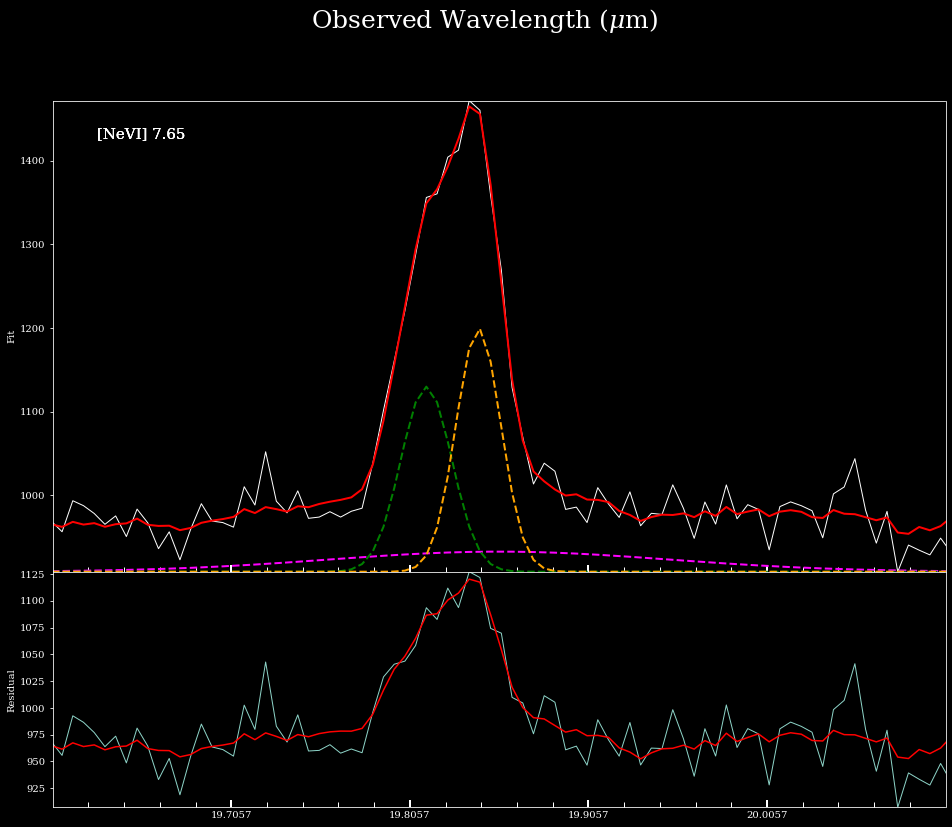

In [40]:
q3do.plot_line(q3di, plotargs=argsplotline)

#from matplotlib import pyplot as plt
#plt.plot(q3do.wave, q3do.spec, color='k')
#plt.plot(q3do.wave, q3do.cont_fit+q3do.line_fit, color='r')

#from q3dfit.q3dmath import cmplin
#flux1 = cmplin(q3do, '[NeVI]7.65', 0, velsig=True)
#flux2 = cmplin(q3do, '[NeVI]7.65', 1, velsig=True)
#plt.plot(q3do.wave, flux1)
#plt.plot(q3do.wave, flux2)
#print(flux1)

The continuum plot can be changed by specifying several parameters. In this case, we have chosen to output a linear/linear plot of f$_\lambda$ vs. wavelength.

In [41]:
argscontplot = dict()
argscontplot['xstyle'] = 'lin'
argscontplot['ystyle'] = 'lin'
argscontplot['fluxunit_out'] = 'flambda'
argscontplot['mode'] = 'dark'

In [42]:
argscontplot['IR'] = True

Run two methods. The first computes the continuum values to plot, and the second does the plotting.

Because we specified `decompose_qso_fit=True` in the `q3di` object, three plots are created: one for the host-only light, one for quasar-only light, and one for the total continuum.

True questfit


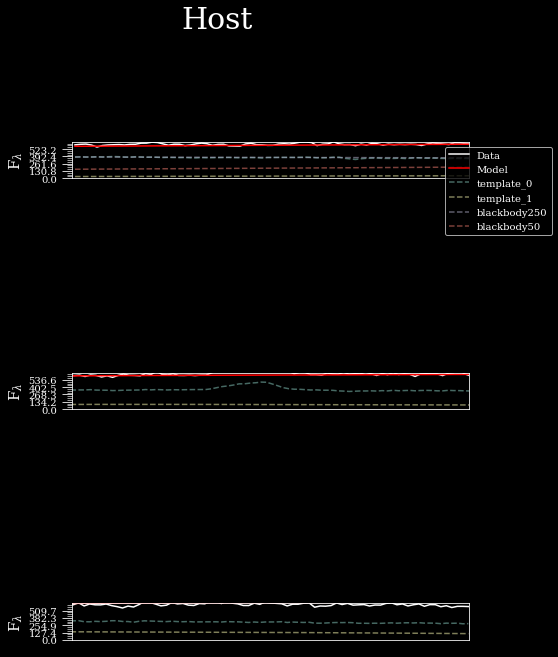

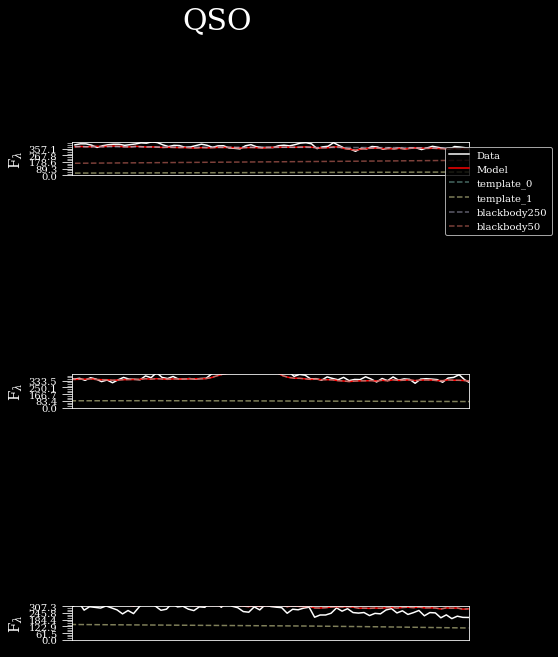

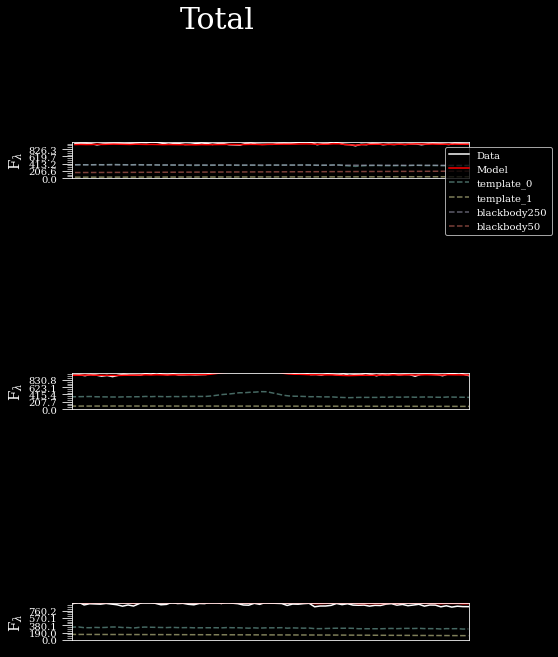

In [43]:
print(q3di.decompose_qso_fit, q3di.fcncontfit)
q3do.sepcontpars(q3di)
q3do.plot_cont(q3di, plotargs=argscontplot)

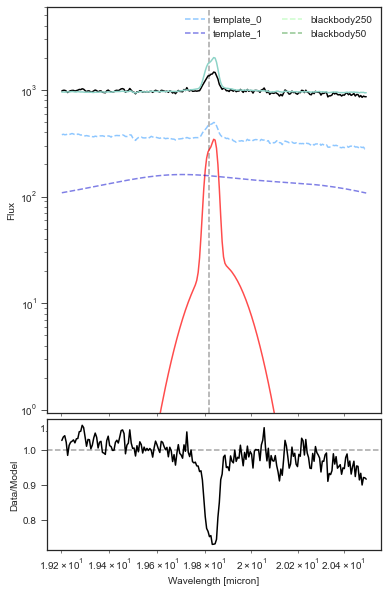

<Figure size 432x288 with 0 Axes>

In [45]:
from q3dfit.plot import plotdecomp
plotdecomp(q3do, q3di, show=True, do_lines=True)


## 4. Combine fit results from all spaxels.<a class="anchor" id="chapter4"></a>

This routine takes all of the spaxels you fit and combines the line- and continuum-fitting results together. The outputs are saved into two files. This example assumes that the spaxels listed here in each dimension have been fit.

In [ ]:
cols = [0,35]
rows = [18]
rows = [0,35]
from q3dfit.q3dcollect import q3dcollect
q3dcollect(q3di, cols=cols, rows=rows)

## 5. Plot science products. <a class="anchor" id="chapter5"></a>

These routines take the output of `q3dcollect` and process them further for science output. The `q3dpro` class has methods to make maps of physical quantities.

In [34]:
import q3dfit.q3dpro as q3dpro
qpro = q3dpro.Q3Dpro(q3di, PLATESCALE=0.025, NOCONT=True)

Start by plotting linemaps for [OIII], of both flux and velocity measures. The parameters listed below control the plotting.

In [35]:
wave0,linetext,dataOUT = qpro.get_linemap('[NeVI]7.65',LINEVAC=True,APPLYMASK=True)
dataOUT,ncomp = qpro.resort_line_components(dataOUT,NCOMP=q3di.ncomp)
print(dataOUT.keys())
print(dataOUT['Ftot']['data'])
data1 = dataOUT['Ftot']['data']
print(data1.shape)
print(np.sum(np.isnan(data1)))
#print(linemap['Ftot']['data'])
#import pdb; pdb.set_trace()

getting line data... [NeVI]7.65
dict_keys(['Ftot', 'Fci', 'Sig', 'v50', 'w80'])
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
(35, 35)
570


Plotting emission line maps
getting line data... [NeVI]7.65
Saving line map: XID2028_[NeVI]7.65_Ftot_map.fits
Saving line map: XID2028_[NeVI]7.65_Fci_c1_map.fits
Saving line map: XID2028_[NeVI]7.65_Fci_c2_map.fits
Saving line map: XID2028_[NeVI]7.65_Fci_c3_map.fits
Saving line map: XID2028_[NeVI]7.65_Sig_c1_map.fits
Saving line map: XID2028_[NeVI]7.65_Sig_c2_map.fits
Saving line map: XID2028_[NeVI]7.65_Sig_c3_map.fits
Saving line map: XID2028_[NeVI]7.65_v50_c1_map.fits
Saving line map: XID2028_[NeVI]7.65_v50_c2_map.fits
Saving line map: XID2028_[NeVI]7.65_v50_c3_map.fits
Saving line map: XID2028_[NeVI]7.65_w80_c1_map.fits
Saving line map: XID2028_[NeVI]7.65_w80_c2_map.fits
Saving line map: XID2028_[NeVI]7.65_w80_c3_map.fits
Saving figure: [NeVI]7.65_emlin_map


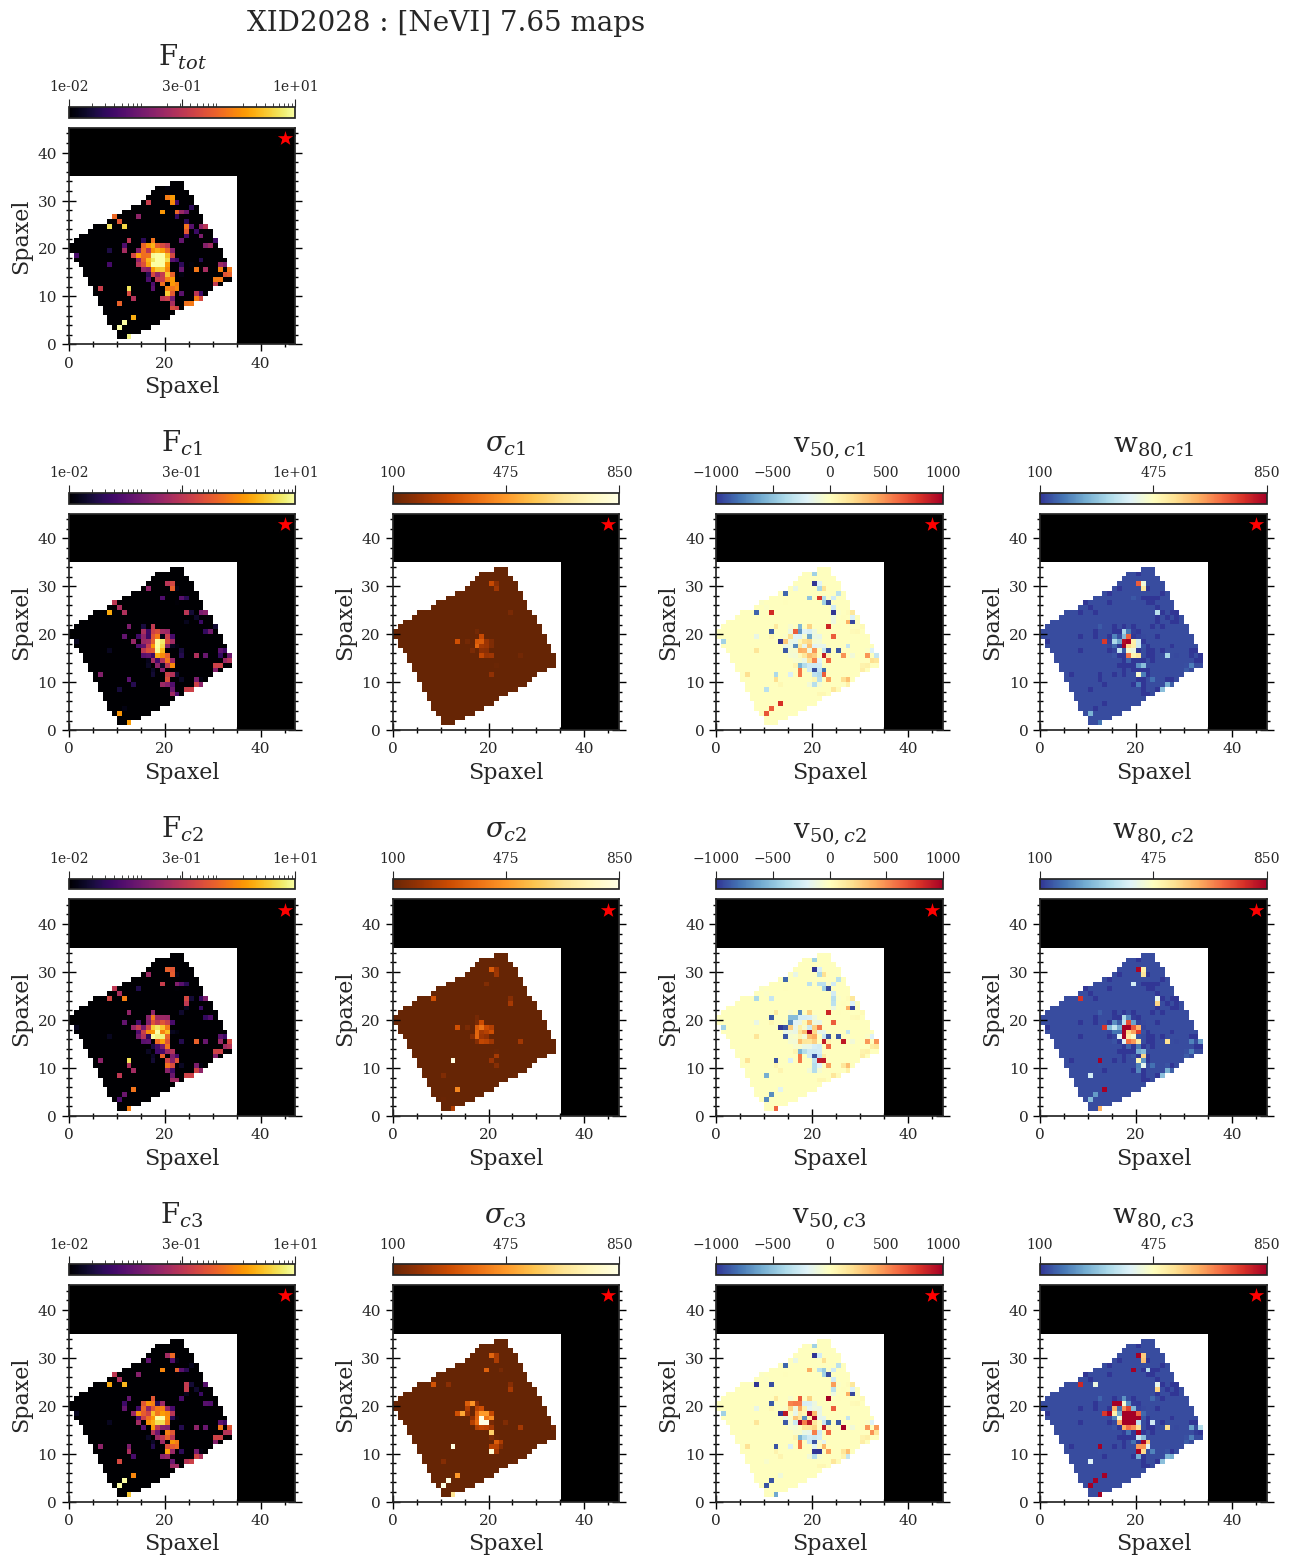

In [47]:
do_kpc = False
saveFile = True
flx = [1e-2,1e1]
qsocenter = [45., 43.]
pltarg = {'Ftot':flx,
          'Fci':flx,
          'Sig':[100.,850.],
          'v50':[-1000.,1000.],
          'w80':[100.,850.],
          'fluxlog': True}
qpro.make_linemap('[NeVI]7.65', XYSTYLE=do_kpc, xyCenter=qsocenter,
                  SAVEDATA=saveFile, VMINMAX=pltarg, PLTNUM=1, CMAP='inferno')

Map of [OIII]/H$\beta$ for each component, and for the total flux:

In [37]:
qpro.make_lineratio_map('[OIII]5007', 'Hbeta', VMINMAX=[0,1])

TypeError: 'NoneType' object is not subscriptable

Map of v50 over the cumulative velocity distribution:

In [ ]:
from q3dfit.q3dpro import OneLineData
o3data = OneLineData(qpro.linedat, '[OIII]5007')
o3data.calc_cvdf(2.9489, [-1e3, 1e3], vstep=5)
o3data.make_cvdf_map(50., velran=[-1e3, 1e3], markcenter=[45., 43.],
                     outfile=True)

Map of W80 over the cumulative velocity distribution:

In [ ]:
from matplotlib.pyplot import *
imshow(o3data.calc_cvdf_vel(90, calc_from_posvel=False).T - o3data.calc_cvdf_vel(10, calc_from_posvel=False).T, 
       origin='lower', cmap='bwr', vmin=50, vmax=1500)
colorbar()